### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x000001E7CB821B80>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 2: Pre-processing and ML modeling 

***

# Importe modules

In [2]:
import librosa
import librosa.display
import os
import glob
import warnings
import random
import mimetypes
import sklearn
import itertools
import pickle
import time
import ast


import pandas  as pd
import seaborn as sns
import numpy   as np
import IPython.display as ipd

from matplotlib  import pyplot as plt

from tqdm                      import tqdm
from collections               import Counter
from matplotlib.patches        import Patch

from sklearn                   import metrics
from sklearn                   import preprocessing
from sklearn.model_selection   import StratifiedKFold, StratifiedShuffleSplit, KFold, GridSearchCV, learning_curve, cross_val_score, train_test_split
from sklearn.mixture           import GaussianMixture
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import GaussianNB, CategoricalNB
from sklearn.svm               import SVC
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn.neural_network    import MLPClassifier

# Solution to play .ogg files in the IPython 
# https://stackoverflow.com/questions/39077987/ipython-display-audio-cannot-correctly-handle-ogg-file-type

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

SEED       = 1000

# Loading the dataset


In [3]:
# Global variables

opc = 0
while str(opc) not in '12':
    print()
    print("1-) ESC-10")
    print("2-) ESC-50")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\98_dataset\\ESC\\ESC-10\\"
    path_pic    = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\96_code_cv\\ESC-10_Results\\"
    path_models = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\96_code_cv\\ESC-10_Saved_models\\"

    subfolders  = next(os.walk(path))[1]
    dict_list   = []
    db_B        = pd.DataFrame(columns=['Class_ID', 'Class_categorical', 'Fold', 'Clip_ID', 'Clip_take', 'File_name'])
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    pkl_feature = 'ESC-10_features_original.pkl'
    pkl_aug_features = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'
    dog_set = 'Dog bark'

else:
    
    path        = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\98_dataset\\ESC\\ESC-50\\"
    path_pic    = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\96_code_cv\\ESC-50_Results\\"
    path_models = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\96_code_cv\\ESC-50_Saved_models\\"

    subfolders  = next(os.walk(path))[1]
    dict_list   = []
    db_B        = pd.DataFrame(columns=['Class_ID', 'Class_categorical', 'Fold', 'Clip_ID', 'Clip_take', 'File_name'])
    nom_dataset = 'ESC-50' 
    csv_file    = 'ESC-50.csv'
    pkl_feature = 'ESC-50_features_original.pkl'
    pkl_aug_features = 'ESC-50_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-50_features_augmented.pkl'
    dog_set = 'Dog'


1-) ESC-10
2-) ESC-50

Select the dataset: 1


In [4]:
# Method to read the folders, sound files and create the dataframe

def readDoc(path: str, subfolders: str):

    for folder in subfolders:
        os.chdir(path + folder)
        sounds = (glob.glob('*.ogg'))
        for s in sounds:
            row_dict = {'Class_ID': folder[:3],
                        'Class_categorical': folder[6:],
                        'Fold': s[0],
                        'Clip_ID': str(s[2:-6]),
                        'Clip_take': s[-5:-4],
                        'File_name': s}
            dict_list.append(row_dict)
    return pd.DataFrame.from_dict(dict_list)


# Export the dataframe as CSV file
def exportCSV(path: str, db, csv_fn):

    os.chdir(path)
    db.to_csv(csv_fn)
    print("\nCSV exported.\nCheck the folder", path)

In [5]:
# Method to create an one hot encoder vector (OHEV)

def OHEV(df: list, cat_class: str):
    
    df_class  = df[cat_class]
    
    return np.array(pd.get_dummies(df_class, columns = [str], dtype=int))

In [6]:
DB        = readDoc(path, subfolders)
DB_unique = np.unique(DB["File_name"])

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nDataset content: ", DB.index, "\n\n", DB)
print("\nTotal number of unique files..........: ", len(DB_unique))
print("Total number of OGG files.............: ", len(DB))

exportCSV(path, DB, csv_file)


Classes:
--------------------
Class_categorical
Dog bark          40
Rain              40
Sea waves         40
Baby cry          40
Clock tick        40
Person sneeze     40
Helicopter        40
Chainsaw          40
Rooster           40
Fire crackling    40
Name: count, dtype: int64

Dataset content:  RangeIndex(start=0, stop=400, step=1) 

     Class_ID Class_categorical Fold Clip_ID Clip_take       File_name
0        001          Dog bark    1  100032         A  1-100032-A.ogg
1        001          Dog bark    1  110389         A  1-110389-A.ogg
2        001          Dog bark    1   30226         A   1-30226-A.ogg
3        001          Dog bark    1   30344         A   1-30344-A.ogg
4        001          Dog bark    1   32318         A   1-32318-A.ogg
..       ...               ...  ...     ...       ...             ...
395      010    Fire crackling    5  193473         A  5-193473-A.ogg
396      010    Fire crackling    5  193473         B  5-193473-B.ogg
397      010    Fire crac

In [7]:
DB

,Class_ID,Class_categorical,Fold,Clip_ID,Clip_take,File_name
0,001,Dog bark,1,100032,A,1-100032-A.ogg
1,001,Dog bark,1,110389,A,1-110389-A.ogg
2,001,Dog bark,1,30226,A,1-30226-A.ogg
3,001,Dog bark,1,30344,A,1-30344-A.ogg
4,001,Dog bark,1,32318,A,1-32318-A.ogg
...,...,...,...,...,...,...
395,010,Fire crackling,5,193473,A,5-193473-A.ogg
396,010,Fire crackling,5,193473,B,5-193473-B.ogg
397,010,Fire crackling,5,213802,A,5-213802-A.ogg
398,010,Fire crackling,5,215658,A,5-215658-A.ogg


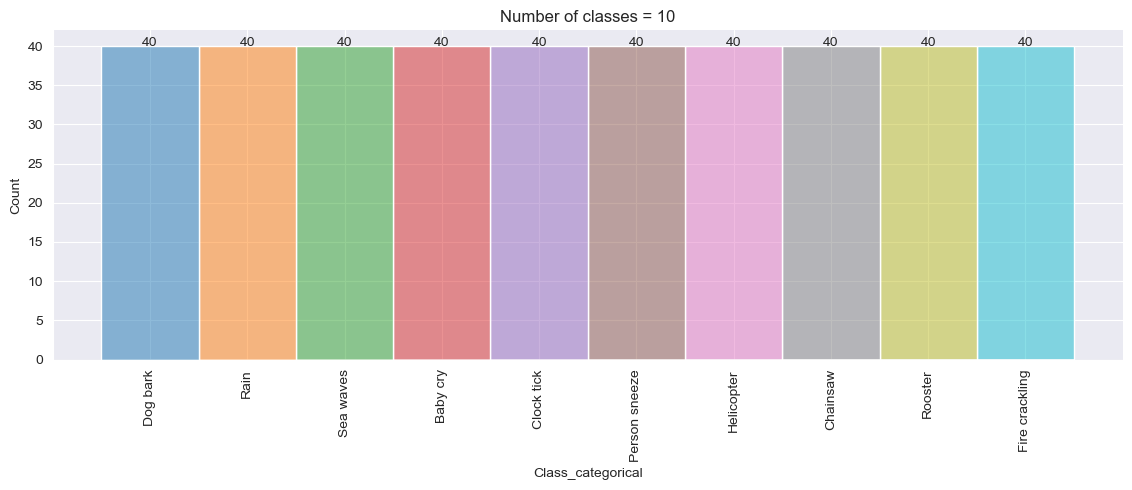

In [8]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

# Pre-processing the data (Features extraction)

## Exploratory code that lead to a class for extracting the features

Hand crafting the features into the dataframe

In [9]:
os.chdir(path)

In [10]:
pwd

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\98_dataset\\ESC\\ESC-10'

In [11]:
# Method to create an one hot encoder vector (OHEV)

def OHEV(df: list, cat_class: str):
    
    df_class  = df[cat_class]
    
    return np.array(pd.get_dummies(df_class, columns = [str], dtype=int))

In [12]:
# Create the one hot encoder vector (OHEV) in the dataframe

class_enc = OHEV(DB, 'Class_categorical')
DB.insert(loc = 2, column = 'Class_OHEV', value = class_enc.tolist())

In [13]:
# Group by the class and get one random sample of each class
k = DB.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical     
Baby cry           156    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Chainsaw           308    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Clock tick         180    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Dog bark           7      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Fire crackling     384    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Helicopter         269    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Person sneeze      208    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Rain               49     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Rooster            332    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Sea waves          108    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'Baby cry': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Chainsaw': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'Clock tick': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'Dog bark': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'Fire crackling': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'Helicopter': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'Person sneeze': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'Rain': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'Rooster': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'Sea waves': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [14]:
DB

,Class_ID,Class_categorical,Class_OHEV,Fold,Clip_ID,Clip_take,File_name
0,001,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,100032,A,1-100032-A.ogg
1,001,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,110389,A,1-110389-A.ogg
2,001,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,30226,A,1-30226-A.ogg
3,001,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,30344,A,1-30344-A.ogg
4,001,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,32318,A,1-32318-A.ogg
...,...,...,...,...,...,...,...
395,010,Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,193473,A,5-193473-A.ogg
396,010,Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,193473,B,5-193473-B.ogg
397,010,Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,213802,A,5-213802-A.ogg
398,010,Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,215658,A,5-215658-A.ogg


In [15]:
type(DB['Class_OHEV'][0][0])

int

In [16]:
encoder_dict[dog_set]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [17]:
# Method to parse each row and extract the defined audio feature

def feature_parser(row): 
    # Number of MFCCs
    n_mfcc = 13
    n_mels = 128
    
    # Define the whole path for the audio file
    fn = os.path.join(path, str(row.Class_ID) +' - ' + str(row.Class) + '\\'+ str(row.File_name))

    # Load the audio file using "kaiser_fast" resampling method, otherwise use sr = 44100
    x, srate = librosa.load(fn, sr = SR)

    # Extract the features: RMS, ZCR 
    row['RMSE']      = np.mean(librosa.feature.rms(y                = x, hop_length = HOP_LENGTH, frame_length = FRAME_SIZE))
    row['ZCR']       = np.mean(librosa.feature.zero_crossing_rate(y = x, hop_length = HOP_LENGTH, frame_length = FRAME_SIZE))
    row['CENTROIDS'] = np.mean(librosa.feature.spectral_centroid(y  = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    row['BANDWIDTH'] = np.mean(librosa.feature.spectral_bandwidth(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    row['ROLLOFF']   = np.mean(librosa.feature.spectral_rolloff(y   = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    row['BPM'], _    = librosa.beat.beat_track(y                    = x, hop_length = HOP_LENGTH, sr = srate)
    
    # The next features have decomposed information which can't be aggregated directly by np.mean()
    #row['CONTRAST']  = np.mean(librosa.feature.spectral_contrast(y  = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate,))
    #row['CHROMA']    = np.mean(librosa.feature.chroma_stft(y        = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    #row['TONNETZ']   = np.mean(librosa.feature.tonnetz(y            = librosa.effects.harmonic(x), sr = SR)

    # 128 x frames matrix
    mel              = librosa.feature.melspectrogram(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate, n_mels = n_mels)
    for i in range(0, n_mels):
        row[f'MEL_{i+1}'] = np.mean(mel[i])
    
    # 13 x frames matrix
    mfcc             = librosa.feature.mfcc(y = x, sr = srate, n_mfcc = n_mfcc)
    for i in range(0, n_mfcc):
        row[f'MFCC_{i+1}'] = np.mean(mfcc[i])

    # 7 x frames matrix
    spec_contrast    = librosa.feature.spectral_contrast(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate)
    spec_contrast_sp = np.shape(spec_contrast)
    for i in range(0, spec_contrast_sp[0]):
        row[f'CONSTRAST_{i+1}'] = np.mean(spec_contrast[i])
    
    # 12 x frames matrix
    chroma           = librosa.feature.chroma_stft(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate)
    chroma_sp        = np.shape(chroma)
    for i in range(0, chroma_sp[0]):
        row[f'CHROMA_{i+1}'] = np.mean(chroma[i])
    
    # 6 x frames matrix
    tonnetz          = librosa.feature.tonnetz(y = librosa.effects.harmonic(x), sr = srate)
    tonnetz_sp       = np.shape(tonnetz)
    for i in range(0, tonnetz_sp[0]):
        row[f'TONNETZ_{i+1}'] = np.mean(tonnetz[i])
    
    return row

In [18]:
#print("Frame size...: ", FRAME_SIZE)
#print("Hop lenght...: ", HOP_LENGTH)
#print()
#tqdm.pandas()

#DB = DB.progress_apply(feature_parser, axis = 1)

In [19]:
# Read the csv file with the features extracted
#import ast

#def convert_to_list(string):
#    return ast.literal_eval(string)
#
#DB = pd.read_csv(path + csv_feature, sep='\t',  converters={'Class_encoder': convert_to_list})

# Pre-processing the data (Features extraction)

Hand crafting the features into the dataframe

In [20]:
from MT_loadESC import loadESC
from MT_audioPP import audioPP

#Global variables

ROOT        = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\98_dataset\\ESC\\"
DATASET     = nom_dataset

In [21]:
loadESC = loadESC(ROOT, DATASET)
db      = loadESC.db_B

print("\nClasses:\n--------------------")
print(db["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(db["File_name"])))
print("Total number of WAV files.............: ", len(db))


CSV exported.
Check the folder : C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\

Classes:
--------------------
Class_categorical
Dog bark          40
Rain              40
Sea waves         40
Baby cry          40
Clock tick        40
Person sneeze     40
Helicopter        40
Chainsaw          40
Rooster           40
Fire crackling    40
Name: count, dtype: int64

Total number of unique files..........:  400
Total number of WAV files.............:  400


In [22]:
db = pd.read_csv(path + csv_file)
db = db.drop('Unnamed: 0', axis=1)
db

,Class_ID,Class_categorical,Class_OHEV,Fold,Clip_ID,Clip_take,File_name,Path
0,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,100032,A,1-100032-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-100032-A.ogg
1,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,110389,A,1-110389-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-110389-A.ogg
2,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,30226,A,1-30226-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-30226-A.ogg
3,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,30344,A,1-30344-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-30344-A.ogg
4,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,32318,A,1-32318-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-32318-A.ogg
...,...,...,...,...,...,...,...,...
395,10,Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,193473,A,5-193473-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\010 - Fire crackling\5-193473-A.ogg
396,10,Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,193473,B,5-193473-B.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\010 - Fire crackling\5-193473-B.ogg
397,10,Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,213802,A,5-213802-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\010 - Fire crackling\5-213802-A.ogg
398,10,Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,215658,A,5-215658-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\010 - Fire crackling\5-215658-A.ogg


In [23]:
type(db['Class_OHEV'][0])

str

In [24]:
dog = db[db['Class_categorical'] == dog_set]
dog

,Class_ID,Class_categorical,Class_OHEV,Fold,Clip_ID,Clip_take,File_name,Path
0,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,100032,A,1-100032-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-100032-A.ogg
1,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,110389,A,1-110389-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-110389-A.ogg
2,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,30226,A,1-30226-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-30226-A.ogg
3,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,30344,A,1-30344-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-30344-A.ogg
4,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,32318,A,1-32318-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-32318-A.ogg
5,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,59513,A,1-59513-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-59513-A.ogg
6,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,85362,A,1-85362-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-85362-A.ogg
7,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,97392,A,1-97392-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\1-97392-A.ogg
8,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,114280,A,2-114280-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\2-114280-A.ogg
9,1,Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,114587,A,2-114587-A.ogg,C:\Andre_Florentino\03_particular\04_mestrado-FEI\98_dataset\ESC\ESC-10\001 - Dog bark\2-114587-A.ogg


In [25]:
dog['Path'][38]

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\98_dataset\\ESC\\ESC-10\\001 - Dog bark\\5-231762-A.ogg'

In [26]:
ipd.Audio(dog['Path'][38], rate = 22050)

In [27]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP = audioPP(db['Path'].values,
                  db['Class_categorical'].values, 
                  db['Class_OHEV'].values, 
                  db['Fold'].values,
                  time_length = 5,
                  threshold = 60,
                  aug = False,
                  windowing = False,
                  frames = 44)
    
X, y_string, y_OHEV, folds  = audioPP.audio_windowed, audioPP.labels_cat_wind, audioPP.labels_cod_wind, audioPP.labels_fold_wind

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:05<00:00, 67.54it/s]
400it [00:03, 107.45it/s]

Shape of the audio data..................: (400, 110250)
Shape of the categorical label data......: (400,)
Shape of the one hot encoder label data..: (400,)
Shape of the fold data...................: (400,)


In [28]:
y_OHEV = [np.array(eval(s)) for s in y_OHEV]

In [29]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')

In [30]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [31]:
dog_aug = db_aug[db_aug['Class_categorical'] == dog_set]
dog_aug

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-1.3767974e-05, 6.560702e-06, 1.5261583e-05, 2.7101487e-07, -3.189547e-06, 1.5014208e-05, 5.1874667e-06, -9.778421e...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
1,"[-0.0015367204, -0.0004744595, -0.00023626443, -0.0003487179, -6.3199084e-05, -7.6471595e-05, 0.00013974216, 0.00018...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
2,"[-0.0072659636, -0.01090739, -0.009381778, -0.010274444, -0.009296817, -0.009827967, -0.009601067, -0.00977385, -0.0...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
3,"[-0.00019857194, -0.00022303371, -0.00032965082, -0.0005635341, -0.0006325695, -0.0006501522, -0.0007629838, -0.0008...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
4,"[0.007044793, 0.010916248, 0.010607904, 0.011737926, 0.011549781, 0.013294231, 0.013100689, 0.01324819, 0.013393954,...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
5,"[0.0016943663, 0.0030272454, 0.0026503652, 0.0023270324, 0.0021647066, 0.0021035895, 0.0020216852, 0.002207093, 0.00...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
6,"[0.011344401, 0.013015762, 0.0070513356, 0.008501161, 0.0065534217, 0.0061160093, 0.0027400893, -0.0011039008, -0.00...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
7,"[-0.00038099848, -0.00038466882, -0.00032229256, -0.00028563663, -0.0001074709, -8.833222e-05, 2.4365261e-05, -4.980...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
8,"[6.6901324e-05, 8.944953e-05, 0.00012287633, 0.0001384059, 0.0001756732, 0.00019694935, 0.0002048823, 0.00023043892,...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
9,"[0.0026374813, 0.0008704532, -0.0011712611, -0.0031065568, -0.006483536, -0.00801089, -0.007848746, -0.0035639796, -...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2


In [32]:
dog_aug

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-1.3767974e-05, 6.560702e-06, 1.5261583e-05, 2.7101487e-07, -3.189547e-06, 1.5014208e-05, 5.1874667e-06, -9.778421e...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
1,"[-0.0015367204, -0.0004744595, -0.00023626443, -0.0003487179, -6.3199084e-05, -7.6471595e-05, 0.00013974216, 0.00018...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
2,"[-0.0072659636, -0.01090739, -0.009381778, -0.010274444, -0.009296817, -0.009827967, -0.009601067, -0.00977385, -0.0...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
3,"[-0.00019857194, -0.00022303371, -0.00032965082, -0.0005635341, -0.0006325695, -0.0006501522, -0.0007629838, -0.0008...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
4,"[0.007044793, 0.010916248, 0.010607904, 0.011737926, 0.011549781, 0.013294231, 0.013100689, 0.01324819, 0.013393954,...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
5,"[0.0016943663, 0.0030272454, 0.0026503652, 0.0023270324, 0.0021647066, 0.0021035895, 0.0020216852, 0.002207093, 0.00...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
6,"[0.011344401, 0.013015762, 0.0070513356, 0.008501161, 0.0065534217, 0.0061160093, 0.0027400893, -0.0011039008, -0.00...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
7,"[-0.00038099848, -0.00038466882, -0.00032229256, -0.00028563663, -0.0001074709, -8.833222e-05, 2.4365261e-05, -4.980...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
8,"[6.6901324e-05, 8.944953e-05, 0.00012287633, 0.0001384059, 0.0001756732, 0.00019694935, 0.0002048823, 0.00023043892,...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
9,"[0.0026374813, 0.0008704532, -0.0011712611, -0.0031065568, -0.006483536, -0.00801089, -0.007848746, -0.0035639796, -...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2


In [33]:
type(db_aug['Class_OHEV'][0])

numpy.ndarray

In [34]:
ipd.Audio(dog_aug['Audio'][35], rate = 22050)

In [35]:
librosa.get_duration(y = dog_aug['Audio'][35])

5.0

In [62]:
from MT_feature_extractor import feature_extractor

In [63]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

feature_extractor = feature_extractor(db_aug)
DB_augmented = feature_extractor.DB_aug

100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [30:10<00:00,  1.33it/s]


In [38]:
# Check for NaN values in the entire DataFrame
has_nan_columnwise = DB_augmented.isna().any(axis=0)

# Print columns with NaN values
print("Columns with NaN values:")
print(has_nan_columnwise[has_nan_columnwise])

Columns with NaN values:
CHROMA_skew_1         True
CHROMA_kurtosis_1     True
CHROMA_skew_2         True
CHROMA_kurtosis_2     True
CHROMA_skew_3         True
CHROMA_kurtosis_3     True
CHROMA_skew_4         True
CHROMA_kurtosis_4     True
CHROMA_skew_5         True
CHROMA_kurtosis_5     True
CHROMA_skew_6         True
CHROMA_kurtosis_6     True
CHROMA_skew_7         True
CHROMA_kurtosis_7     True
CHROMA_skew_8         True
CHROMA_kurtosis_8     True
CHROMA_skew_9         True
CHROMA_kurtosis_9     True
CHROMA_skew_10        True
CHROMA_kurtosis_10    True
CHROMA_skew_11        True
CHROMA_kurtosis_11    True
CHROMA_skew_12        True
CHROMA_kurtosis_12    True
dtype: bool


In [64]:
DB_augmented.fillna(0, inplace=True)

In [65]:
DB_augmented

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-1.3767974e-05, 6.560702e-06, 1.5261583e-05, 2.7101487e-07, -3.189547e-06, 1.5014208e-05, 5.1874667e-06, -9.778421e...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.025425,-0.026296,-0.531440,-0.343371
1,"[-1.7668120563030243e-05, -3.5698467399924994e-05, -1.931440783664584e-05, -7.863069185987115e-06, -8.70289659360423...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.026299,-0.041034,0.217015,-0.746104
2,"[-2.1720765e-05, 0.00010475286, 0.00019316572, 0.00025172875, 0.00036776988, 0.00046772615, 0.000561155, 0.000610138...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.032917,-0.017070,0.071701,-0.411484
3,"[-1.8694685e-06, 3.5647074e-07, 5.222207e-06, 4.6744094e-06, 1.8501424e-06, -8.5931987e-07, 2.5762956e-06, 3.946978e...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.028921,0.012236,0.045008,-0.453769
4,"[-4.3592587e-05, -2.0006839e-05, 1.751376e-05, 5.3520853e-05, 7.4054966e-05, 7.835751e-05, 7.61583e-05, 7.352675e-05...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.027995,0.032727,0.185548,-0.502361
...,...,...,...,...,...,...,...,...,...
2395,"[-0.17522355914115906, -0.18252068758010864, -0.18808652460575104, -0.19727374613285065, -0.20042969286441803, -0.20...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.021181,0.005403,0.251889,-0.646567
2396,"[0.052693825, 0.08963939, 0.077772535, 0.07330648, 0.07560171, 0.07816128, 0.07244203, 0.07893729, 0.07996931, 0.079...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.025976,0.015526,-0.302515,-0.278720
2397,"[0.05291145, 0.08921811, 0.07753514, 0.073034376, 0.07519554, 0.07751592, 0.07197734, 0.0785395, 0.079810016, 0.0798...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.024113,0.016474,0.052828,-0.731086
2398,"[0.049761876, 0.09019045, 0.07195007, 0.07658597, 0.07598646, 0.0745673, 0.08006861, 0.07910959, 0.0769081, 0.077690...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.030500,-0.004993,0.165909,-0.545296


In [69]:
pkl_aug_features

'ESC-10_features_augmented_no_windowing.pkl'

In [68]:
print(type(DB_augmented['Fold'][0]))
print(type(DB_augmented['Class_OHEV'][0][0]))
print(type(DB_augmented['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [70]:
# Save the features to a pickle file

#DB_augmented.to_pickle(path + pkl_feature)
#DB_augmented.to_pickle(path + pkl_aug_features)
#DB_augmented.to_pickle(path + pkl_aug_wind_features)

In [36]:
# Read the pkl file with the augmented features extracted

DB_ori_from_pkl = pd.read_pickle(path + pkl_feature)
DB_aug_from_pkl = pd.read_pickle(path + pkl_aug_features)
#DB_aug_from_pkl = pd.read_pickle(path + pkl_aug_wind_features)

In [37]:
print(len(DB_ori_from_pkl))
print(len(DB_aug_from_pkl))

400
2400


In [38]:
DB_ori_from_pkl.shape

(400, 379)

In [39]:
for i in DB_ori_from_pkl.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [40]:
DB_aug_from_pkl.shape

(2400, 379)

In [41]:
for i in DB_aug_from_pkl.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


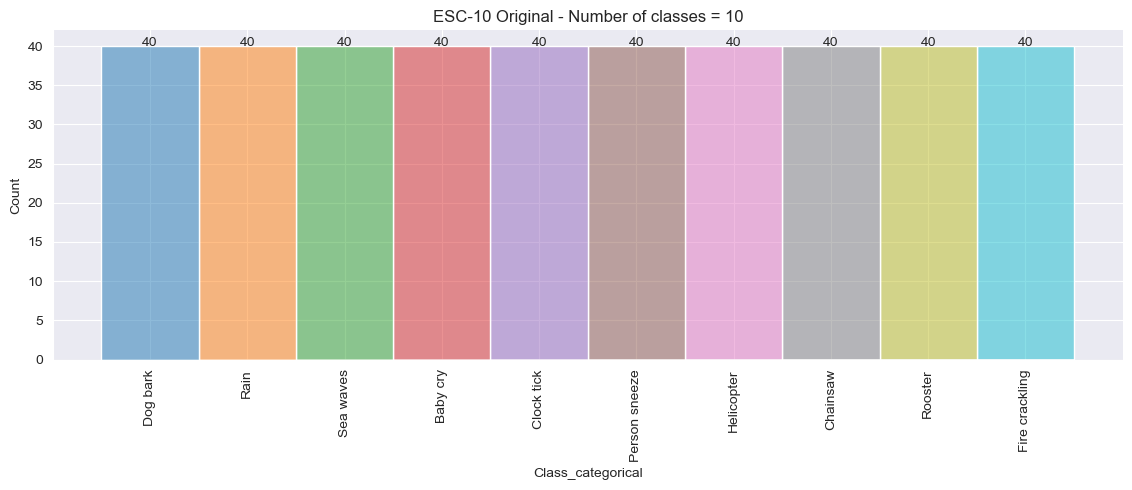

In [42]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = DATASET + ' Original - Number of classes = ' + str(len(pd.Series(DB_ori_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_ori_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(path_pic + '02_PreProcessing_modeling_00_1.png')

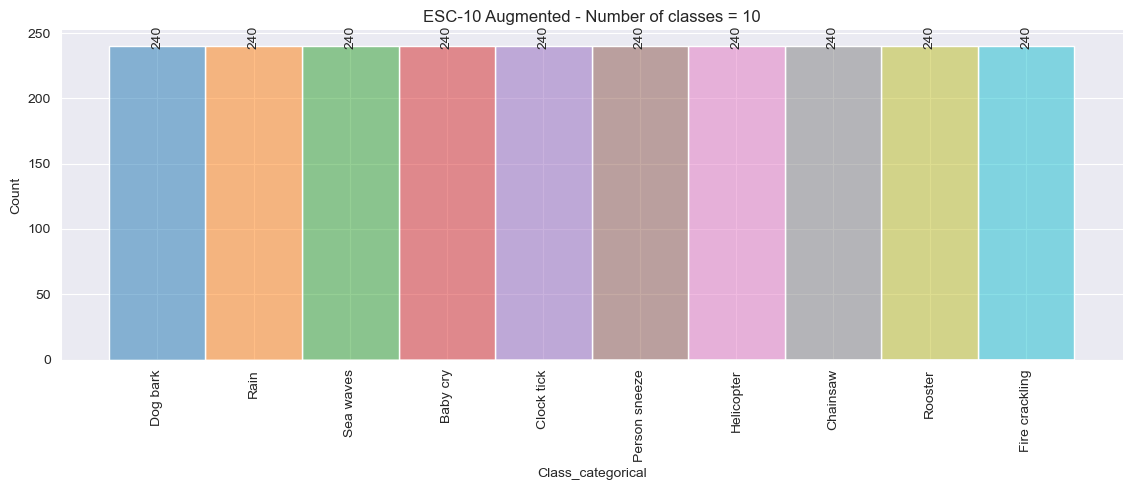

In [43]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = DATASET + ' Augmented - Number of classes = ' + str(len(pd.Series(DB_aug_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center', rotation=90)
        
g._legend.remove()

plt.tight_layout()
plt.savefig(path_pic + '02_PreProcessing_modeling_00_2.png')

In [44]:
DB_ori_from_pkl.Class_categorical

0            Dog bark
1            Dog bark
2            Dog bark
3            Dog bark
4            Dog bark
            ...      
395    Fire crackling
396    Fire crackling
397    Fire crackling
398    Fire crackling
399    Fire crackling
Name: Class_categorical, Length: 400, dtype: object

In [45]:
db_aug[2:3]

,Audio,Class_categorical,Class_OHEV,Fold
2,"[-0.0072659636, -0.01090739, -0.009381778, -0.010274444, -0.009296817, -0.009827967, -0.009601067, -0.00977385, -0.0...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1


In [46]:
db_aug[2:3]['Audio']

2    [-0.0072659636, -0.01090739, -0.009381778, -0.010274444, -0.009296817, -0.009827967, -0.009601067, -0.00977385, -0.0...
Name: Audio, dtype: object

In [47]:
db_aug['Audio'][2]

array([-0.00726596, -0.01090739, -0.00938178, ...,  0.01494366,
        0.01460058,  0.01620727], dtype=float32)

In [48]:
ipd.Audio(db_aug['Audio'][2], rate = 22050)

In [49]:
#teste = pd.DataFrame(db_aug[2:3])
#teste

In [50]:
# Method to parse each row and extract the defined audio feature

def MFCC_parser(row): 
    # Number of MFCCs
    n_mfcc = 13
   
    # 13 x frames matrix
    mfcc = librosa.feature.mfcc(y = row.Audio, sr = 22050, n_mfcc = n_mfcc)
    for i in range(0, n_mfcc):
        row[f'MFCC_{i+1}'] = np.array(mfcc[i])
  
    return row

In [51]:
# Method to parse each row and extract the defined audio feature

def TONNETZ_parser(row): 

    # 6 x frames matrix
    tonnetz    = librosa.feature.tonnetz(y = librosa.effects.harmonic(row.Audio), sr = 22050)
    tonnetz_sp = np.shape(tonnetz)
    for i in range(0, tonnetz_sp[0]):
        row[f'TONNETZ_{i+1}'] = np.array(tonnetz[i])    

    return row

In [52]:
# Method to parse each row and extract the defined audio feature

def MEL_parser(row): 
    
    n_mels = 128

    # 128 x frames matrix
    mel = librosa.feature.melspectrogram(y = row.Audio, hop_length = 512, n_fft = 2048, sr = 22050, n_mels = n_mels)
    for i in range(0, n_mels):
        row[f'MEL_{i+1}'] = np.array(mel[i])

    return row

In [53]:
# Method to parse each row and extract the defined audio feature

def CONTRAST_parser(row): 

    # 7 x frames matrix
    spec_contrast    = librosa.feature.spectral_contrast(y = row.Audio, hop_length = 512, n_fft = 2048, sr = 22050)
    spec_contrast_sp = np.shape(spec_contrast)
    for i in range(0, spec_contrast_sp[0]):
        row[f'CONSTRAST_{i+1}'] = np.array(spec_contrast[i])

    return row

In [54]:
# Method to parse each row and extract the defined audio feature

def CHROMA_parser(row): 

    # 12 x frames matrix
    chroma    = librosa.feature.chroma_stft(y = row.Audio, hop_length = 512, n_fft = 2048, sr = 22050)
    chroma_sp = np.shape(chroma)
    for i in range(0, chroma_sp[0]):
        row[f'CHROMA_{i+1}'] = np.array(chroma[i])

    return row

In [55]:
MFCC_columns      = list(DB_ori_from_pkl.filter(regex='MFCC_\d', axis=1).columns)
TONNETZ_columns   = list(DB_ori_from_pkl.filter(regex='^TONNETZ_\d', axis=1).columns)
MEL_columns       = list(DB_ori_from_pkl.filter(regex='^MEL_\d', axis=1).columns)
CONSTRAST_columns = list(DB_ori_from_pkl.filter(regex='^CONSTRAST_\d', axis=1).columns)
CHROMA_columns    = list(DB_ori_from_pkl.filter(regex='^CHROMA_\d', axis=1).columns)

In [56]:
#teste = teste.apply(MFCC_parser, axis = 1)
#teste

In [57]:
#MFCC_vert = MFCC_columns.apply(lambda x: pd.Series(x.values[0]))
#MFCC_vert

In [58]:
#f = plt.figure(figsize=(10, 6))
#MFCC_vert = MFCC_columns.apply(lambda x: pd.Series(x.values[0]))
#sns.boxplot(MFCC_vert,  orient = "h", order=list(reversed(MFCC_vert.columns)))
#plt.show

In [59]:
def plot_MFCC_features(feature_def, lin: int, columns: list):
    
    dfSample = pd.DataFrame(DB_ori_from_pkl[lin:lin+1]).apply(feature_def, axis = 1)
    sample   = str(DB_ori_from_pkl.at[lin, 'Class_categorical'])

    f = plt.figure(figsize=(20, 12))
    sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])), orient = "h", order=list(reversed(columns)))
    plt.title(f'Feature distribution across frames of a single audio file, class: {sample}')
    plt.savefig(path_pic + '02_PreProcessing_modeling_01.png')

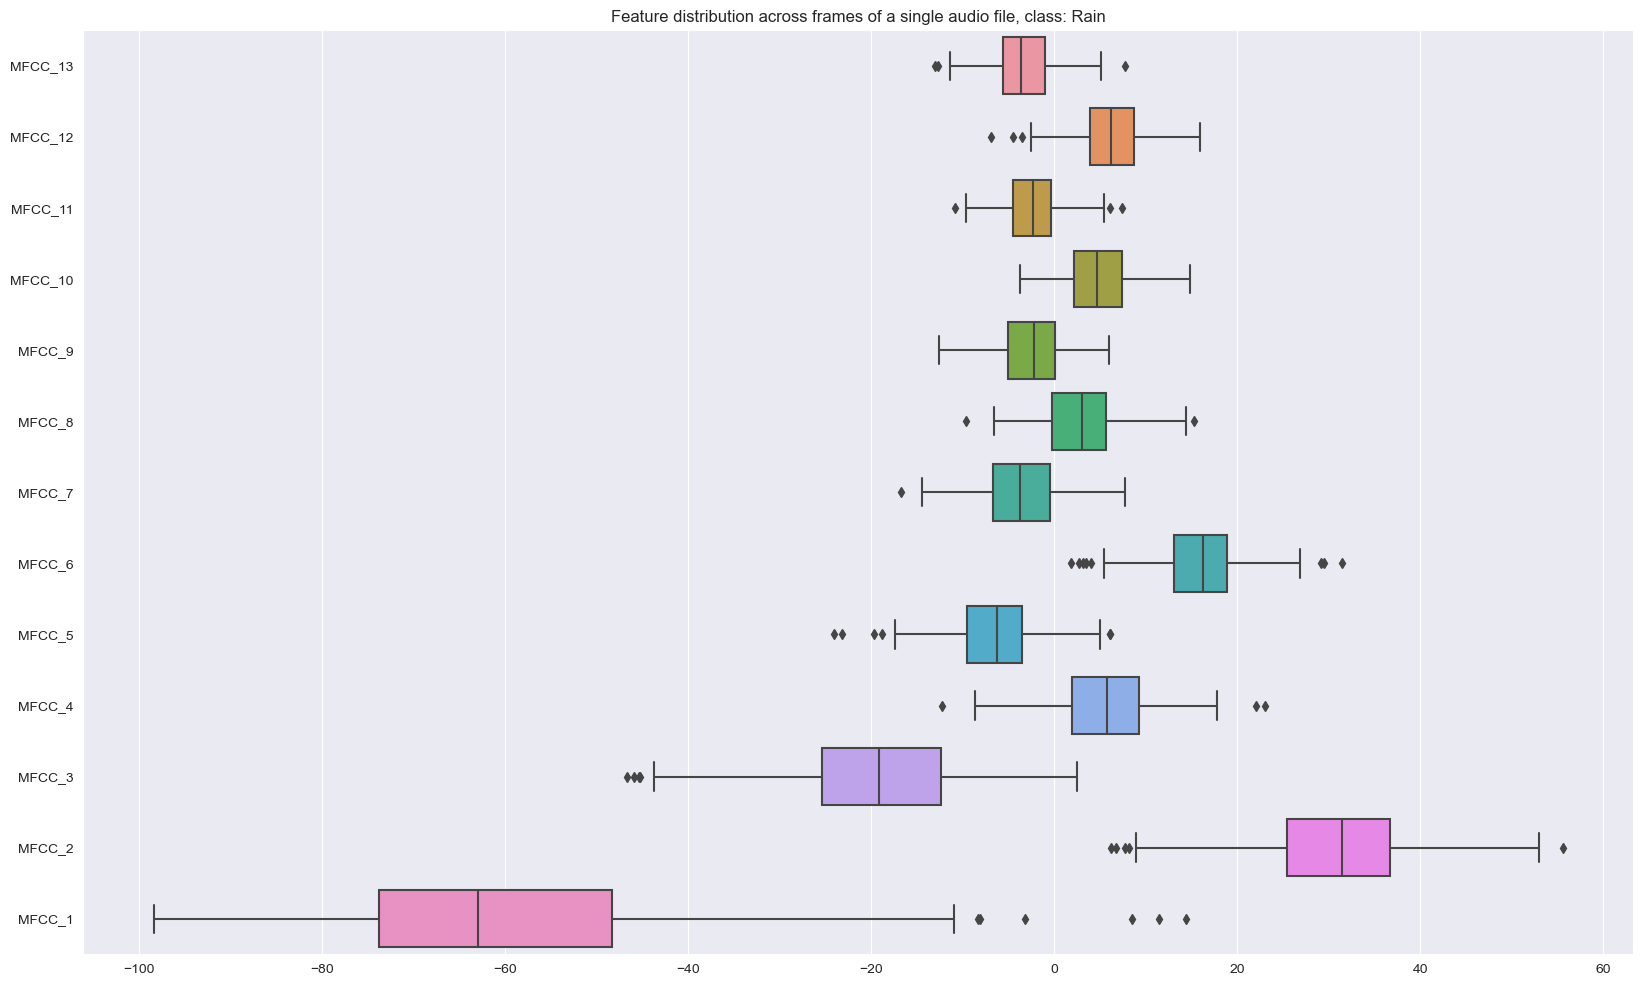

In [60]:
plot_MFCC_features(MFCC_parser, 50, MFCC_columns)

In [61]:
DB_ori_from_pkl['Class_categorical']

0            Dog bark
1            Dog bark
2            Dog bark
3            Dog bark
4            Dog bark
            ...      
395    Fire crackling
396    Fire crackling
397    Fire crackling
398    Fire crackling
399    Fire crackling
Name: Class_categorical, Length: 400, dtype: object

In [62]:
dfTONNETZ   = DB_ori_from_pkl.filter(regex=r'^TONNETZ_\d', axis=1)
dfMEL       = DB_ori_from_pkl.filter(regex=r'^MEL_\d', axis=1)
dfCONSTRAST = DB_ori_from_pkl.filter(regex=r'^CONTRAST_\d', axis=1)
dfCHROMA    = DB_ori_from_pkl.filter(regex=r'^CHROMA_\d', axis=1)
dfMFCC      = DB_ori_from_pkl.filter(regex=r'^MFCC_\d', axis=1)

In [63]:
dfTONNETZ.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfMEL.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfCONSTRAST.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfCHROMA.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfMFCC.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])

In [64]:
def plot_features(db: pd.DataFrame, lin:int):
    
    sample   = str(db.at[lin, 'Class_categorical'])
    dfSample = db.drop(columns=['Class_categorical'])
    
    f = plt.figure(figsize=(20, 12))
    sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])), orient = "h", order=list(reversed(dfSample.columns)))
    plt.title(f'Feature distribution across frames of a single audio file, class: {sample}')
    plt.savefig(path_pic + '02_PreProcessing_modeling_02.png')

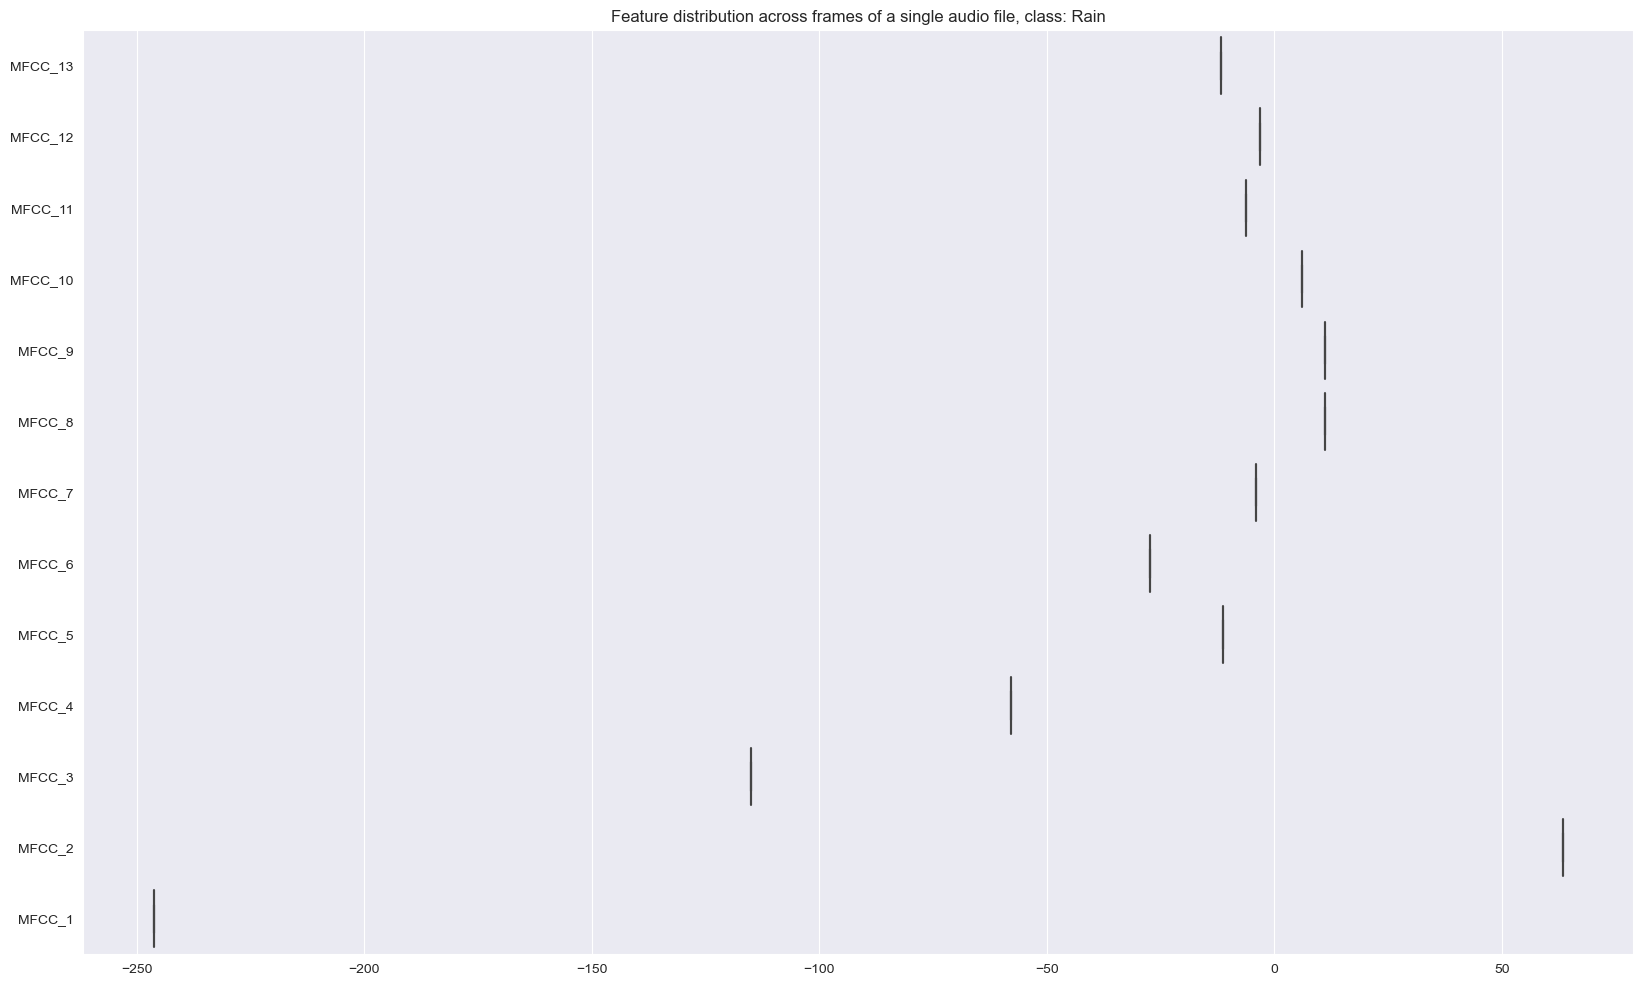

In [65]:
plot_features(dfMFCC, 50)

In [66]:
audio_samples = DB_ori_from_pkl.groupby('Class_categorical')['Audio'].apply(lambda s: s.sample(1))
sampled_indices = np.array(audio_samples.index)
sampled_indices

# Convert the resulting Series to a DataFrame and reset the index
#temp_sample_df = audio_samples.reset_index()

# Convert the DataFrame to a NumPy array
#plot_samples   = temp_sample_df[['Class_categorical', 'Audio']].values
#plot_samples

array([('Baby cry', 159), ('Chainsaw', 286), ('Clock tick', 175),
       ('Dog bark', 21), ('Fire crackling', 386), ('Helicopter', 263),
       ('Person sneeze', 207), ('Rain', 56), ('Rooster', 321),
       ('Sea waves', 110)], dtype=object)

In [67]:
DB_ori_from_pkl.at[120,'Class_categorical']

'Baby cry'

In [68]:
sampled_indices.shape[0]

10

In [69]:
# Plot the MFCC features of each class sample
    
def plot_MFCC_audio_sample(data: list):
    fig, axes = plt.subplots(int(np.ceil(np.shape(data)[0] / 2)), 2, 
                             figsize=(20, (np.ceil(data.shape[0] / 2))*6),
                            layout='constrained')
    fig.suptitle('ESC10 - MFCC features for each class sample', fontsize = 14)
    fig.subplots_adjust(top=0.9, hspace=0.1)

    for i, ax in enumerate(axes.flatten()):
        if i < np.shape(data)[0]:
            
            dfSample = pd.DataFrame(DB_ori_from_pkl[data[i][1]:data[i][1]+1]).apply(MFCC_parser, axis = 1)
            sample   = data[i][0]

            img = sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])),
                              ax     = ax,
                              orient = "h", 
                              order  = list(reversed(MFCC_columns)))
            ax.set_title(f'Sample {i+1}, class {sample}') 

        else:
            ax.axis('off') 
            
    fig.tight_layout(pad = 2.0)
    fig.savefig(path_pic + '02_PreProcessing_modeling_03.png')
    plt.show()

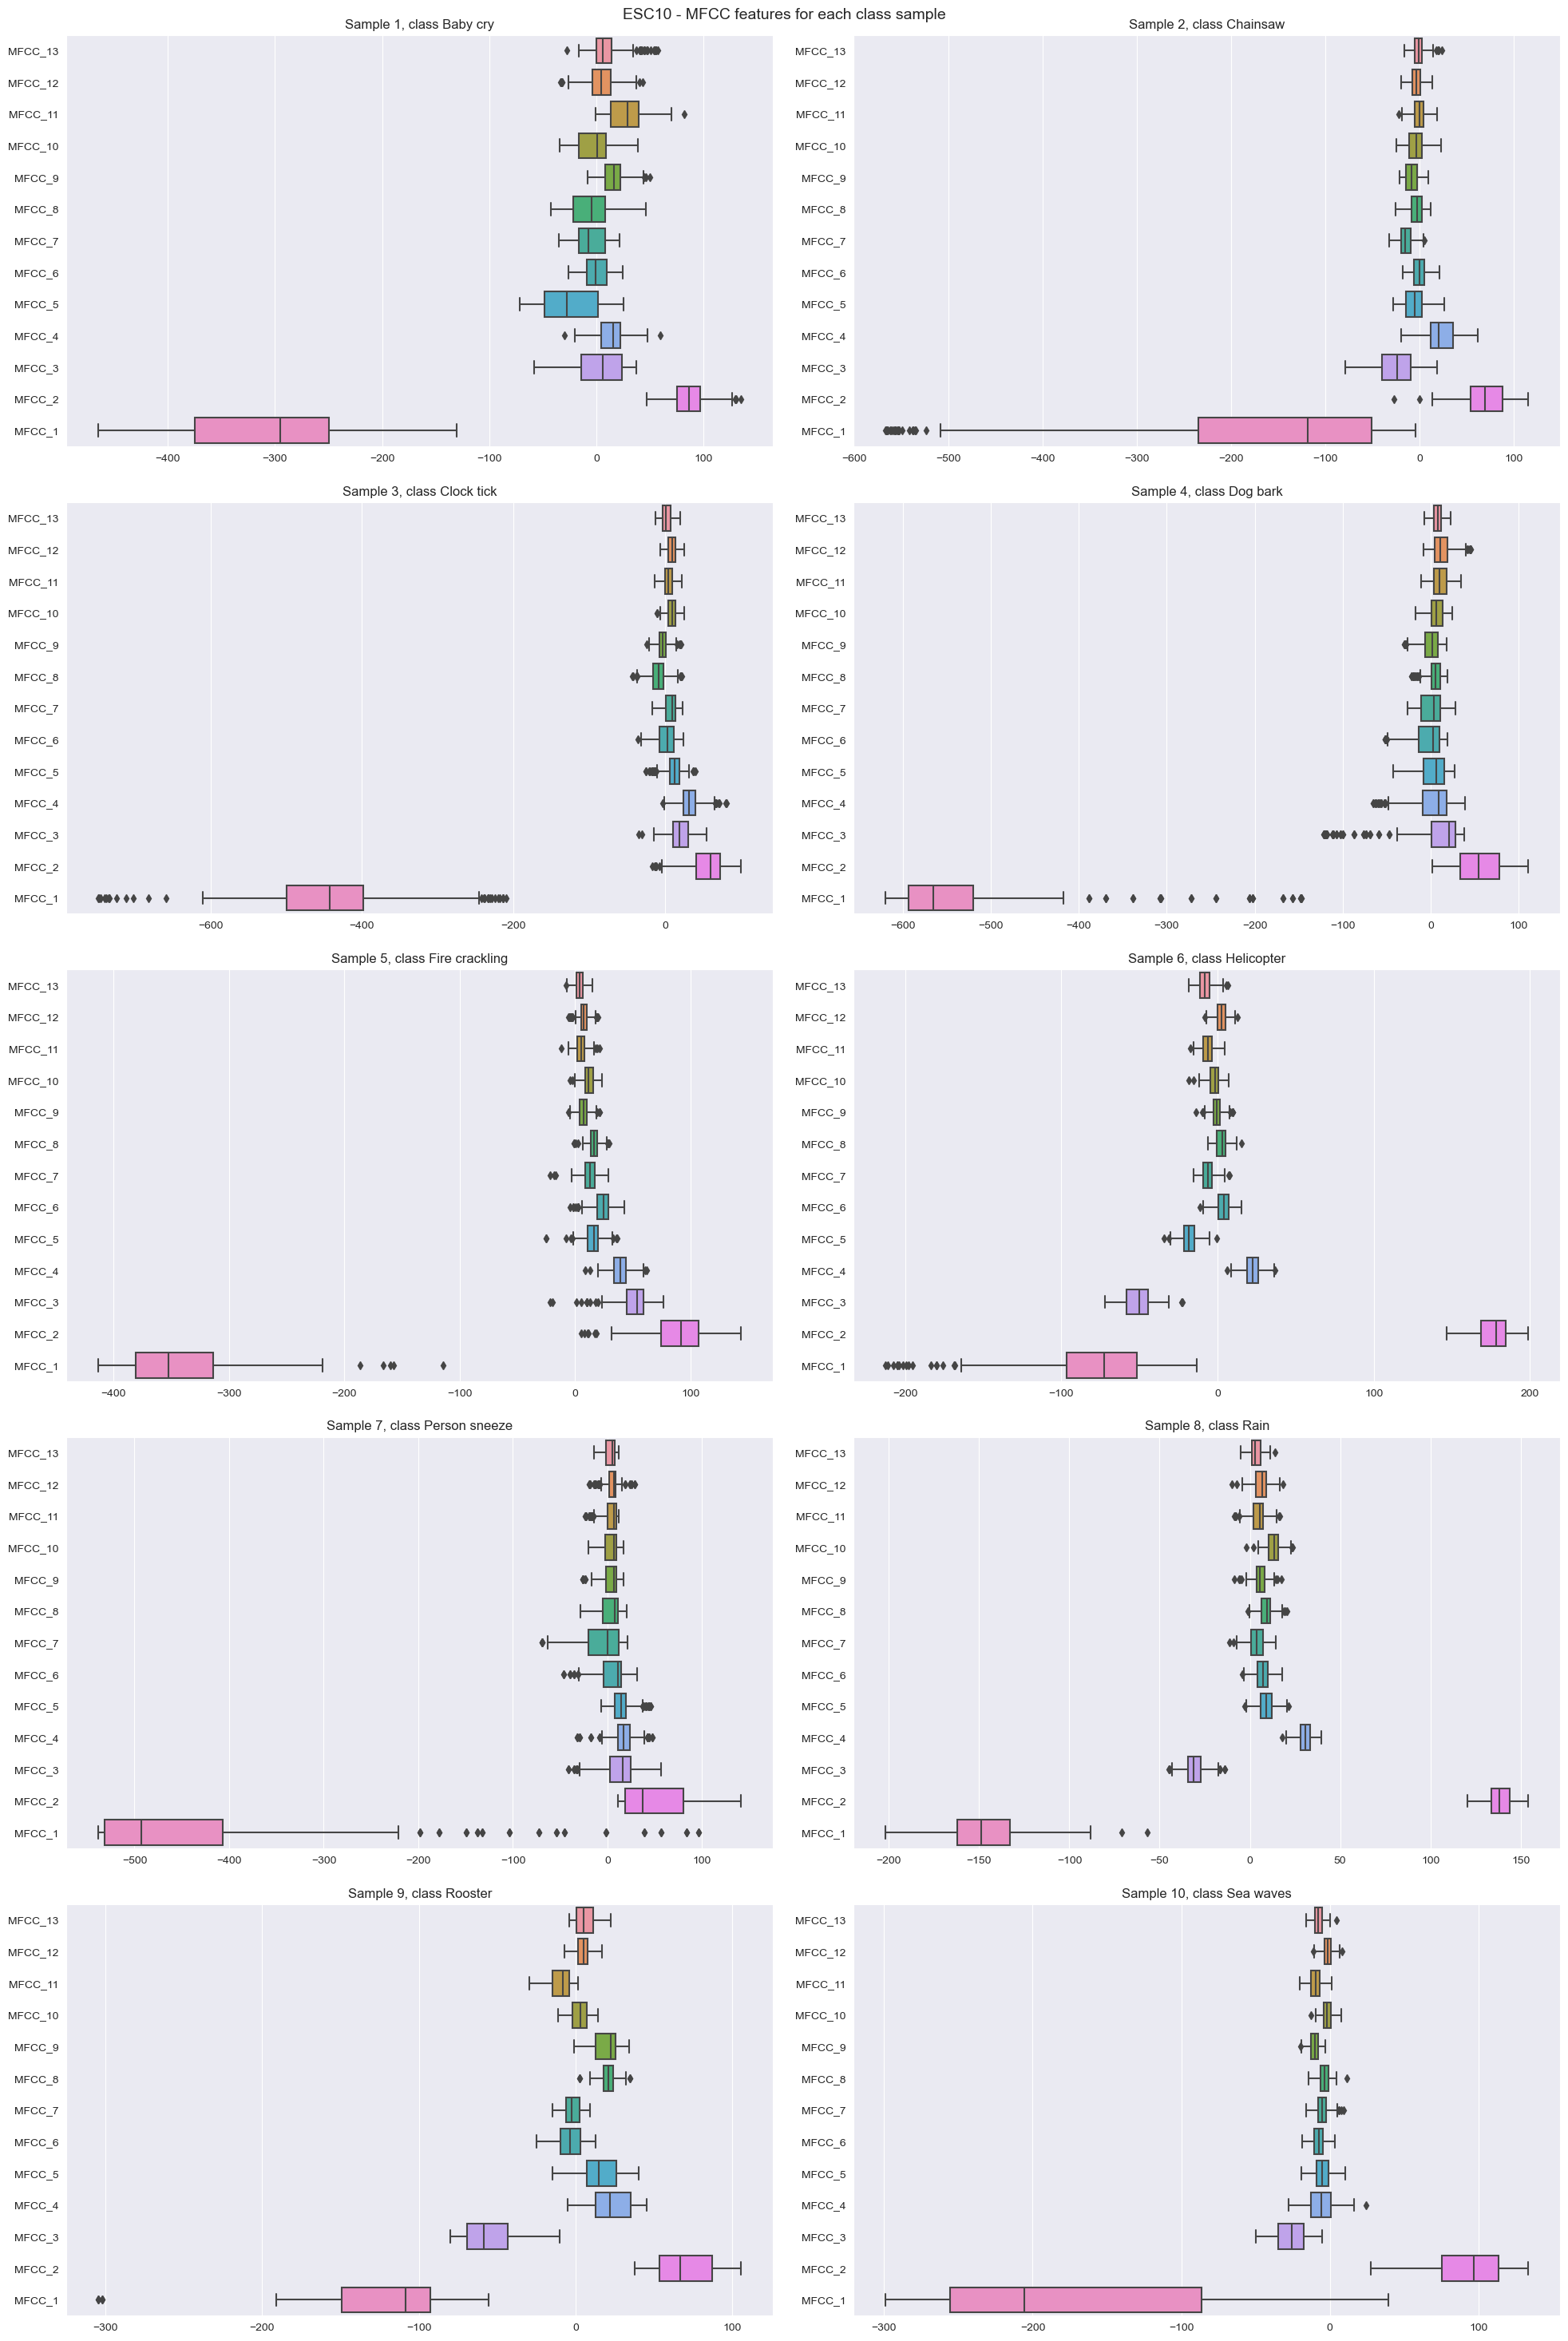

In [70]:
plot_MFCC_audio_sample(sampled_indices)

In [71]:
# Group by the class and get one random sample of each class
k = DB_ori_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical     
Baby cry           154    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Chainsaw           287    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Clock tick         190    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Dog bark           25     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Fire crackling     375    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Helicopter         261    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Person sneeze      231    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Rain               40     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Rooster            323    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Sea waves          103    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'Baby cry': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'Chainsaw': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'Clock tick': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'Dog bark': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'Fire crackling': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Helicopter': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'Person sneeze': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Rain': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'Rooster': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'Sea waves': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [72]:
nom_classes = list(encoder_dict.keys())
nom_classes

['Baby cry',
 'Chainsaw',
 'Clock tick',
 'Dog bark',
 'Fire crackling',
 'Helicopter',
 'Person sneeze',
 'Rain',
 'Rooster',
 'Sea waves']

In [73]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_ori_from_pkl_VAL = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == '1'].copy()
DB_ori_from_pkl_TRN = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != '1'].copy()

In [74]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_aug_from_pkl_VAL = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] == '1'].copy()
DB_aug_from_pkl_TRN = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] != '1'].copy()

In [75]:
print(len(DB_ori_from_pkl_VAL))
print(len(DB_ori_from_pkl_TRN))
print('Total: ', len(DB_ori_from_pkl_VAL) + len(DB_ori_from_pkl_TRN),'\n')
print(len(DB_aug_from_pkl_VAL))
print(len(DB_aug_from_pkl_TRN))
print('Total: ', len(DB_aug_from_pkl_VAL) + len(DB_aug_from_pkl_TRN))

80
320
Total:  400 

480
1920
Total:  2400


In [76]:
DB_aug_from_pkl_VAL

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-1.3767974e-05, 6.560702e-06, 1.5261583e-05, 2.7101487e-07, -3.189547e-06, 1.5014208e-05, 5.1874667e-06, -9.778421e...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.025425,-0.026296,-0.531440,-0.343371
1,"[-1.7668120563030243e-05, -3.5698467399924994e-05, -1.931440783664584e-05, -7.863069185987115e-06, -8.70289659360423...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.026299,-0.041034,0.217015,-0.746104
2,"[-2.1720765e-05, 0.00010475286, 0.00019316572, 0.00025172875, 0.00036776988, 0.00046772615, 0.000561155, 0.000610138...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.032917,-0.017070,0.071701,-0.411484
3,"[-1.8694685e-06, 3.5647074e-07, 5.222207e-06, 4.6744094e-06, 1.8501424e-06, -8.5931987e-07, 2.5762956e-06, 3.946978e...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.028921,0.012236,0.045008,-0.453769
4,"[-4.3592587e-05, -2.0006839e-05, 1.751376e-05, 5.3520853e-05, 7.4054966e-05, 7.835751e-05, 7.61583e-05, 7.352675e-05...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,...,0.027995,0.032727,0.185548,-0.502361
...,...,...,...,...,...,...,...,...,...
2203,"[0.0003769883365002053, 0.0003170456892282658, -4.272055353910355e-05, 0.0006253956455134354, 0.0005284930884317325,...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,...,0.015548,-0.002820,-0.218632,-0.381262
2204,"[-0.0013116507, -0.0015310799, -0.00054994994, -0.0009061195, -0.0008560954, -0.0008854511, 5.960758e-05, 0.00029548...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,...,0.020501,-0.005630,0.075972,-0.698728
2205,"[-0.0015040963, -0.0017363488, -0.00076575443, -0.0011193265, -0.0010832796, -0.0011122817, -0.00016541542, 8.860299...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,...,0.020814,-0.005103,0.100383,0.490886
2206,"[-0.0012652439, -0.0012395649, -0.00062653236, -0.00096401665, -0.0007820114, 0.000261379, -0.00013523262, -0.000292...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,...,0.027315,0.007609,0.574197,0.395671


In [77]:
DB_aug_from_pkl_TRN

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
48,"[6.6901324e-05, 8.944953e-05, 0.00012287633, 0.0001384059, 0.0001756732, 0.00019694935, 0.0002048823, 0.00023043892,...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.056482,-0.002760,-0.192161,0.209530
49,"[-0.0009772591871363013, -0.00037062158350580066, -0.00045193049454493876, -7.851653217275415e-05, 0.000948143497769...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.052542,-0.004554,-0.391135,0.813421
50,"[-0.0003105345, -0.00026080772, -0.0002233017, -0.00018363673, -0.00012975076, -8.498705e-05, -7.691754e-05, -8.8684...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.069800,-0.011981,-0.012699,-0.342240
51,"[-0.00022772413, 5.6968027e-05, 0.00023915111, 0.00031576998, 0.00035234835, 0.0004186409, 0.00047204577, 0.00050846...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.056109,-0.014598,0.126850,-0.112085
52,"[0.0005390488, 0.00025230355, -4.8467336e-07, -0.00015478054, -0.00020427472, -0.0001504775, -9.461341e-05, -7.67712...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.055287,-0.001741,-0.510315,0.928293
...,...,...,...,...,...,...,...,...,...
2395,"[-0.17522355914115906, -0.18252068758010864, -0.18808652460575104, -0.19727374613285065, -0.20042969286441803, -0.20...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.021181,0.005403,0.251889,-0.646567
2396,"[0.052693825, 0.08963939, 0.077772535, 0.07330648, 0.07560171, 0.07816128, 0.07244203, 0.07893729, 0.07996931, 0.079...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.025976,0.015526,-0.302515,-0.278720
2397,"[0.05291145, 0.08921811, 0.07753514, 0.073034376, 0.07519554, 0.07751592, 0.07197734, 0.0785395, 0.079810016, 0.0798...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.024113,0.016474,0.052828,-0.731086
2398,"[0.049761876, 0.09019045, 0.07195007, 0.07658597, 0.07598646, 0.0745673, 0.08006861, 0.07910959, 0.0769081, 0.077690...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.030500,-0.004993,0.165909,-0.545296


In [78]:
for i in DB_aug_from_pkl_TRN.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [79]:
DB_ori_from_pkl_TRN

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
8,"[6.6901324e-05, 8.944953e-05, 0.00012287633, 0.0001384059, 0.0001756732, 0.00019694935, 0.0002048823, 0.00023043892,...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.056482,-0.002760,-0.192161,0.209530
9,"[0.0026374813, 0.0008704532, -0.0011712611, -0.0031065568, -0.006483536, -0.00801089, -0.007848746, -0.0035639796, -...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.056589,0.011759,0.803490,1.440810
10,"[0.006360956, 0.009714635, 0.0085336445, 0.009390906, 0.008911347, 0.0094294, 0.0089620985, 0.009356469, 0.009112045...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.035096,0.020537,-0.596130,0.936901
11,"[0.0023090122, 0.0040737, 0.0038683806, 0.0031179506, 5.2724034e-05, -0.0025134506, -0.0053016436, -0.0063666925, -0...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.026860,0.001655,-0.250761,-0.162534
12,"[-0.0008497215, 3.9887615e-05, -0.0007774434, -0.0006252858, -0.00039462838, -0.00069172215, -0.00019421708, -0.0006...",Dog bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2,...,0.015768,0.003162,-1.803952,6.762626
...,...,...,...,...,...,...,...,...,...
395,"[8.755894e-05, 6.688332e-05, 6.425771e-05, 9.546602e-05, 6.53247e-05, 5.9457394e-05, 2.2577256e-05, 4.647161e-05, 6....",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.018624,0.002901,0.727124,1.020775
396,"[-0.0011081514, -0.0015953752, -0.0010865985, -0.00022670862, -0.00089606555, 0.00047600298, -0.0018381721, -0.00146...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.017107,-0.002157,0.320365,-0.319131
397,"[0.038042173, 0.10589701, 0.030117664, 0.058622308, 0.09430585, 0.047644228, 0.08971812, 0.10753698, 0.083254755, 0....",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.022239,0.011849,0.357041,-0.529717
398,"[0.00012540631, 1.7224811e-06, 0.00029374193, 0.00030114595, 0.00011787936, 0.0002513323, 8.1106555e-05, 0.000109463...",Fire crackling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5,...,0.022723,0.002698,-0.270733,-0.590341


# Input split

In [80]:
# For the augmented dataset - the validation set

X    = DB_ori_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y    = np.array(DB_ori_from_pkl_TRN.Class_categorical.to_list())
#y = np.array(DB.Class_OHEV.to_list())

In [81]:
# For the augmented dataset (only validation set)

X_val = DB_ori_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val = np.array(DB_ori_from_pkl_VAL.Class_categorical.to_list())

In [82]:
X

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
8,0.118418,0.064498,1068.947287,1178.860017,...,0.056482,-0.002760,-0.192161,0.209530
9,0.072352,0.156408,2519.272558,1840.042904,...,0.056589,0.011759,0.803490,1.440810
10,0.044989,0.050067,1473.373512,1971.026596,...,0.035096,0.020537,-0.596130,0.936901
11,0.161648,0.047748,1112.114166,1582.428144,...,0.026860,0.001655,-0.250761,-0.162534
12,0.090348,0.040175,1374.910472,1939.398289,...,0.015768,0.003162,-1.803952,6.762626
...,...,...,...,...,...,...,...,...,...
395,0.006825,0.415722,5839.092503,3280.619024,...,0.018624,0.002901,0.727124,1.020775
396,0.005010,0.499032,6277.479349,3138.906596,...,0.017107,-0.002157,0.320365,-0.319131
397,0.162035,0.076448,2975.088841,3536.426031,...,0.022239,0.011849,0.357041,-0.529717
398,0.039752,0.023560,947.418952,1779.252355,...,0.022723,0.002698,-0.270733,-0.590341


In [83]:
X.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,320.000000,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000
mean,0.090872,0.129591,2441.648659,2305.097572,...,0.042732,0.000113,0.202849,0.300799
std,0.069478,0.081565,1012.849937,590.002028,...,0.032392,0.030342,0.579544,1.333620
min,0.001820,0.008672,264.376676,419.993724,...,0.011428,-0.137280,-2.340862,-1.604308
25%,0.040754,0.073103,1746.665346,1909.622988,...,0.019938,-0.013412,-0.101041,-0.470761
50%,0.078558,0.115309,2462.500968,2368.106792,...,0.029400,-0.000397,0.179018,-0.099957
75%,0.132408,0.177811,3010.635664,2734.917448,...,0.054239,0.011656,0.492254,0.810135
max,0.515376,0.499032,6277.479349,3536.426031,...,0.181588,0.148784,1.962621,7.363100


In [84]:
y

array(['Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea wav

In [85]:
X_norm = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [86]:
X_standard = X.apply(lambda x: (x - x.mean()) / x.std())

In [87]:
X_norm.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,320.000000,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000
mean,0.173402,0.246592,0.362088,0.604892,...,0.183969,0.480286,0.591082,0.212448
std,0.135287,0.166337,0.168440,0.189320,...,0.190360,0.106068,0.134669,0.148719
min,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000
25%,0.075813,0.131396,0.246510,0.477992,...,0.050013,0.433008,0.520467,0.126407
50%,0.149424,0.217467,0.365556,0.625110,...,0.105623,0.478504,0.585544,0.167758
75%,0.254282,0.344929,0.456712,0.742812,...,0.251594,0.520639,0.658331,0.269246
max,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000


In [88]:
X_standard.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,...,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02
mean,6.661338e-17,-2.220446e-17,1.554312e-16,1.332268e-16,...,7.771561e-17,-1.110223e-17,5.551115e-18,-5.551115e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.281729e+00,-1.482491e+00,-2.149649e+00,-3.195080e+00,...,-9.664301e-01,-4.528109e+00,-4.389158e+00,-1.428523e+00
25%,-7.213460e-01,-6.925485e-01,-6.861661e-01,-6.702936e-01,...,-7.037003e-01,-4.457319e-01,-5.243610e-01,-5.785459e-01
50%,-1.772333e-01,-1.750982e-01,2.058776e-02,1.067949e-01,...,-4.115680e-01,-1.679463e-02,-4.112008e-02,-3.005025e-01
75%,5.978422e-01,5.911901e-01,5.617683e-01,7.285058e-01,...,3.552454e-01,3.804489e-01,4.993659e-01,3.819197e-01
max,6.109941e+00,4.529417e+00,3.787166e+00,2.086990e+00,...,4.286781e+00,4.899840e+00,3.036476e+00,5.295587e+00


In [89]:
X_norm = X_norm.values

In [90]:
X_standard = X_standard.values

In [91]:
X_norm.shape

(320, 375)

In [92]:
X_standard.shape

(320, 375)

In [93]:
y.shape

(320,)

In [94]:
len(X_norm)

320

In [95]:
len(X_standard)

320

In [96]:
X_val

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,0.103638,0.158777,2072.899575,1727.487324,...,0.025425,-0.026296,-0.531440,-0.343371
1,0.063543,0.043172,1058.689859,1503.190760,...,0.022231,0.002372,-1.381150,2.071973
2,0.020487,0.050632,1254.119292,1668.790166,...,0.030027,-0.005855,-0.297478,-0.709419
3,0.045842,0.080978,1434.025176,1648.548001,...,0.053246,-0.022612,2.323998,7.256435
4,0.048631,0.090255,2050.852629,2328.213405,...,0.039181,-0.011024,-0.816034,3.927710
...,...,...,...,...,...,...,...,...,...
363,0.048231,0.026299,1754.477616,2660.652995,...,0.035610,-0.002205,0.494392,-0.822387
364,0.027958,0.027909,1708.679460,2648.062858,...,0.025726,-0.012576,0.731997,0.340925
365,0.071765,0.035640,1769.677523,2429.487716,...,0.023950,0.051979,-0.107592,-0.704138
366,0.072297,0.109289,3605.696863,3390.900328,...,0.023468,-0.008492,0.130716,-0.542586


In [97]:
X_val.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000
mean,0.080554,0.143191,2570.809676,2373.335734,...,0.038784,-0.002925,0.123339,0.086590
std,0.055255,0.082261,944.155766,596.467801,...,0.029894,0.037831,0.549287,1.165953
min,0.004121,0.022881,886.059434,971.881044,...,0.013830,-0.105639,-1.381150,-1.212815
25%,0.042545,0.087003,1904.416278,2057.998707,...,0.019337,-0.015378,-0.148332,-0.506626
50%,0.072104,0.134745,2521.181925,2402.923761,...,0.025814,-0.002446,0.128059,-0.211808
75%,0.105828,0.176876,3207.762950,2703.863940,...,0.048281,0.005186,0.354199,0.349774
max,0.269574,0.397407,4855.011791,3727.837359,...,0.167625,0.250290,2.323998,7.256435


In [98]:
y_val

array(['Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Baby cry', 'Baby cry', 'Baby cry', 'Baby cry',
       'Baby cry', 'Baby cry', 'Baby cry', 'Baby cry', 'Clock tick',
       'Clock tick', 'Clock tick', 'Clock tick', 'Clock tick',
       'Clock tick', 'Clock tick', 'Clock tick', 'Person sneeze',
       'Person sneeze', 'Person sneeze', 'Person sneeze', 'Person sneeze',
       'Person sneeze', 'Person sneeze', 'Person sneeze', 'Helicopter',
       'Helicopter', 'Helicopter', 'Helicopter', 'Helicopter',
       'Helicopter', 'Helicopter', 'Helicopter', 'Chainsaw', 'Chainsaw',
       'Chainsaw', 'Chainsaw', 'Chainsaw', 'Chainsaw', 'Chainsaw',
       'Chainsaw', 'Rooster', 'Rooster', 'Rooster', 'Rooster', 'Rooster',
       'Rooster', 'Rooster', 'R

In [99]:
X_val_norm = X_val.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [100]:
X_val_standard = X_val.apply(lambda x: (x - x.mean()) / x.std())

In [101]:
X_val_norm.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000
mean,0.287935,0.321232,0.424482,0.508518,...,0.162252,0.288579,0.406054,0.153426
std,0.208155,0.219642,0.237885,0.216429,...,0.194378,0.106289,0.148250,0.137669
min,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000
25%,0.144750,0.171209,0.256581,0.394098,...,0.035810,0.253592,0.332731,0.083383
50%,0.256102,0.298682,0.411978,0.519254,...,0.077923,0.289925,0.407328,0.118193
75%,0.383146,0.411174,0.584966,0.628451,...,0.224009,0.311370,0.468362,0.184501
max,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000


In [102]:
X_val_standard.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,...,8.000000e+01,80.000000,8.000000e+01,8.000000e+01
mean,1.110223e-17,5.551115e-17,-2.220446e-17,3.330669e-17,...,-8.881784e-17,0.000000,3.330669e-17,1.110223e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
min,-1.383273e+00,-1.462525e+00,-1.784399e+00,-2.349590e+00,...,-8.347266e-01,-2.715042,-2.738985e+00,-1.114457e+00
25%,-6.878752e-01,-6.830348e-01,-7.058087e-01,-5.286740e-01,...,-6.505002e-01,-0.329170,-4.945882e-01,-5.087816e-01
50%,-1.529266e-01,-1.026667e-01,-5.256310e-02,4.960541e-02,...,-4.338438e-01,0.012662,8.594678e-03,-2.559263e-01
75%,4.574052e-01,4.094955e-01,6.746273e-01,5.541426e-01,...,3.177143e-01,0.214419,4.202920e-01,2.257246e-01
max,3.420848e+00,3.090340e+00,2.419306e+00,2.270871e+00,...,4.309891e+00,6.693262,4.006394e+00,6.149342e+00


In [103]:
X_val_norm = X_val_norm.values

In [104]:
X_val_standard = X_val_standard.values

In [105]:
X_val_norm.shape

(80, 375)

In [106]:
X_val_standard.shape

(80, 375)

In [107]:
y_val.shape

(80,)

In [108]:
len(y_val)

80

In [109]:
Counter_val = Counter(y_val)
Counter_val

Counter({'Dog bark': 8,
         'Rain': 8,
         'Sea waves': 8,
         'Baby cry': 8,
         'Clock tick': 8,
         'Person sneeze': 8,
         'Helicopter': 8,
         'Chainsaw': 8,
         'Rooster': 8,
         'Fire crackling': 8})

## StratifiedKFold

It is used for performing stratified k-fold cross-validation. It divides your dataset into 'k' equal-sized folds while ensuring that each fold maintains the same class distribution as the original dataset. This technique is valuable when you have a limited amount of data, and you want to maximize the use of your data for training and testing by creating multiple train-test splits.

Key points about StratifiedKFold:

- It's typically used for model evaluation, especially when you have a small dataset.
- You specify the number of folds (n_splits), and it creates 'k' folds with each fold maintaining the class distribution.
- It's used in conjunction with cross-validation functions like cross_val_score or cross_validate to assess your model's performance.

## StratifiedShuffleSplit 

It is primarily used for creating random train-test splits while ensuring that the class distribution is maintained in both the training and testing sets. This is particularly useful when you have a relatively large dataset and want to create multiple random splits to evaluate your model's performance or perform hyperparameter tuning.

Key points about StratifiedShuffleSplit:

- It randomly shuffles the data and splits it into train and test sets, preserving the class distribution.
- You specify the number of splits (n_splits), the test set size or proportion (test_size), and can optionally set a random seed for reproducibility.
- It's commonly used for tasks like model evaluation, cross-validation, and hyperparameter tuning.

In [110]:
X_norm.shape

(320, 375)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.1, random_state=42, stratify=y)

In [112]:
Counter_train = Counter(y_train)
Counter_test  = Counter(y_test)

In [113]:
Counter_train

Counter({'Chainsaw': 29,
         'Person sneeze': 28,
         'Sea waves': 29,
         'Fire crackling': 29,
         'Dog bark': 28,
         'Baby cry': 29,
         'Helicopter': 29,
         'Rooster': 29,
         'Clock tick': 29,
         'Rain': 29})

In [114]:
Counter_test

Counter({'Rain': 3,
         'Clock tick': 3,
         'Baby cry': 3,
         'Chainsaw': 3,
         'Person sneeze': 4,
         'Dog bark': 4,
         'Helicopter': 3,
         'Rooster': 3,
         'Sea waves': 3,
         'Fire crackling': 3})

In [115]:
N_SPLITS  = 5
cmap_data = plt.cm.viridis
cmap_cv   = plt.cm.coolwarm
cmap_cm   = plt.cm.Blues

sss = StratifiedShuffleSplit(n_splits = N_SPLITS, test_size=0.1, random_state=100)
skf = StratifiedKFold(n_splits = N_SPLITS, random_state=None, shuffle=False)
kfd = KFold(N_SPLITS)

In [116]:
sss

StratifiedShuffleSplit(n_splits=5, random_state=100, test_size=0.1,
            train_size=None)

In [117]:
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [118]:
kfd

KFold(n_splits=5, random_state=None, shuffle=False)

In [119]:
# Creates the train / test split
for idx_trn, idx_tst in skf.split(X_norm, y):
    X_train = X_norm[idx_trn]
    X_test  = X_norm[idx_tst]
    y_train = y[idx_trn]
    y_test  = y[idx_tst]

In [120]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(256, 375)
(64, 375)
(256,)
(64,)


In [121]:
X_train

array([[0.22704126, 0.11384842, 0.13380291, ..., 0.47024432, 0.49929348,
        0.2022701 ],
       [0.13733945, 0.30128158, 0.37499707, ..., 0.52099825, 0.73065285,
        0.33957619],
       [0.08405957, 0.08441822, 0.2010604 , ..., 0.5516836 , 0.40542323,
        0.28338276],
       ...,
       [0.01219085, 0.13947999, 0.41153178, ..., 0.52340099, 0.46813008,
        0.14052549],
       [0.04770547, 0.09553753, 0.40463607, ..., 0.52366883, 0.35302225,
        0.24879386],
       [1.        , 0.02517057, 0.18399458, ..., 0.53335457, 0.52844408,
        0.18795563]])

In [122]:
y_train

array(['Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark', 'Dog bark',
       'Dog bark', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves', 'Sea waves',
       'Sea waves', 'Sea waves', 'Baby cry', 'Baby cry', 'Baby cry',
       'Baby cry', 'B

In [123]:
for i in y_test:
    print(i)

Dog bark
Dog bark
Dog bark
Dog bark
Dog bark
Dog bark
Rain
Rain
Rain
Rain
Rain
Rain
Sea waves
Sea waves
Sea waves
Sea waves
Sea waves
Sea waves
Sea waves
Baby cry
Baby cry
Baby cry
Baby cry
Baby cry
Baby cry
Clock tick
Clock tick
Clock tick
Clock tick
Clock tick
Clock tick
Clock tick
Person sneeze
Person sneeze
Person sneeze
Person sneeze
Person sneeze
Person sneeze
Helicopter
Helicopter
Helicopter
Helicopter
Helicopter
Helicopter
Chainsaw
Chainsaw
Chainsaw
Chainsaw
Chainsaw
Chainsaw
Chainsaw
Rooster
Rooster
Rooster
Rooster
Rooster
Rooster
Fire crackling
Fire crackling
Fire crackling
Fire crackling
Fire crackling
Fire crackling
Fire crackling


In [124]:
y_test[0]

'Dog bark'

In [125]:
list_counter_test = Counter(y_test)
list_counter_test

# For OHEV
#list_counter_test = Counter(map(tuple, y_test))
#list_counter_test

Counter({'Dog bark': 6,
         'Rain': 6,
         'Sea waves': 7,
         'Baby cry': 6,
         'Clock tick': 7,
         'Person sneeze': 6,
         'Helicopter': 6,
         'Chainsaw': 7,
         'Rooster': 6,
         'Fire crackling': 7})

In [126]:
list_counter_train = Counter(y_train)
list_counter_train

# For OHEV
#list_counter_train = Counter(map(tuple, y_train))
#list_counter_train

Counter({'Dog bark': 26,
         'Rain': 26,
         'Sea waves': 25,
         'Baby cry': 26,
         'Clock tick': 25,
         'Person sneeze': 26,
         'Helicopter': 26,
         'Chainsaw': 25,
         'Rooster': 26,
         'Fire crackling': 25})

### Mutual information

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

A quantity called mutual information measures the amount of information one can obtain from one random variable given another.

The mutual information between two random variables X and Y can be stated formally as follows:

\begin{aligned}
I(X ; Y) = H(X) – H(X | Y)
\end{aligned}

Where $I(X ; Y)$ is the mutual information for $X$ and $Y$, $H(X)$ is the entropy for $X$ and $H(X | Y)$ is the conditional entropy for $X$ given $Y$. The result has the units of bits. Since mutual information is a measure of dependence or “mutual dependence” between two random variables, the result measure is symmetrical, meaning that $I(X ; Y) = I(Y ; X)$.

\begin{aligned}
E=-\sum_i^C p_i \log _2 p_i
\end{aligned}

Where $p_i$ is the probability of randomly picking an element of class $i$ (i.e. the proportion of the dataset made up of class $i$).

In [127]:
# Compute the mutual information

mutual_info = mutual_info_classif(X_norm, y)
mutual_info

array([0.52407804, 0.37469539, 0.49362232, 0.53979787, 0.49051344,
       0.32574365, 0.43223503, 0.53410034, 0.44094393, 0.51814376,
       0.5340569 , 0.5231383 , 0.55120532, 0.52053375, 0.55264905,
       0.60203782, 0.52761262, 0.54635545, 0.48601125, 0.46983564,
       0.44487332, 0.49004845, 0.49995253, 0.45145924, 0.4646541 ,
       0.40525384, 0.42162937, 0.3817091 , 0.42194128, 0.41079665,
       0.4078585 , 0.48265081, 0.50493486, 0.49646897, 0.47858966,
       0.45634619, 0.40750782, 0.46367593, 0.44655948, 0.48308069,
       0.45813467, 0.49579679, 0.51437424, 0.47861144, 0.43266473,
       0.47364889, 0.4520726 , 0.43674959, 0.39766984, 0.49835942,
       0.43092596, 0.43252173, 0.39118228, 0.44441037, 0.45872149,
       0.53218078, 0.51017681, 0.55921048, 0.51373204, 0.47945603,
       0.42102019, 0.43926627, 0.3880208 , 0.40607213, 0.36036268,
       0.40556294, 0.37269777, 0.38689034, 0.40565308, 0.4385136 ,
       0.38250957, 0.40816863, 0.4234043 , 0.36057037, 0.31768

In [128]:
mutual_info       = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

CONSTRAST_std_5         0.792778
CONSTRAST_std_4         0.791658
MFCC_delta1_std_1       0.779489
MFCC_delta1_std_3       0.738196
MFCC_std_9              0.728673
                          ...   
MFCC_delta2_mean_7      0.041931
MFCC_delta2_mean_6      0.011457
MFCC_delta1_mean_13     0.000000
MFCC_delta2_mean_10     0.000000
CONSTRAST_kurtosis_2    0.000000
Length: 375, dtype: float64

In [129]:
threshold = np.mean(mutual_info.sort_values(ascending=False))
threshold

0.36619436650886256

In [130]:
count_mutual = sum(1 for element in mutual_info if element > threshold)
count_mutual

207

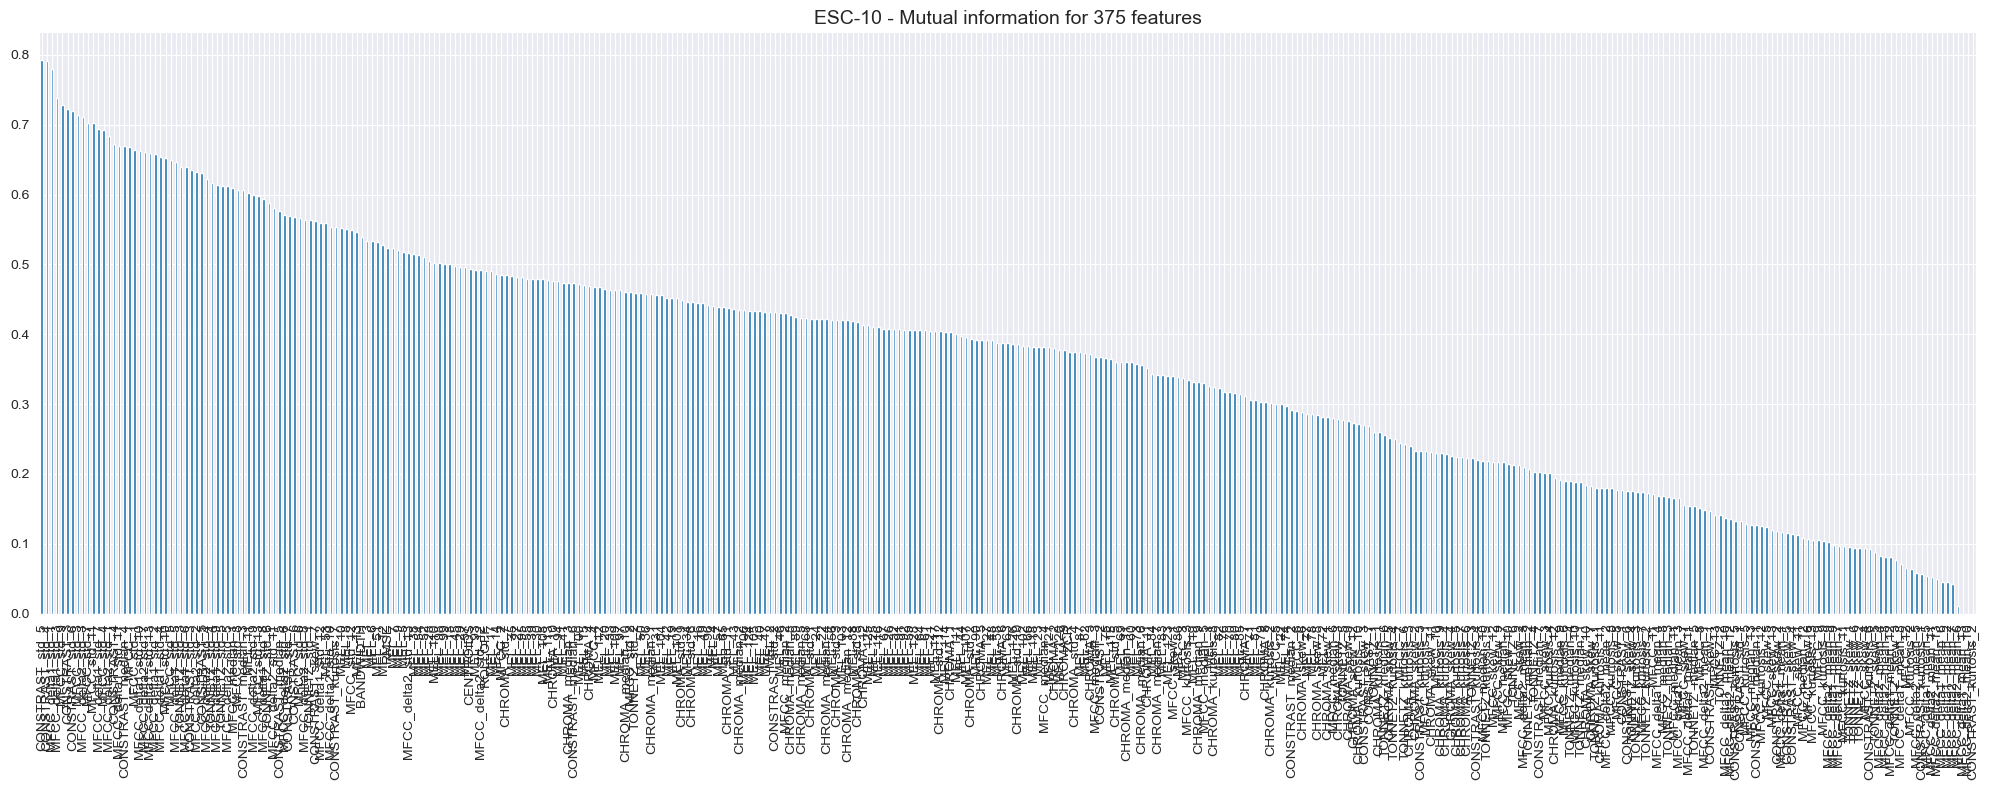

In [131]:
#Plot the sorted features based on their mutual information calculation

mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title(DATASET + ' - Mutual information for ' + str(len(mutual_info)) + ' features', fontsize = 14)
plt.tight_layout()
plt.savefig(path_pic + '02_PreProcessing_modeling_04.png')
plt.show()

### Backup for experiments using *n* relevant features

https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [132]:
chi2_selector = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
f = chi2_selector.get_support(1)
f

array([  0,   1,   2,   3,   4,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  64,  69,  70,  73,  79,  85,  87,  88,  89,  90,
        91,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 137, 139, 141, 142, 143, 144, 148, 150, 152, 157, 159,
       161, 166, 168, 170, 175, 177, 179, 184, 186, 188, 193, 195, 197,
       202, 204, 206, 211, 213, 215, 220, 222, 224, 229, 231, 233, 238,
       240, 242, 247, 249, 250, 252, 255, 256, 257, 260, 261, 262, 265,
       266, 267, 270, 271, 272, 275, 276, 277, 281, 283, 284, 285, 286,
       287, 289, 290, 292, 295, 297, 300, 301, 302, 305, 307, 31

In [133]:
X_new = X[X.columns[f]] # final features
X_new

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_3,TONNETZ_std_4,TONNETZ_std_5,TONNETZ_std_6
8,0.118418,0.064498,1068.947287,1178.860017,...,0.190216,0.138396,0.066795,0.056482
9,0.072352,0.156408,2519.272558,1840.042904,...,0.136899,0.152764,0.048932,0.056589
10,0.044989,0.050067,1473.373512,1971.026596,...,0.079495,0.077849,0.030479,0.035096
11,0.161648,0.047748,1112.114166,1582.428144,...,0.062463,0.095443,0.036109,0.026860
12,0.090348,0.040175,1374.910472,1939.398289,...,0.055676,0.029874,0.017447,0.015768
...,...,...,...,...,...,...,...,...,...
395,0.006825,0.415722,5839.092503,3280.619024,...,0.035172,0.039636,0.015857,0.018624
396,0.005010,0.499032,6277.479349,3138.906596,...,0.038335,0.035118,0.015686,0.017107
397,0.162035,0.076448,2975.088841,3536.426031,...,0.038161,0.038038,0.020452,0.022239
398,0.039752,0.023560,947.418952,1779.252355,...,0.049541,0.042126,0.016705,0.022723


In [134]:
def get_mutual_info (X: pd.DataFrame, X_norm: list, y: list):
    
    mutual_info = mutual_info_classif(X_norm, y)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X.columns
    mutual_info.sort_values(ascending=False)
    
    threshold = np.mean(mutual_info.sort_values(ascending=False))
    print(f' Threshold: {threshold}')
    
    count_mutual = sum(1 for element in mutual_info if element > threshold)
    print(f' Count mutual: {count_mutual}')
    
    chi2_selector = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
    f = chi2_selector.get_support(1)
    
    X_mutual = X[X.columns[f]] # final features

    return X_mutual

In [135]:
X_test_mutual = get_mutual_info(X, X_norm, y)

 Threshold: 0.3661910317582956
 Count mutual: 207


In [136]:
mutual_info_k_best = mutual_info_classif(X_new, y)
mutual_info_k_best

array([0.52407804, 0.37458325, 0.49362232, 0.53979787, 0.49051344,
       0.44094393, 0.51814376, 0.5340569 , 0.5231383 , 0.55120532,
       0.52053375, 0.55264905, 0.60203782, 0.52761262, 0.54635545,
       0.48601125, 0.46983564, 0.44487332, 0.49004845, 0.49995253,
       0.45145924, 0.4646541 , 0.40525384, 0.42162937, 0.3817091 ,
       0.42194128, 0.41079665, 0.4078585 , 0.48265081, 0.50493486,
       0.49646897, 0.47858966, 0.45634619, 0.44655948, 0.48308069,
       0.45813467, 0.49579679, 0.51437424, 0.47861144, 0.43266473,
       0.47364889, 0.4520726 , 0.43674959, 0.39766984, 0.49835942,
       0.43092596, 0.44441037, 0.45872149, 0.53218078, 0.51017681,
       0.55921048, 0.51373204, 0.47945603, 0.42102019, 0.43926627,
       0.36036268, 0.4385136 , 0.38250957, 0.36057037, 0.36635937,
       0.3053915 , 0.34096692, 0.34267156, 0.31474465, 0.33906972,
       0.37453714, 0.40663333, 0.49204921, 0.4757652 , 0.48262537,
       0.44174194, 0.4632626 , 0.50213415, 0.50063393, 0.47186

In [137]:
mutual_info_k_best       = pd.Series(mutual_info_k_best)
mutual_info_k_best.index = X_new.columns
mutual_info_k_best.sort_values(ascending=False)

CONSTRAST_std_5       0.792778
CONSTRAST_std_4       0.791658
MFCC_delta1_std_1     0.779489
MFCC_delta1_std_3     0.738196
MFCC_std_9            0.728673
                        ...   
CHROMA_kurtosis_1     0.259852
MFCC_kurtosis_1       0.233012
TONNETZ_kurtosis_1    0.179659
CONSTRAST_1           0.176390
CONSTRAST_median_1    0.127036
Length: 207, dtype: float64

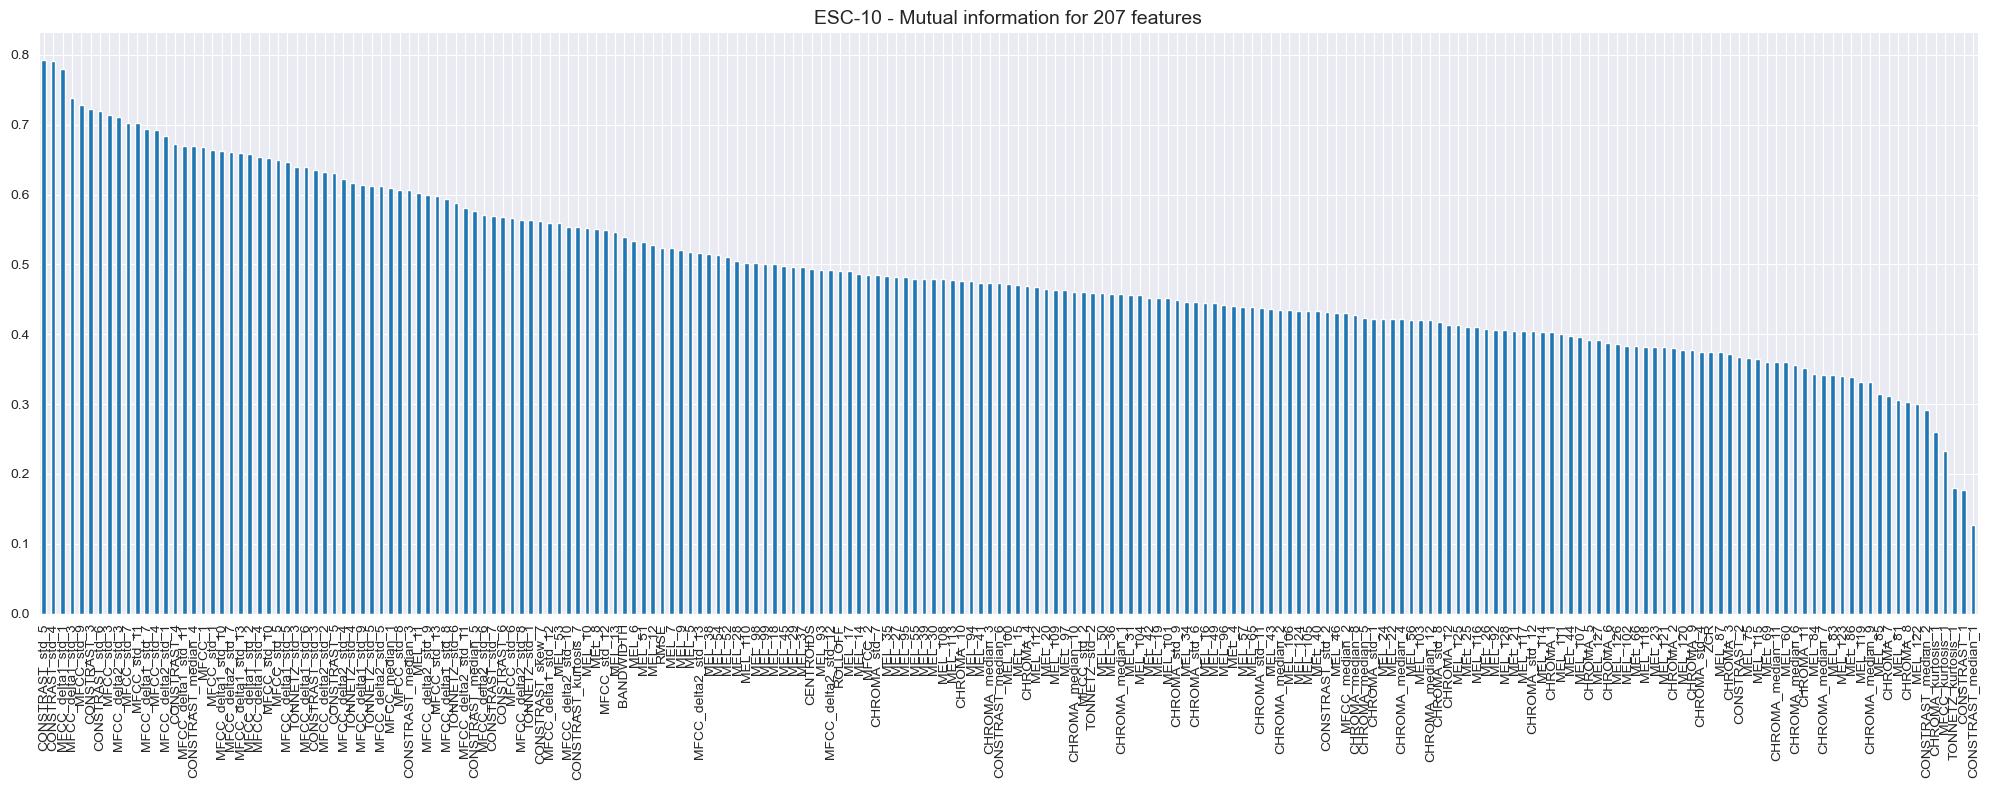

In [138]:
#Plot the sorted features based on their mutual information calculation

mutual_info_k_best.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title(DATASET + ' - Mutual information for ' + str(len(mutual_info_k_best)) + ' features', fontsize = 14)
plt.tight_layout()
plt.savefig(path_pic + '02_PreProcessing_modeling_05.png')
plt.show()

### Remark: by selection the features, re-nornamalize the dataframe

In [139]:
X_new.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_3,TONNETZ_std_4,TONNETZ_std_5,TONNETZ_std_6
count,320.000000,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000
mean,0.090872,0.129591,2441.648659,2305.097572,...,0.101642,0.102023,0.040951,0.042732
std,0.069478,0.081565,1012.849937,590.002028,...,0.079756,0.081721,0.030448,0.032392
min,0.001820,0.008672,264.376676,419.993724,...,0.028208,0.018004,0.010743,0.011428
25%,0.040754,0.073103,1746.665346,1909.622988,...,0.044115,0.043540,0.019601,0.019938
50%,0.078558,0.115309,2462.500968,2368.106792,...,0.065494,0.065545,0.029965,0.029400
75%,0.132408,0.177811,3010.635664,2734.917448,...,0.138502,0.141054,0.052597,0.054239
max,0.515376,0.499032,6277.479349,3536.426031,...,0.473409,0.472513,0.168422,0.181588


### Plotting the Pearson's correlation matrix

In [140]:
corr_matrix = X.corr(method='pearson')
print(corr_matrix)

                        RMSE       ZCR  CENTROIDS  BANDWIDTH  ...  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
RMSE                1.000000 -0.142587  -0.241176  -0.289672  ...       0.292537          0.085526        0.136530           -0.098917
ZCR                -0.142587  1.000000   0.890502   0.495372  ...      -0.016690          0.026869        0.047284           -0.054813
CENTROIDS          -0.241176  0.890502   1.000000   0.793788  ...      -0.027348          0.090963       -0.000352           -0.131190
BANDWIDTH          -0.289672  0.495372   0.793788   1.000000  ...      -0.177368          0.133832       -0.078660           -0.192767
ROLLOFF            -0.268286  0.742206   0.948398   0.920246  ...      -0.103065          0.096991       -0.030623           -0.171426
...                      ...       ...        ...        ...  ...            ...               ...             ...                 ...
TONNETZ_6           0.152142  0.024512   0.075766   0.1

In [141]:
#plt.figure(figsize=(40, 40))
#plt.title(DATASET + ' - Pearson\'s correlation heatmap of ESC-10', fontsize = 16)
#a = sns.heatmap(corr_matrix, 
#                square=True, 
#                annot=True, 
#                fmt='.1f', 
#                linecolor='black', 
#                cbar_kws={"shrink": .80},
#                annot_kws={"fontsize":6})
#a.set_xticklabels(a.get_xticklabels(), fontsize=7)
#a.set_yticklabels(a.get_yticklabels(), fontsize=7) 
#plt.tight_layout()
#plt.savefig(path_pic + '02_PreProcessing_modeling_06.png')
#plt.show()

In [142]:
# Método para visualizar a divisão do teste / treino por meio de K Fold e Stratified K Fold

def visualizar_Kfold(dataset, cv, X, y, n_splits):
    
    sns.set_style("darkgrid")
    
#    unique_lists = {}     # Dictionary to store unique lists and their corresponding sequential numbers
#    y_enc        = []       # Updated list
#
#    # Iterate over the original list
#    for sublist in y:
#        # Convert the sublist to a tuple to use it as a dictionary key
#        sublist_tuple = tuple(sublist)
#
#        # Check if the sublist is already in the dictionary
#        if sublist_tuple in unique_lists:
#            # If it is, append the corresponding sequential number to the updated list
#            y_enc.append(unique_lists[sublist_tuple])
#        else:
#            # If it is not, assign a new sequential number and add it to the dictionary
#            sequential_number = len(unique_lists)
#            unique_lists[sublist_tuple] = sequential_number
#            y_enc.append(sequential_number)

    label_encoder = preprocessing.LabelEncoder()
    y_enc = label_encoder.fit_transform(y)
    y_enc = np.sort(y_enc)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Cria a visualização do treino / test para cada divisão do CV
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y_enc)):
        
        # Preenche os índices com os valores do treino / teste
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualiza os resultados
        ax.scatter(range(len(indices)),
                   [ii + 0.5] * len(indices),
                   c=indices,
                   marker="_",
                   lw=25,
                   cmap=cmap_cv,
                   vmin=-0.2,
                   vmax=1.2)

    # Imprime a linha das classes no final
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y_enc, marker="_", lw=40, cmap=cmap_data)


    # Formatação
    yticklabels = list(range(n_splits)) + ["Classes"]
    ax.set(yticks=np.arange(n_splits + 1) + 0.5,
           yticklabels=yticklabels,
           ylim=[n_splits + 1.0, 0.0],
           xlim=[0, len(y_enc)])
    
    ax.set_xlabel('Samples', fontsize=12)
    ax.set_ylabel('CV iterations', fontsize=12)
    ax.set_title("{}".format(type(cv).__name__) + " " + dataset, fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(0.8)), 
               Patch(color=cmap_cv(0.02))],
              ["Validation set", "Training set"],
              loc=(1.02, 0.8))
    
    plt.tight_layout()
    plt.savefig(path_pic + '02_PreProcessing_modeling_07.png')
    plt.show()

StratifiedShuffleSplit(n_splits=5, random_state=100, test_size=0.1,
            train_size=None)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
KFold(n_splits=5, random_state=None, shuffle=False)



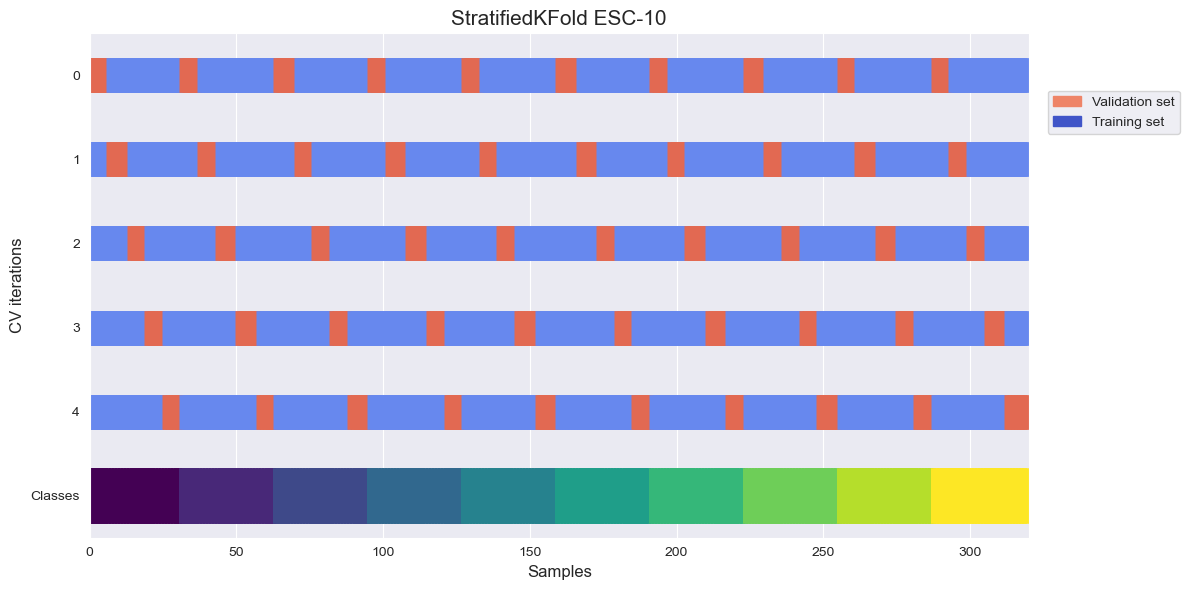

In [143]:
# Visualiza a divisão do treino / teste por meio do Stratified K Fold

print(sss)
print(skf)
print(kfd)
print()

visualizar_Kfold(nom_dataset, skf, X_norm, y, N_SPLITS)

## ML Modeling

In [144]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc, pic_name):

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = DATASET + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(path_pic + pic_name)
    plt.show()

In [145]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):
    
    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

In [146]:
#X    = DB_aug_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
#y    = np.array(DB_aug_from_pkl_TRN.Class_categorical.to_list())
#X_norm = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#X_norm = X_norm.values

#X_train, y_train, = X_norm, y

#X_val = DB_ori_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
#y_val = np.array(DB_ori_from_pkl_TRN.Class_categorical.to_list())
#X_val_norm = X_val.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#X_val_norm = X_val_norm.values

In [147]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_ori_from_pkl_VAL = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == '1'].copy()
DB_ori_from_pkl_TRN = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != '1'].copy()

DB_aug_from_pkl_VAL = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] == '1'].copy()
DB_aug_from_pkl_TRN = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] != '1'].copy()
y

X        = DB_aug_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y        = np.array(DB_aug_from_pkl_TRN.Class_categorical.to_list())


#X_norm   = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_norm   = X.apply(lambda x: (x - x.mean()) / x.std())
X_norm   = X_norm.values

X_train, y_train, = X_norm, y

X_val    = DB_ori_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val    = np.array(DB_ori_from_pkl_VAL.Class_categorical.to_list())

#X_val_norm = X_val.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_val_norm = X_val.apply(lambda x: (x - x.mean()) / x.std())
X_val_norm = X_val_norm.values

In [148]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_val_norm))
print(np.shape(y_val))

(1920, 375)
(1920,)
(80, 375)
(80,)


## Classifiers

- **Gaussian Naive Bayes** (GaussianNB) is a probabilistic machine learning algorithm mainly used for classification tasks based on the Naive Bayes theorem and assumes that features are independent and follow a Gaussian (normal) distribution. GaussianNB is particularly suitable for datasets with continuous or real-valued features. It calculates the probabilities of different classes for a given set of input features and assigns the class with the highest probability as the predicted class. Despite its simplifying assumption of feature independence (which is often not met in practice), GaussianNB performs surprisingly well in various real-world applications, such as text classification and spam email detection, due to its simplicity and efficiency. 
***
- The **Support Vector Classifier** (SVC)  is a supervised machine learning algorithm that is primarily used for classification tasksby finding the optimal hyperplane that best separates different classes in the input data. It does this by identifying support vectors, which are the data points closest to the decision boundary. SVC aims to maximize the margin between these support vectors and the decision boundary, making it robust to outliers and capable of handling non-linear data through the use of kernel functions. The algorithm allows for multi-class classification and can be fine-tuned through various parameters like the choice of kernel, regularization strength (C), and kernel-specific parameters. 
***
- **Logistic Regression** is a supervised machine learning algorithm that's primarily employed for binary classification tasks, though it can be extended to handle multiclass classification as well. Despite its name, it's used for classification, not regression. Logistic Regression models the probability of an instance belonging to a particular class as a logistic function of the input features. It's particularly well-suited for linearly separable data, where it tries to find a linear decision boundary that separates the two classes. Regularization techniques like L1 and L2 can be applied to prevent overfitting, while logistic regression assumes a linear relationship between features and the log-odds of the target variable, it can be effective in many practical scenarios and serves as a fundamental building block for more complex models in machine learning.
***
- The **k-Nearest Neighbors** (KNN) algorithm is a simple supervised machine learning technique used primarily for classification and regression tasks. In KNN, a data point's class or value is determined by the majority class or average of its k-nearest neighbors in the feature space. It operates under the assumption that similar data points tend to have similar class labels or target values. The choice of the "k" parameter determines how many neighboring data points are considered when making predictions; a smaller k value leads to more localized decision boundaries, while a larger k value results in smoother, global boundaries. KNN is a non-parametric algorithm, meaning it doesn't make assumptions about the underlying data distribution but it can be computationally expensive for large datasets and may require proper feature scaling and distance metric selection to perform optimally.
***
- **Random Forest** is an ensemble machine learning algorithm used for both classification and regression tasks. It's based on the concept of decision trees, but it builds multiple trees and combines their predictions to improve accuracy and reduce overfitting. In a Random Forest, a random subset of the training data and a random subset of the features are used to grow each tree. This randomness helps create diverse trees that collectively make more robust predictions. During classification, the algorithm aggregates the votes from individual trees, and for regression, it averages their predictions. Random Forest is known for its high accuracy, ability to handle large datasets with many features, and resistance to overfitting. 

In [149]:
# Plot the learning curve for the classifier

def plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std, classifier, path_pic, fn_pic):

    plt.figsize=(30, 30)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(DATASET + ' - Learning curve for ' + classifier)
    plt.xlabel('Training data size')
    plt.ylabel('Model accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(path_pic + fn_pic)
    plt.show()

In [150]:
NB_c = GaussianNB()
#NB_c = CategoricalNB()
NB_c

GaussianNB()

In [151]:
train_sizes, train_scores, test_scores = learning_curve(estimator = NB_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 153  307  460  614  768  921 1075 1228 1382 1536]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    6.2s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    6.3s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    6.5s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    6.6s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    6.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    6.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    6.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    7.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.2s finished


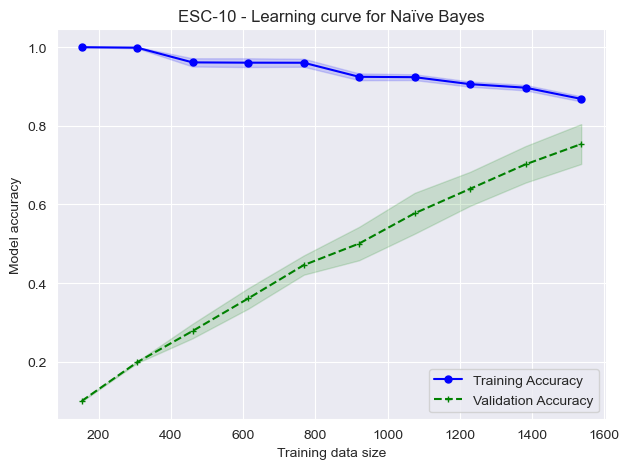

[ 153  307  460  614  768  921 1075 1228 1382 1536] samples were used to train the model

The average train accuracy is....: 94.01 % (+/-0.70 %)
The average test accuracy is.....: 45.57 % (+/-3.07 %)


In [152]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Naïve Bayes', 
                    path_pic, 
                    '02_PreProcessing_modeling_08.png')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [153]:
NB_c.fit(X_train, y_train)

GaussianNB()

In [154]:
NB_c_predict = NB_c.predict(X_val_norm)

In [155]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_GaussianNB.pkl"
with open(path_models + pkl_filename, 'wb') as file:
    pickle.dump(NB_c, file)

In [156]:
# Load the classifier from file

with open(path_models + pkl_filename, 'rb') as file:
    NB_c_saved = pickle.load(file)

In [157]:
score_NB_c_saved = NB_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_NB_c_saved))
NB_c_saved_predict = NB_c_saved.predict(X_val_norm)

Test score (R2): 40.00 %


In [158]:
t_srt = time.process_time_ns()

NB_c_saved_predict_val = NB_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 0,0000 ms


In [159]:
NBC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             NB_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(NBC_c_saved_val_class_report)

                precision    recall  f1-score   support

      Baby cry       0.00      0.00      0.00         8
      Chainsaw       0.37      0.88      0.52         8
    Clock tick       0.00      0.00      0.00         8
      Dog bark       0.57      0.50      0.53         8
Fire crackling       0.00      0.00      0.00         8
    Helicopter       0.67      0.25      0.36         8
 Person sneeze       0.22      1.00      0.36         8
          Rain       0.50      0.12      0.20         8
       Rooster       0.75      0.75      0.75         8
     Sea waves       1.00      0.50      0.67         8

      accuracy                           0.40        80
     macro avg       0.41      0.40      0.34        80
  weighted avg       0.41      0.40      0.34        80



In [160]:
NBC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             NB_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)

NBC_c_saved_val_class_report_acc = NBC_c_saved_val_class_report['accuracy']
print(NBC_c_saved_val_class_report_acc)

0.4


In [161]:
np.array_equal(NB_c_predict, NB_c_saved_predict)

True

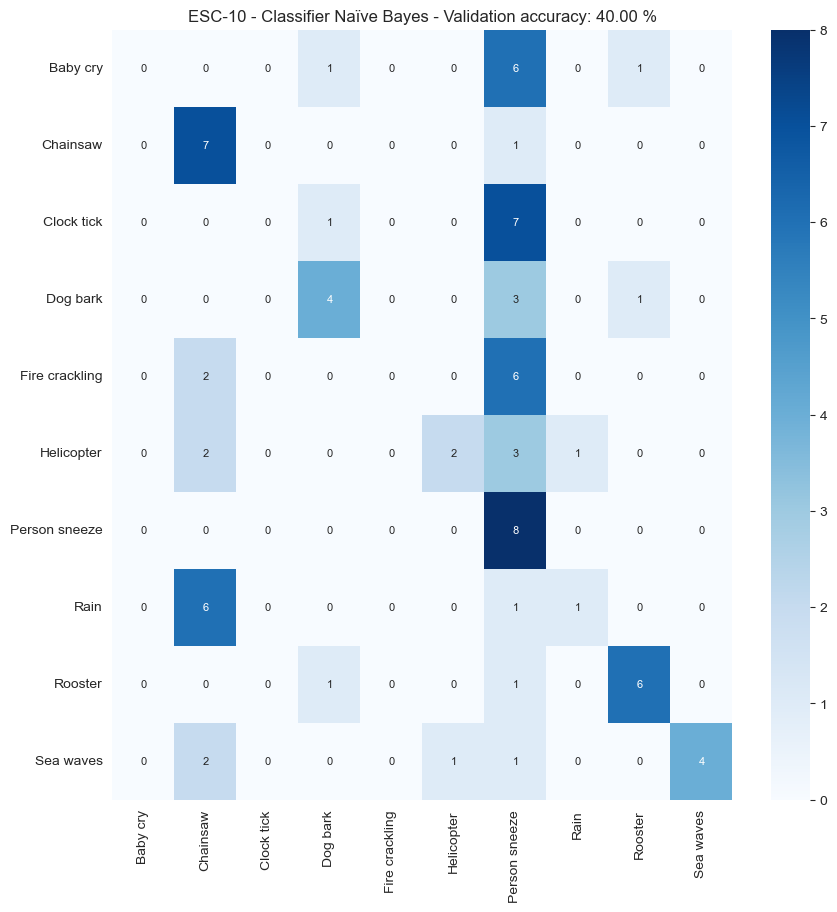

In [162]:
simple_conf_matrix(y_val, 
                   NB_c_saved_predict_val, 
                   nom_classes,
                   'Naïve Bayes',
                   NBC_c_saved_val_class_report_acc,
                   '02_PreProcessing_modeling_09.png')

In [163]:
import random

def get_random_sample(array1, array2):
    # Check if both arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Select a random index
    random_index = random.randint(0, len(array1) - 1)
    print(random_index)

    # Get the sample from the first array and the associated element from the second array
    sample = array1[random_index]
    associated_element = array2[random_index]

    # Return the result as a tuple
    return (sample, associated_element, random_index)

In [164]:
random_sample = get_random_sample(y_val, X_val_norm)

25


In [165]:
def plot_pred_sample(model, data_label, data, nom_classes):
    
    random_sample = get_random_sample(data_label, data)
    
    print(random_sample[0])
    predict_sample = model.predict([random_sample[1]])[0]

    predict_sample_proba = model.predict_proba([random_sample[1]])
    print(predict_sample)
    
    if random_sample[0] == predict_sample:
        predict_col = 'g'
    else:
        predict_col = 'r'

    # Plotting
    plt.figure(figsize = (16,6))
    plt.bar(nom_classes, predict_sample_proba[0], color = predict_col, alpha = 0.5)
    plt.xlabel('Classes')
    plt.xticks(rotation=90)
    plt.ylabel('Probabilities')
    plt.title(f'Prediction for sample: {random_sample[0]}', fontsize = 14)
    plt.show()
    return random_sample[2]

17
Sea waves
Sea waves


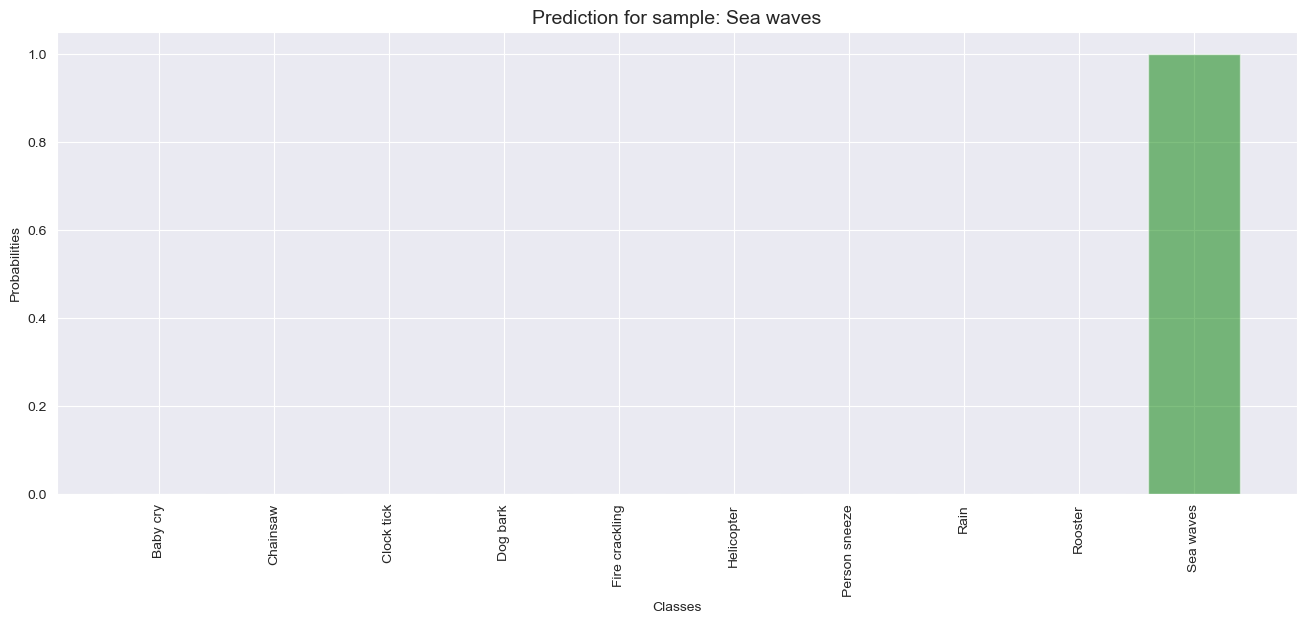

In [166]:
random_index = plot_pred_sample(NB_c_saved, y_val, X_val_norm, nom_classes)

In [167]:
print(y_val[random_index])
print(NB_c_saved.predict([X_val_norm[random_index]])[0])

Sea waves
Sea waves


In [168]:
# Testing hyperparameters for SVC classifier - After several test, the hyperparameters were set

#SVC_hp = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
#          'degree': [9, 15, 20],
#          'C':[0.010, 0.030, 0.1, 0.2, 0.5], 
#          'probability': [True, False],
#          'random_state': [SEED]}

#grid_SVC = GridSearchCV(SVC(), SVC_hp, refit = True, verbose=3)

#grid_SVC.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_SVC.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_SVC.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_SVC.best_params_)

In [169]:
#grid_SVC.best_params_

In [170]:
# degree = degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.

SVC_c = SVC(kernel       = 'linear',
            degree       = 9,  
            C            = 0.5, 
            probability  = True, 
            random_state = SEED,
            verbose      = True)
SVC_c

SVC(C=0.5, degree=9, kernel='linear', probability=True, random_state=1000,
    verbose=True)

In [171]:
train_sizes, train_scores, test_scores = learning_curve(estimator = SVC_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.2, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 307  443  580  716  853  989 1126 1262 1399 1536]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    0.3s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    0.8s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    1.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    1.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    2.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    2.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    2.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    3.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished


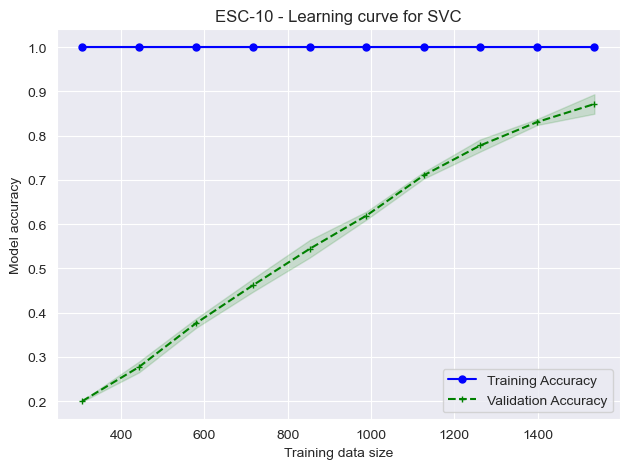

[ 307  443  580  716  853  989 1126 1262 1399 1536] samples were used to train the model

The average train accuracy is....: 100.00 % (+/-0.00 %)
The average test accuracy is.....: 56.68 % (+/-1.17 %)


In [172]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'SVC', 
                    path_pic,
                   '02_PreProcessing_modeling_10.png')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [173]:
SVC_c.fit(X_train, y_train)

[LibSVM]

SVC(C=0.5, degree=9, kernel='linear', probability=True, random_state=1000,
    verbose=True)

In [174]:
SVC_c_predict = SVC_c.predict(X_val_norm)

In [175]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_SVC.pkl"
with open(path_models + pkl_filename, 'wb') as file:
    pickle.dump(SVC_c, file)

In [176]:
# Load the classifier from file

with open(path_models + pkl_filename, 'rb') as file:
    SVC_c_saved = pickle.load(file)

In [177]:
score_SVC_c_saved = SVC_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_SVC_c_saved))
SVC_c_saved_predict = SVC_c_saved.predict(X_val_norm)

Test score (R2): 80.00 %


In [178]:
t_srt = time.process_time_ns()

SVC_c_saved_predict_val = SVC_c_saved.predict(X_val_norm)
2
t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 15,6250 ms


In [179]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(SVC_c_saved_val_class_report)

                precision    recall  f1-score   support

      Baby cry       0.75      0.75      0.75         8
      Chainsaw       0.73      1.00      0.84         8
    Clock tick       0.78      0.88      0.82         8
      Dog bark       0.89      1.00      0.94         8
Fire crackling       0.75      0.75      0.75         8
    Helicopter       1.00      0.50      0.67         8
 Person sneeze       1.00      0.88      0.93         8
          Rain       0.56      0.62      0.59         8
       Rooster       0.86      0.75      0.80         8
     Sea waves       0.88      0.88      0.88         8

      accuracy                           0.80        80
     macro avg       0.82      0.80      0.80        80
  weighted avg       0.82      0.80      0.80        80



In [180]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)
SVC_c_saved_val_class_report_acc = SVC_c_saved_val_class_report['accuracy']
SVC_c_saved_val_class_report_acc

0.8

In [181]:
np.array_equal(SVC_c_predict, SVC_c_saved_predict)

True

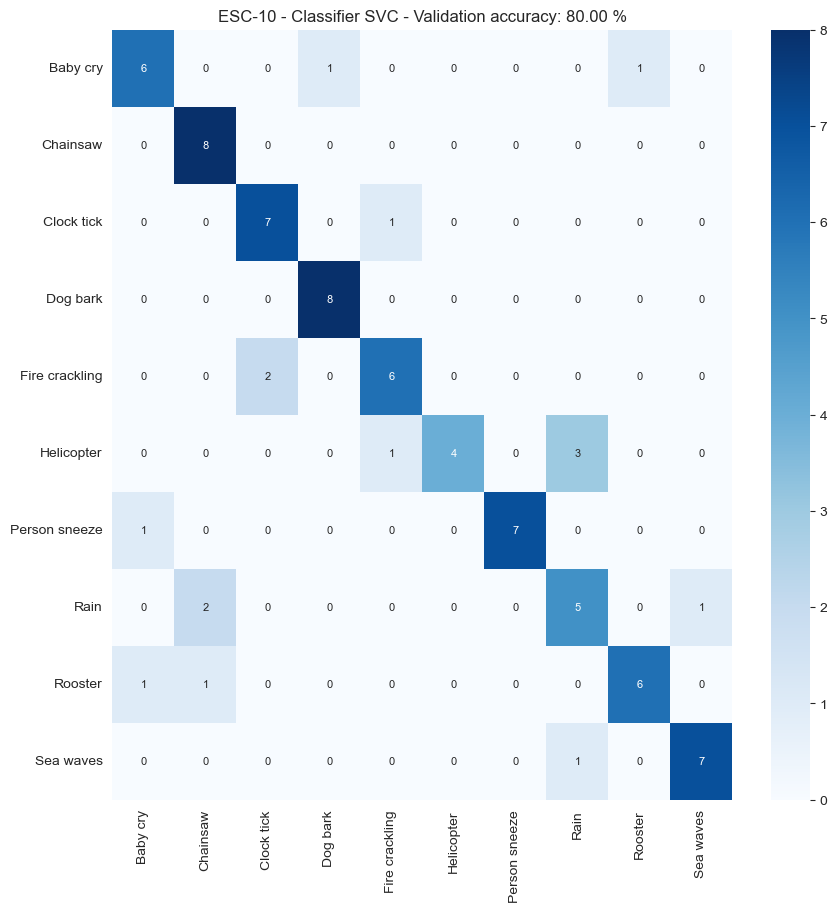

In [182]:
simple_conf_matrix(y_val, 
                   SVC_c_saved_predict_val, 
                   nom_classes,
                   'SVC',
                   SVC_c_saved_val_class_report_acc,
                   '02_PreProcessing_modeling_11.png')

74
Fire crackling
Fire crackling


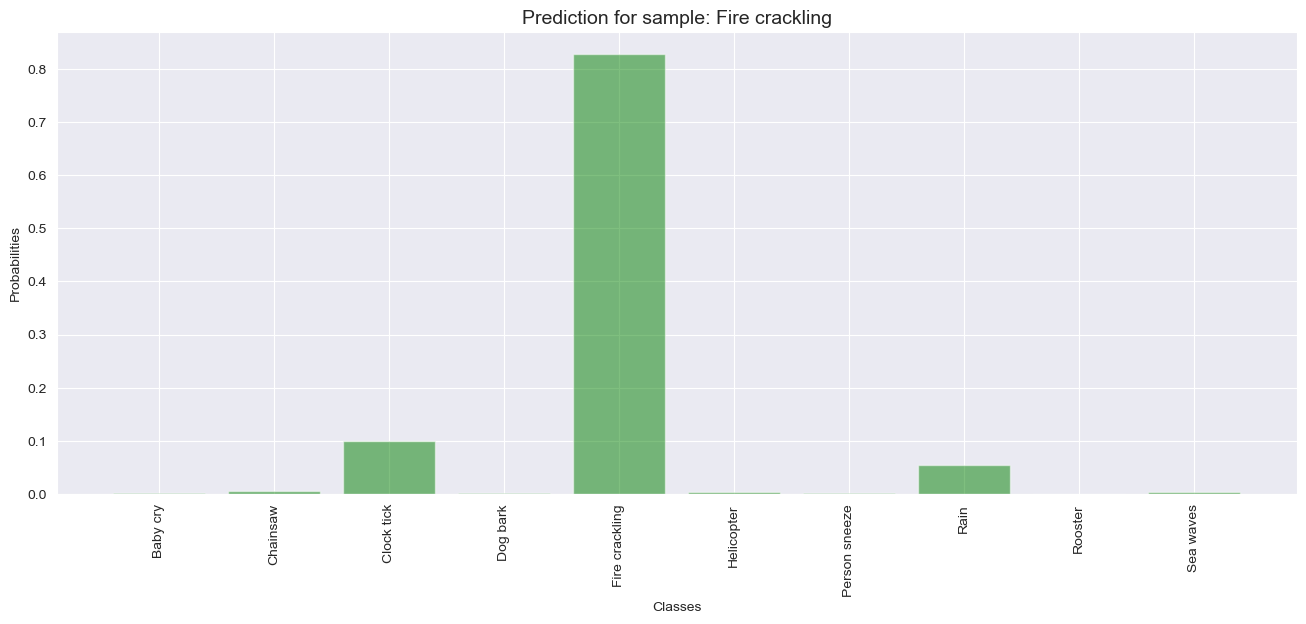

In [183]:
random_index = plot_pred_sample(SVC_c_saved, y_val, X_val_norm, nom_classes)

In [184]:
print(random_index)
print(y_val[random_index])
print(SVC_c_saved.predict([X_val_norm[random_index]])[0])

74
Fire crackling
Fire crackling


In [185]:
# Testing hyperparameters for Logistic Regression classifier - After several test, the hyperparameters were set

#LogisticR_hp = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
#                'penalty': ['l1', 'l2', 'elasticnet', None],
#                'max_iter':[100, 150, 200, 500],
#                'C':[0.010, 0.030, 0.1, 0.2, 0.5]}

#grid_LogisticR = GridSearchCV(LogisticRegression(), LogisticR_hp, refit = True, verbose=3)

#grid_LogisticR.fit(X_train, y_train)

#print(" Results from Grid Search in the Logistic Regression classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_LogisticR.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_LogisticR.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_LogisticR.best_params_)

In [186]:
#grid_LogisticR.best_params_

In [187]:
LogisticR_c = LogisticRegression(solver    = 'saga', 
                                 C         = 0.5, 
                                 max_iter  = 500,
                                 verbose   = 10,
                                 n_jobs    = -1)
LogisticR_c

LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga', verbose=10)

In [188]:
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticR_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.2, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 307  443  580  716  853  989 1126 1262 1399 1536]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    2.9s remaining:   46.8s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    8.9s remaining:   40.8s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   15.7s remaining:   36.7s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   21.3s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:   26.6s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   33.0s remaining:   17.0s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   38.9s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   46.8s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   55.4s finished


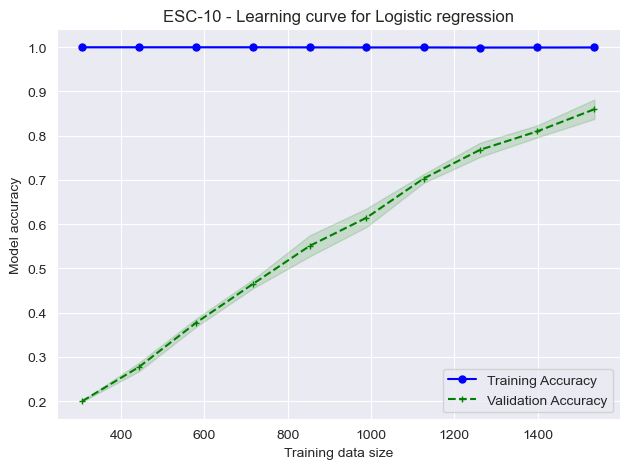

[ 307  443  580  716  853  989 1126 1262 1399 1536] samples were used to train the model

The average train accuracy is....: 99.97 % (+/-0.03 %)
The average test accuracy is.....: 56.26 % (+/-1.36 %)


In [189]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Logistic regression',
                    path_pic,
                   '02_PreProcessing_modeling_12.png')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [190]:
LogisticR_c.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 14 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.0s finished


LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga', verbose=10)

In [191]:
LogisticR_c_predict = LogisticR_c.predict(X_val_norm)

In [192]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_LogisticR.pkl"
with open(path_models + pkl_filename, 'wb') as file:
    pickle.dump(LogisticR_c, file)

In [193]:
# Load the classifier from file

with open(path_models + pkl_filename, 'rb') as file:
    LogisticR_c_saved = pickle.load(file)

In [194]:
score_LogisticR_c_saved = LogisticR_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_LogisticR_c_saved))
LogisticR_c_saved_predict = LogisticR_c_saved.predict(X_val_norm)

Test score (R2): 78.75 %


In [195]:
t_srt = time.process_time_ns()

LogisticR_c_saved_predict_val = LogisticR_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 0,0000 ms


In [196]:
LogisticR_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                   LogisticR_c_saved_predict_val, 
                                                                   target_names = nom_classes, 
                                                                   output_dict = False)
print(LogisticR_c_saved_val_class_report)

                precision    recall  f1-score   support

      Baby cry       0.86      0.75      0.80         8
      Chainsaw       0.88      0.88      0.88         8
    Clock tick       0.83      0.62      0.71         8
      Dog bark       0.73      1.00      0.84         8
Fire crackling       0.78      0.88      0.82         8
    Helicopter       0.60      0.38      0.46         8
 Person sneeze       0.86      0.75      0.80         8
          Rain       0.55      0.75      0.63         8
       Rooster       1.00      1.00      1.00         8
     Sea waves       0.88      0.88      0.88         8

      accuracy                           0.79        80
     macro avg       0.79      0.79      0.78        80
  weighted avg       0.79      0.79      0.78        80



In [197]:
LogisticR_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                   LogisticR_c_saved_predict_val, 
                                                                   target_names = nom_classes, 
                                                                   output_dict = True)
LogisticR_c_saved_val_class_report_acc = LogisticR_c_saved_val_class_report['accuracy']
LogisticR_c_saved_val_class_report_acc

0.7875

In [198]:
np.array_equal(LogisticR_c_predict, LogisticR_c_saved_predict)

True

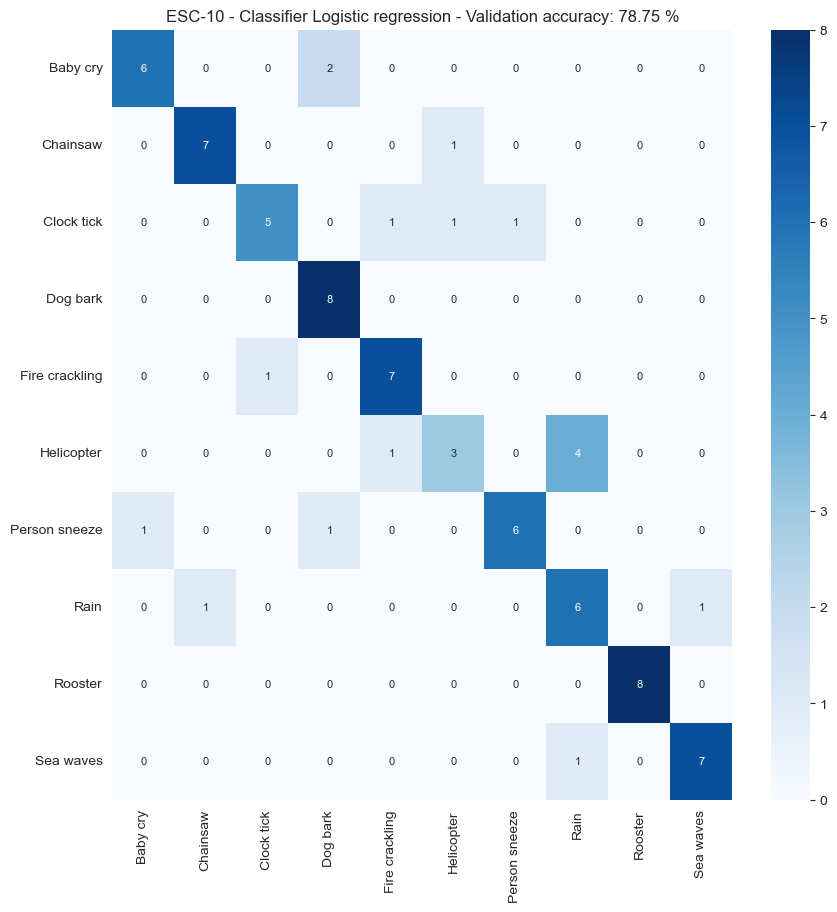

In [199]:
simple_conf_matrix(y_val, 
                   LogisticR_c_saved_predict_val, 
                   nom_classes,
                   'Logistic regression',
                   LogisticR_c_saved_val_class_report_acc,
                   '02_PreProcessing_modeling_13.png')

42
Person sneeze
Person sneeze


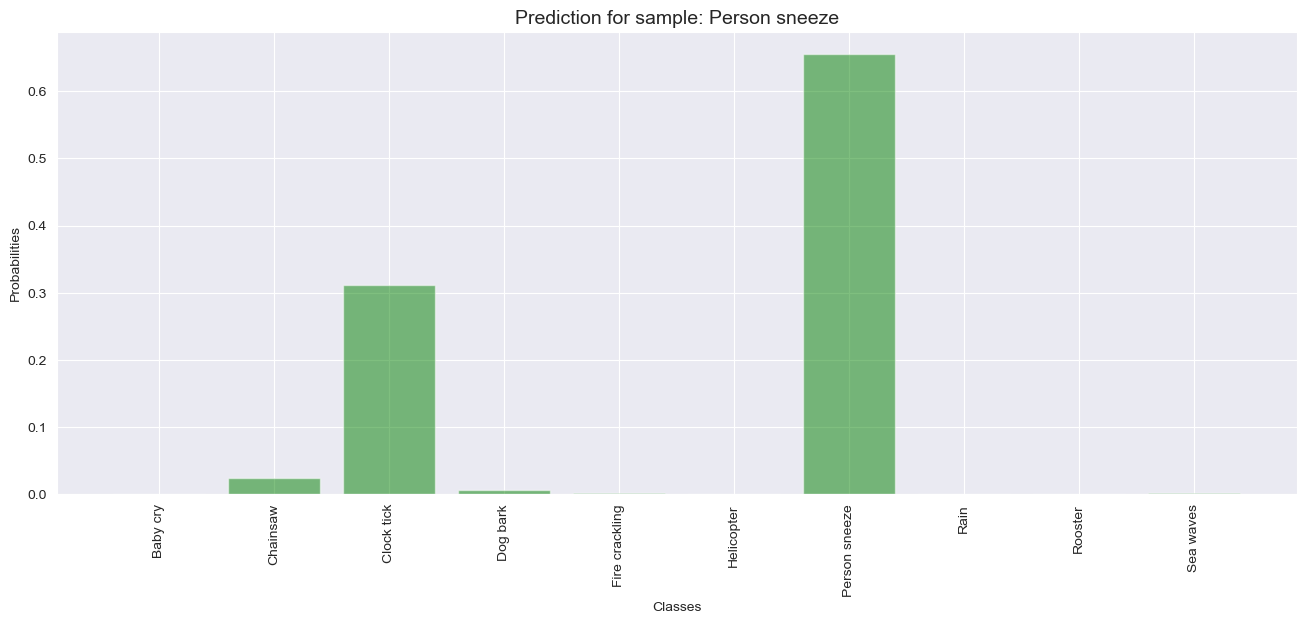

In [200]:
random_index = plot_pred_sample(LogisticR_c_saved, y_val, X_val_norm, nom_classes)

In [201]:
print(y_val[random_index])
print(LogisticR_c_saved.predict([X_val_norm[random_index]])[0])

Person sneeze
Person sneeze


In [202]:
# Testing hyperparameters for KNN classifier - After several test, the hyperparameters were set

#KNN_hp = {'n_neighbors':[3, 5, 8, 12], 
#          'metric': ['mahalanobis', 'euclidean', 'minkowski'],
#          'p':[1, 2], 
#          'leaf_size': [20, 40, 80]}

#grid_KNN = GridSearchCV(KNeighborsClassifier(), KNN_hp, refit = True, verbose=3)

#grid_KNN.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_KNN.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_KNN.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_KNN.best_params_)

In [203]:
#grid_KNN.best_params_

In [204]:
KNN_c = KNeighborsClassifier(n_neighbors = 3,
                             metric      = 'minkowski',
                             p           = 2,
                             leaf_size   = 20,
                             n_jobs      = -1)
KNN_c

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)

In [205]:
train_sizes, train_scores, test_scores = learning_curve(estimator = KNN_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 153  307  460  614  768  921 1075 1228 1382 1536]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    0.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


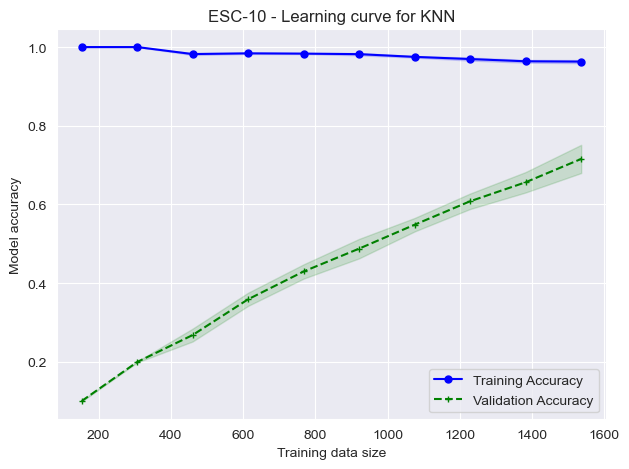

[ 153  307  460  614  768  921 1075 1228 1382 1536] samples were used to train the model

The average train accuracy is....: 98.03 % (+/-0.22 %)
The average test accuracy is.....: 43.71 % (+/-1.77 %)


In [206]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'KNN',  
                    path_pic,
                   '02_PreProcessing_modeling_14.png')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [207]:
KNN_c.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)

In [208]:
KNN_c_predict = KNN_c.predict(X_val_norm)

In [209]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_KNN.pkl"
with open(path_models + pkl_filename, 'wb') as file:
    pickle.dump(KNN_c, file)

In [210]:
# Load the classifier from file

with open(path_models + pkl_filename, 'rb') as file:
    KNN_c_saved = pickle.load(file)

In [211]:
score_KNN_c_saved = KNN_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_KNN_c_saved))
KNN_c_saved_predict = KNN_c_saved.predict(X_val_norm)

Test score (R2): 75.00 %


In [212]:
t_srt = time.process_time_ns()

KNN_c_saved_predict_val = KNN_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 296,8750 ms


In [213]:
KNN_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             KNN_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(KNN_c_saved_val_class_report)

                precision    recall  f1-score   support

      Baby cry       0.80      1.00      0.89         8
      Chainsaw       0.78      0.88      0.82         8
    Clock tick       0.67      0.50      0.57         8
      Dog bark       1.00      0.88      0.93         8
Fire crackling       0.75      0.75      0.75         8
    Helicopter       1.00      0.25      0.40         8
 Person sneeze       0.67      0.75      0.71         8
          Rain       0.54      0.88      0.67         8
       Rooster       0.83      0.62      0.71         8
     Sea waves       0.80      1.00      0.89         8

      accuracy                           0.75        80
     macro avg       0.78      0.75      0.73        80
  weighted avg       0.78      0.75      0.73        80



In [214]:
KNN_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             KNN_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)
KNN_c_saved_val_class_report_acc = KNN_c_saved_val_class_report['accuracy']
KNN_c_saved_val_class_report_acc

0.75

In [215]:
np.array_equal(KNN_c_predict, KNN_c_saved_predict)

True

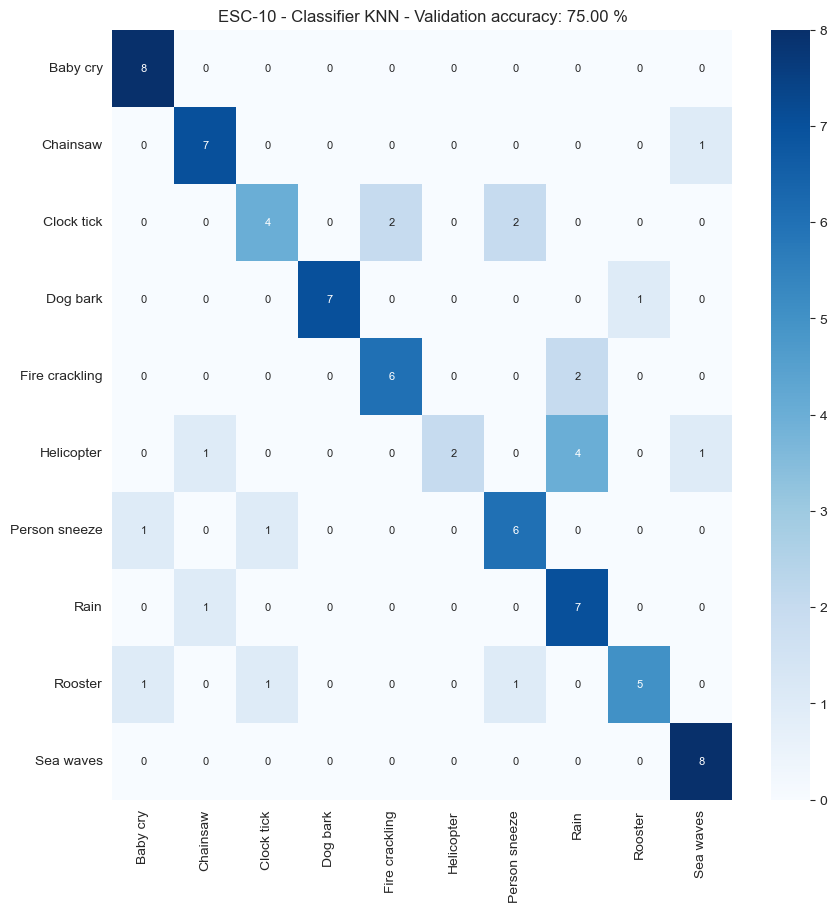

In [216]:
simple_conf_matrix(y_val, 
                   KNN_c_saved_predict_val, 
                   nom_classes,
                   'KNN',
                   KNN_c_saved_val_class_report_acc,
                   '02_PreProcessing_modeling_15.png')

78
Fire crackling
Fire crackling


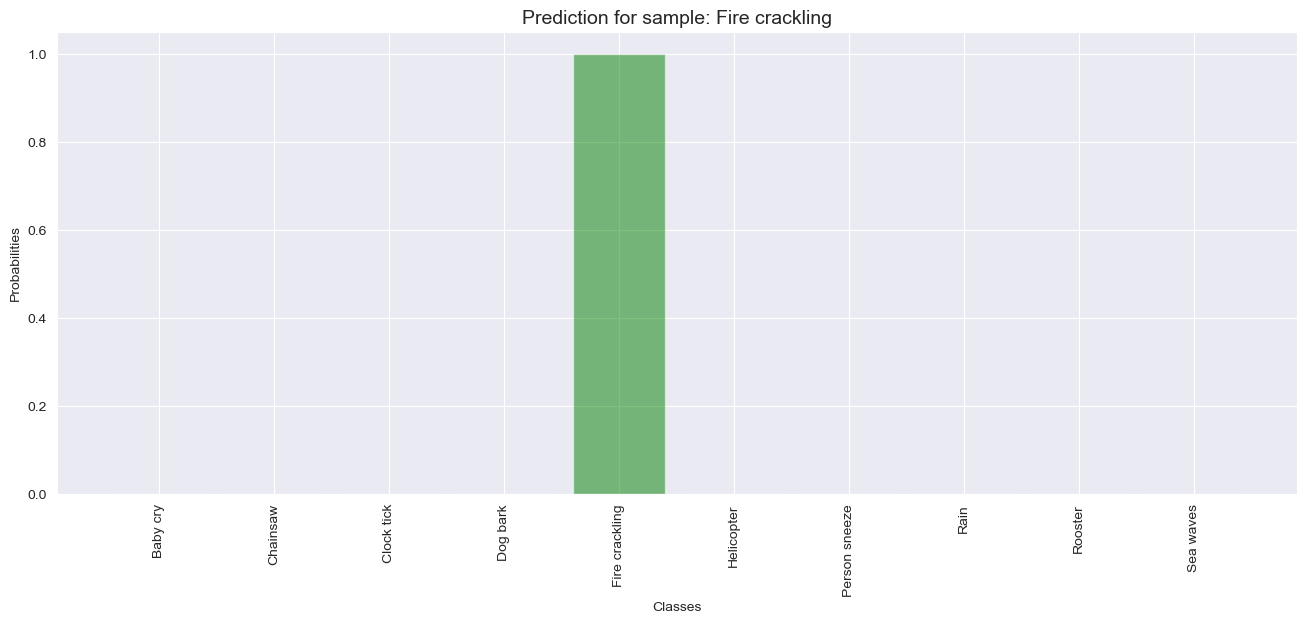

In [217]:
random_index = plot_pred_sample(KNN_c_saved, y_val, X_val_norm, nom_classes)

In [218]:
print(y_val[random_index])
print(KNN_c_saved.predict([X_val_norm[random_index]])[0])

Fire crackling
Fire crackling


In [219]:
# Testing hyperparameters for random forest classifier (ensemble method) - After several test, the hyperparameters were set

#forest_hp = {'n_estimators':[10, 25, 50, 100, 200, 500], 
#             'criterion': ['gini', 'entropy', 'log_loss'],
#             'bootstrap':[True, False]}

#grid_forest = GridSearchCV(RandomForestClassifier(), forest_hp, refit = True, verbose=3)

#grid_forest.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_forest.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_forest.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_forest.best_params_)

In [220]:
#grid_forest.best_params_

In [221]:
forest_c = RandomForestClassifier(criterion    = 'gini',
                                  n_estimators = 500,
                                  bootstrap    = True,
                                  n_jobs       = -1,
                                  verbose      = 10)
forest_c

RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=10)

In [222]:
train_sizes, train_scores, test_scores = learning_curve(estimator = forest_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 153  307  460  614  768  921 1075 1228 1382 1536]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:   13.8s remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   14.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   29.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   29.3s remaining:   40.5s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:   45.2s remaining:   38.5s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   45.5s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  1.1min remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  1.1min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


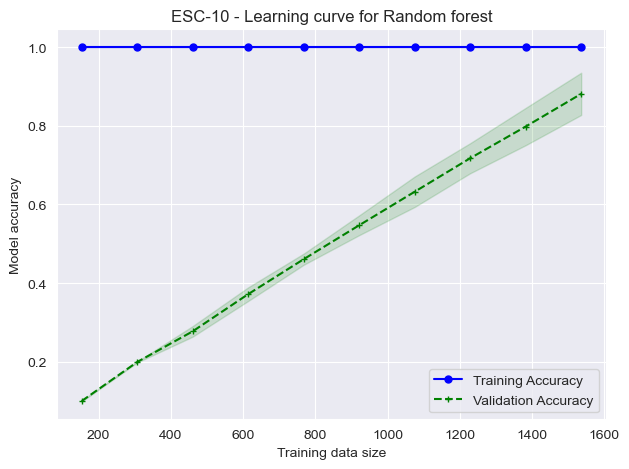

[ 153  307  460  614  768  921 1075 1228 1382 1536] samples were used to train the model

The average train accuracy is....: 100.00 % (+/-0.00 %)
The average test accuracy is.....: 49.85 % (+/-2.51 %)


In [223]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Random forest', 
                    path_pic,
                   '02_PreProcessing_modeling_16.png')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [224]:
forest_c.fit(X_train, y_train)

building tree 1 of 500building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500

building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s


building tree 13 of 500building tree 14 of 500
building tree 15 of 500

building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.3s


building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    0.6s


building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    0.8s


building tree 136 of 500building tree 137 of 500

building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500building tree 166 of 500

building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500


[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    1.1s


building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    1.4s


building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500
building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500


[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:    1.7s


building tree 252 of 500building tree 253 of 500

building tree 254 of 500
building tree 255 of 500
building tree 256 of 500
building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500
building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:    2.1s


building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500


[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    2.3s


building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    2.7s


building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500


[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    3.1s


building tree 422 of 500building tree 423 of 500

building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500


[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:    3.3s


building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.7s finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=10)

In [225]:
forest_c_predict = forest_c.predict(X_val_norm)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

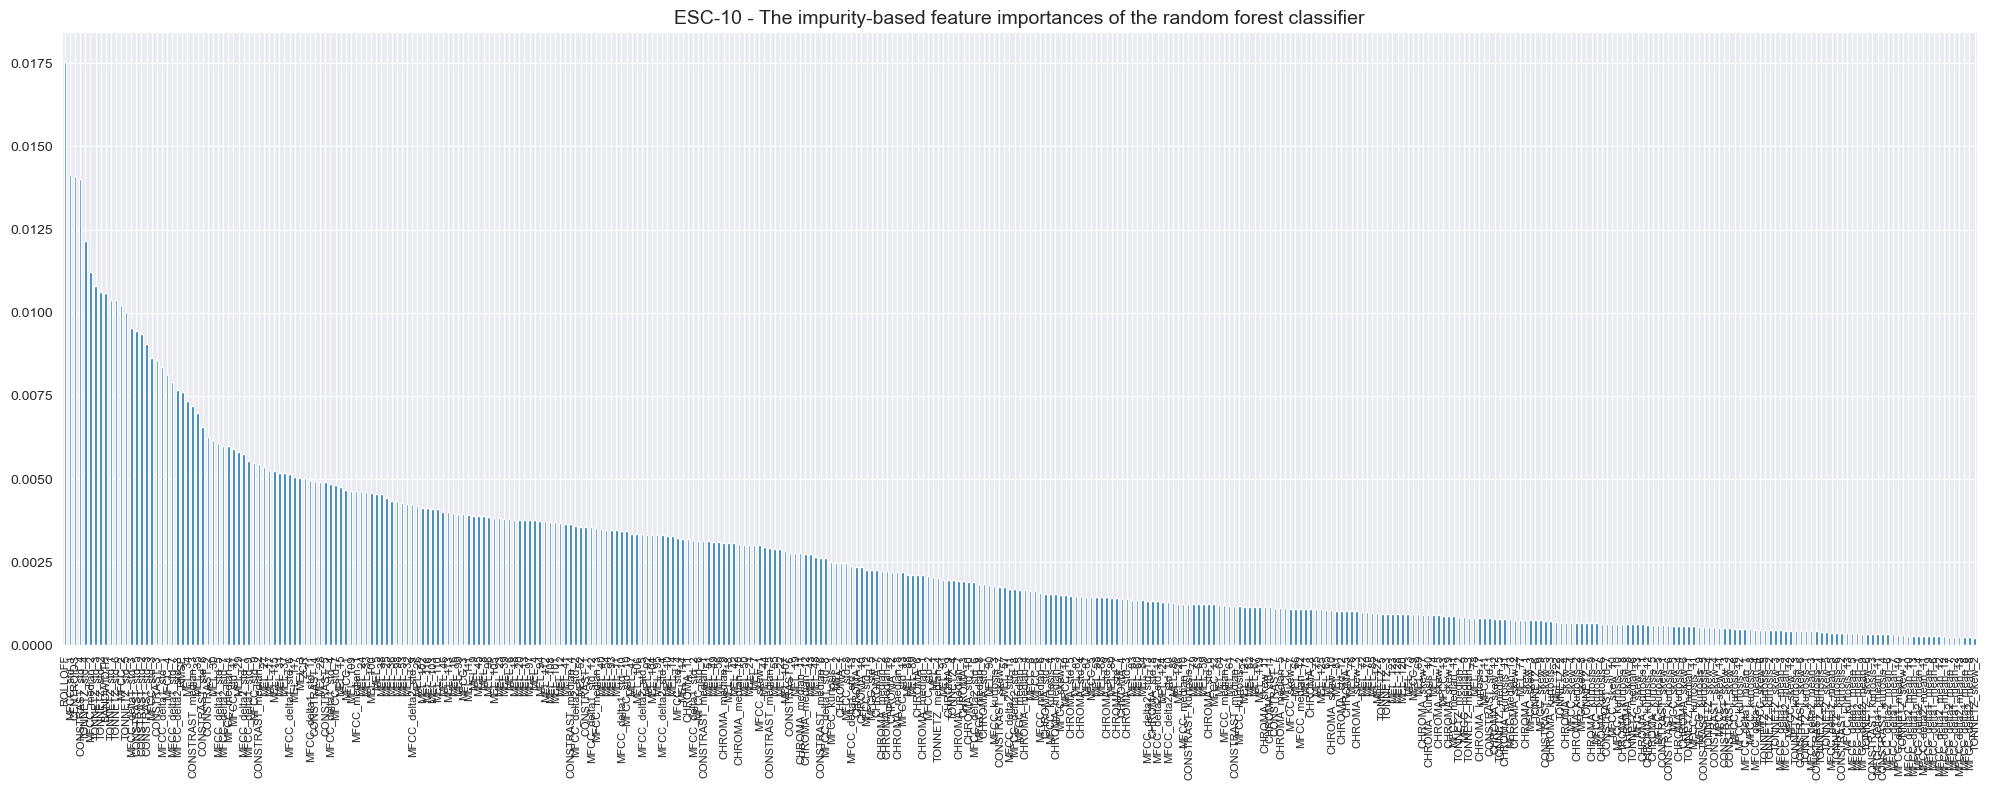

In [226]:
# Plot the feature importances of the random forest classifier

plt.figure(num=None, figsize=(20,8), facecolor='w', edgecolor='k')
feat_importances = pd.Series(forest_c.feature_importances_, index= X.columns)
temp_feature     = feat_importances.nlargest(375).reset_index()
rff = feat_importances.nlargest(375).plot(kind='bar')
rff.set_xticklabels(temp_feature['index'], fontsize=8)
plt.title(DATASET + ' - The impurity-based feature importances of the random forest classifier', fontsize = 14)
plt.tight_layout()
plt.savefig(path_pic + '02_PreProcessing_modeling_17.png')
plt.show()

In [227]:
feat_importances.nlargest(375).sum()

0.9999999999999999

In [228]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_Forest.pkl"
with open(path_models + pkl_filename, 'wb') as file:
    pickle.dump(forest_c, file)

In [229]:
# Load the classifier from file

with open(path_models + pkl_filename, 'rb') as file:
    forest_c_saved = pickle.load(file)

In [230]:
score_forest_c_saved = forest_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_forest_c_saved))
forest_c_saved_predict = forest_c_saved.predict(X_val_norm)

Test score (R2): 72.50 %


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

In [231]:
t_srt = time.process_time_ns()

forest_c_saved_predict_val = forest_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

Processing time: 62,5000 ms


[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished


In [232]:
forest_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                forest_c_saved_predict_val, 
                                                                target_names = nom_classes, 
                                                                output_dict = False)
print(forest_c_saved_val_class_report)

                precision    recall  f1-score   support

      Baby cry       1.00      0.50      0.67         8
      Chainsaw       1.00      0.88      0.93         8
    Clock tick       0.42      1.00      0.59         8
      Dog bark       0.70      0.88      0.78         8
Fire crackling       0.60      0.38      0.46         8
    Helicopter       0.67      0.50      0.57         8
 Person sneeze       1.00      0.38      0.55         8
          Rain       0.80      1.00      0.89         8
       Rooster       0.78      0.88      0.82         8
     Sea waves       1.00      0.88      0.93         8

      accuracy                           0.73        80
     macro avg       0.80      0.72      0.72        80
  weighted avg       0.80      0.72      0.72        80



In [233]:
forest_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                forest_c_saved_predict_val, 
                                                                target_names = nom_classes, 
                                                                output_dict = True)
forest_c_saved_val_class_report_acc = forest_c_saved_val_class_report['accuracy']
forest_c_saved_val_class_report_acc

0.725

In [234]:
np.array_equal(forest_c_predict, forest_c_saved_predict)

True

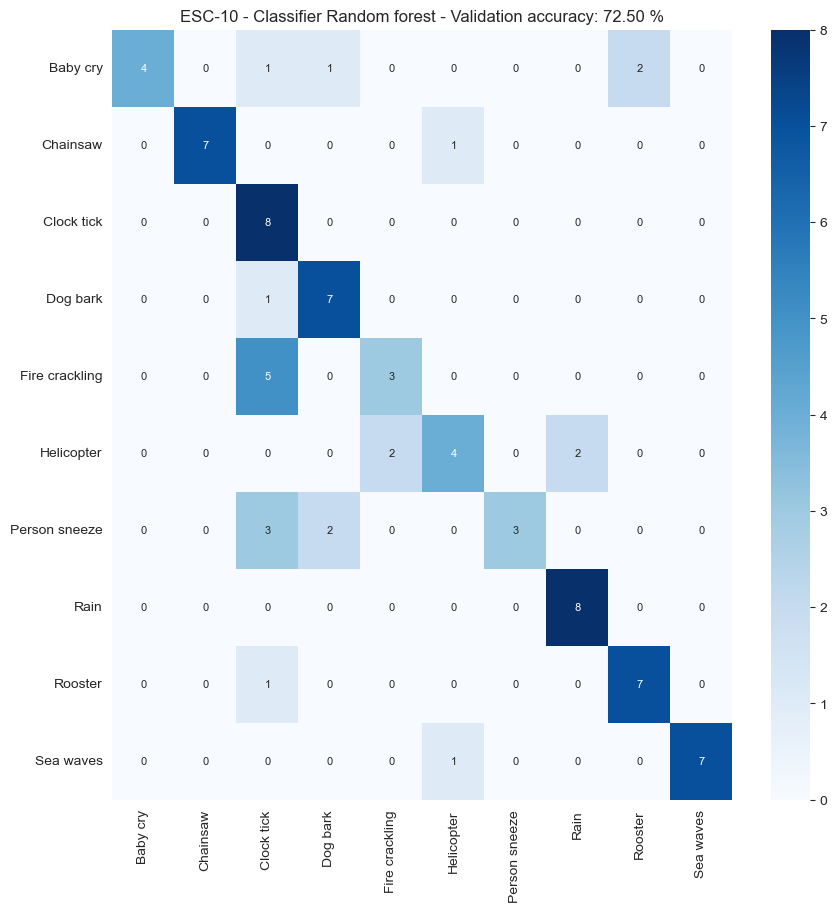

In [235]:
simple_conf_matrix(y_val, 
                   forest_c_saved_predict_val, 
                   nom_classes,
                   'Random forest',
                   forest_c_saved_val_class_report_acc,
                   '02_PreProcessing_modeling_18.png')

61
Chainsaw
Chainsaw


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

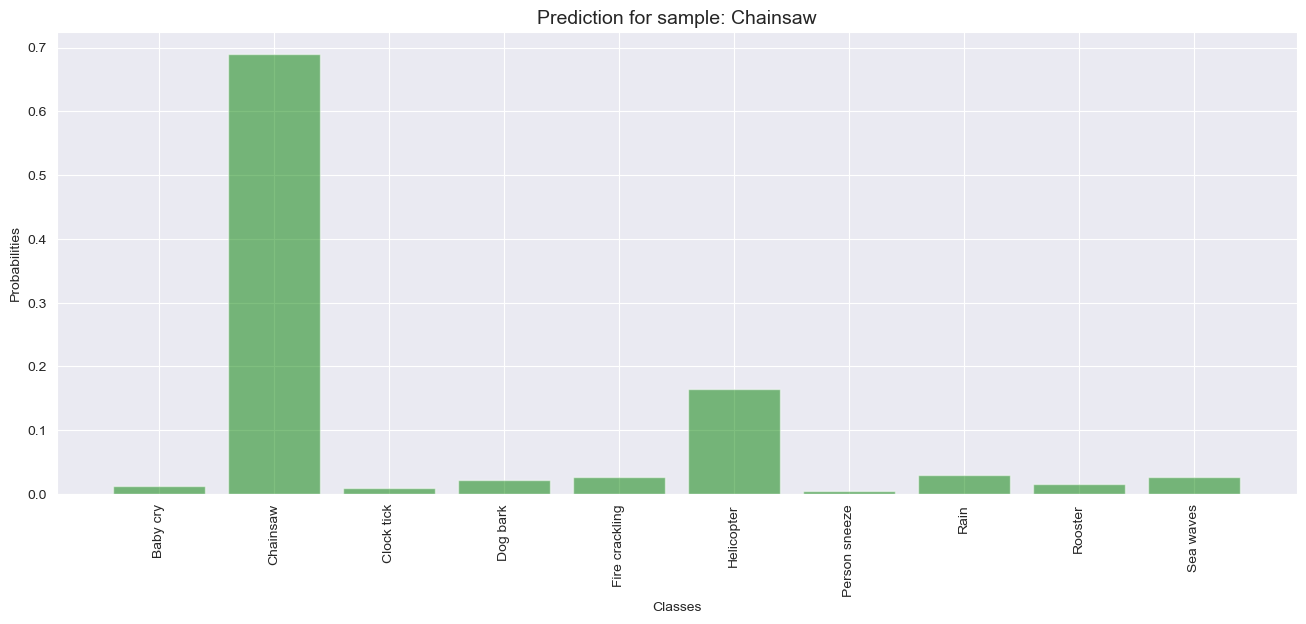

In [236]:
random_index = plot_pred_sample(forest_c_saved, y_val, X_val_norm, nom_classes)

In [237]:
print(y_val[random_index])
print(forest_c_saved.predict([X_val_norm[random_index]])[0])

Chainsaw
Chainsaw


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

### Evaluating a voting classifier for the ML algorithms

In [238]:
labels = ['Naïves Bayes', 'SVC', 'Logistic regression', 'KNN']

In [239]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c], labels):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, " Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0538s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Naïves Bayes  Accuracy: 75.36 % (+/- 5.07 %)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


SVC  Accuracy: 87.14 % (+/- 2.20 %)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0457s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Logistic regression  Accuracy: 85.94 % (+/- 2.25 %)
KNN  Accuracy: 71.56 % (+/- 3.59 %)


In [240]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], NB_c),
                                                 (labels[1], SVC_c),
                                                 (labels[2], LogisticR_c),
                                                 (labels[3], KNN_c)],
                                   voting = 'hard',
                                   n_jobs = -1,
                                   verbose = True)

In [241]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], NB_c),
                                                 (labels[1], SVC_c),
                                                 (labels[2], LogisticR_c),
                                                 (labels[3], KNN_c)],
                                   voting = 'soft',
                                   n_jobs = -1,
                                   verbose = True)

In [242]:
# Save the classifier to file in the current working directory

pkl_filename_hard = "Model_voting_hard.pkl"
with open(path_models + pkl_filename_hard, 'wb') as file:
    pickle.dump(voting_clf_hard, file)

In [243]:
# Save the classifier to file in the current working directory

pkl_filename_soft = "Model_voting_soft.pkl"
with open(path_models + pkl_filename_soft, 'wb') as file:
    pickle.dump(voting_clf_soft, file)

In [244]:
labels_new = ['Naïves Bayes', 'SVC', 'Logistic regression', 'KNN', 'Random forest', 'Voting hard', 'Voting soft']

In [245]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c, forest_c, voting_clf_hard, voting_clf_soft], labels_new):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, " Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0678s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Naïves Bayes  Accuracy: 75.36 % (+/- 5.07 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


SVC  Accuracy: 87.14 % (+/- 2.20 %)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.9s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished


Logistic regression  Accuracy: 85.94 % (+/- 2.26 %)
KNN  Accuracy: 71.56 % (+/- 3.59 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0538s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.9s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished


Random forest  Accuracy: 88.07 % (+/- 5.20 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.2s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


Voting hard  Accuracy: 86.88 % (+/- 2.55 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.3s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s


Voting soft  Accuracy: 87.19 % (+/- 2.76 %)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s finished


In [246]:
# Load the classifier from file

with open(path_models + pkl_filename_hard, 'rb') as file:
    voting_clf_hard_saved = pickle.load(file)

In [247]:
# Load the classifier from file
y
with open(path_models + pkl_filename_soft, 'rb') as file:
    voting_clf_soft_saved = pickle.load(file)

In [248]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c, forest_c, voting_clf_hard_saved, voting_clf_soft_saved], labels_new):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, "Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0818s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Naïves Bayes Accuracy: 75.36 % (+/- 5.07 %)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


SVC Accuracy: 87.14 % (+/- 2.20 %)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.2s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.2s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.3s finished


Logistic regression Accuracy: 85.99 % (+/- 2.19 %)
KNN Accuracy: 71.56 % (+/- 3.59 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0438s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.8s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.8s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


Random forest Accuracy: 87.81 % (+/- 4.96 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.2s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


Voting hard Accuracy: 86.93 % (+/- 2.47 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.6s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.6s remaining:    8.4s


Voting soft Accuracy: 87.19 % (+/- 2.76 %)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished


In [249]:
# Pipeline to run the classifiers and their metrics

def model_classifiers(dbAug, dbVal):
    
    classifiers = ['Naïve Bayes', 'SVC', 'LogisticR', 'KNN', 'Forest', 'Voting']
    
    NB_c          = GaussianNB()
    SVC_c         = SVC(kernel = 'linear', C = 0.5, probability = True, random_state = SEED)
    LogisticR_c   = LogisticRegression(solver = 'saga', max_iter = 500, C = 0.5, n_jobs = -1)
    KNN_c         = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2, leaf_size = 20, n_jobs = -1)
    forest_c      = RandomForestClassifier(n_estimators = 500, criterion = 'gini',bootstrap = True, n_jobs = -1)
    voting_c      = VotingClassifier(estimators = [(classifiers[0], NB_c),
                                                   (classifiers[1], SVC_c),
                                                   (classifiers[2], LogisticR_c),
                                                   (classifiers[3], KNN_c)],
                                     voting = 'soft')
    
    
    dic_classifiers = {'GaussianNB': NB_c, 
                       'SVC': SVC_c, 
                       'LogisticR' : LogisticR_c, 
                       'KNN': KNN_c, 
                       'Forest': forest_c, 
                       'Voting': voting_c}

    count       = 1
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Validation)',
                                                    'F1(Train)',
                                                    'F1(Validation)', 
                                                    'Precision(Train)',
                                                    'Precision(Validation)', 
                                                    'Recall(Train)',
                                                    'Recall(Validation)', 
                                                    'Conf_M',
                                                    'Process_time'])
    
    for fold in np.unique(dbAug['Fold']):
        print(f"Validation fold: {fold}")
    
        dbComplete_VAL = dbVal[dbVal['Fold'] == fold]
        dbComplete     = dbAug[dbAug['Fold'] != fold]
        
        X_val   = dbComplete_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y_val   = np.array(dbComplete_VAL.Class_categorical.to_list())
        X_train = dbComplete.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y_train = np.array(dbComplete.Class_categorical.to_list())
        
        X_val_norm = X_val.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        X_val_norm = X_val_norm.values
        X_train_norm = X_train.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        X_train_norm = X_train_norm.values
      
        # Store the categorical labels to be used in the confusion matrix
        list_counter_val = Counter(y_val)
        labels             = list(list_counter_val)
        
        for c in tqdm(dic_classifiers.items()):
            
            name         = c[0]
            model_name   = ('Model_' + c[0] + '_' + str(count))
            count        = count + 1
            model        = c[1]
            print(name)
            print(model)

            # Fitting the model to the classifier
            model.fit(X_train_norm, y_train)

            # Get the model predictions
            y_train_predicted = model.predict(X_train_norm)
            
            t_srt             = time.process_time_ns()
            y_val_predicited  = model.predict(X_val_norm)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)

            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y_train, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val,  y_val_predicited)

            f1_Score_train = metrics.f1_score(y_train, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val,  y_val_predicited, average = 'weighted')

            precision_score_train = metrics.precision_score(y_train, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val,  y_val_predicited, average = 'weighted')

            recall_score_train = metrics.recall_score(y_train, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val,  y_val_predicited, average = 'weighted')
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val, y_val_predicited)

            # Store the name, validation accuracy results and model
            models.append((name, accuracy_val, model))
            
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Validation)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Validation)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Validation)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Validation)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time]})], ignore_index = True)
                   
    return acc_set, models, labels

In [250]:
metrics_set, models_set, cm_labels = model_classifiers(DB_aug_from_pkl, DB_ori_from_pkl)

Validation fold: 1


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)


 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.85it/s]

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')


 50%|██████████████████████████████████████████                                          | 3/6 [00:03<00:03,  1.30s/it]

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:03<00:01,  1.09it/s]

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:02,  2.01s/it]

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 voting='soft')


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.87s/it]


Validation fold: 2


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)


 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.71it/s]

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')


 50%|██████████████████████████████████████████                                          | 3/6 [00:03<00:03,  1.32s/it]

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:03<00:01,  1.08it/s]

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.98s/it]

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 voting='soft')


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.87s/it]


Validation fold: 3


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)


 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.87it/s]

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')


 50%|██████████████████████████████████████████                                          | 3/6 [00:03<00:03,  1.25s/it]

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:03<00:01,  1.14it/s]

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.91s/it]

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 voting='soft')


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.82s/it]


Validation fold: 4


 17%|██████████████                                                                      | 1/6 [00:00<00:00,  9.55it/s]

GaussianNB
GaussianNB()
SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)


 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.19it/s]

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')


 50%|██████████████████████████████████████████                                          | 3/6 [00:03<00:03,  1.29s/it]

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:03<00:01,  1.12it/s]

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:02,  2.00s/it]

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 voting='soft')


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.76s/it]


Validation fold: 5


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)


 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.74it/s]

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')


 50%|██████████████████████████████████████████                                          | 3/6 [00:03<00:03,  1.30s/it]

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:03<00:01,  1.09it/s]

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:02,  2.02s/it]

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 voting='soft')


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.88s/it]


## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [251]:
metrics_set

,Model,Accuracy(Train),Accuracy(Validation),F1(Train),...,Recall(Train),Recall(Validation),Conf_M,Process_time
0,GaussianNB,0.861458,0.2750,0.861397,...,0.861458,0.2750,"[[2, 0, 0, 2, 0, 0, 3, 0, 1, 0], [0, 5, 0, 0, 0, 1, 1, 0, 1, 0], [0, 0, 0, 1, 0, 1, 3, 0, 3, 0], [0, 0, 0, 1, 0, 0, ...",0.000
1,SVC,0.992708,0.7625,0.992680,...,0.992708,0.7625,"[[5, 0, 0, 1, 0, 0, 1, 0, 1, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 5, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 8, 0, 0, ...",0.000
2,LogisticR,0.976562,0.7750,0.976564,...,0.976562,0.7750,"[[5, 0, 0, 2, 0, 0, 1, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 2, 1, 0, 0, 0], [0, 0, 0, 8, 0, 0, ...",0.000
3,KNN,0.971354,0.7500,0.971444,...,0.971354,0.7500,"[[7, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 7, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 4, 0, 2, 0, 2, 0, 0, 0], [0, 0, 0, 7, 0, 0, ...",281.250
4,Forest,1.000000,0.7625,1.000000,...,1.000000,0.7625,"[[7, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 2, 0, 1, 2, 0, 0, 0], [0, 0, 0, 7, 0, 0, ...",78.125
5,Voting,0.988542,0.7750,0.988520,...,0.988542,0.7750,"[[5, 0, 0, 2, 0, 0, 1, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 4, 0, 0, 1, 3, 0, 0, 0], [0, 0, 0, 8, 0, 0, ...",1015.625
6,GaussianNB,0.855729,0.3125,0.856204,...,0.855729,0.3125,"[[0, 0, 0, 0, 0, 0, 4, 0, 4, 0], [0, 7, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 1, 1, 0, 5, 0], [0, 1, 0, 2, 0, 1, ...",0.000
7,SVC,0.988021,0.7750,0.987965,...,0.988021,0.7750,"[[4, 0, 0, 0, 0, 0, 2, 0, 2, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 7, 0, 0, ...",15.625
8,LogisticR,0.973437,0.8000,0.973454,...,0.973437,0.8000,"[[5, 0, 0, 0, 0, 0, 2, 0, 1, 0], [0, 7, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 4, 0, 1, 0, 2, 1, 0, 0], [0, 0, 0, 7, 0, 0, ...",0.000
9,KNN,0.966667,0.7250,0.966748,...,0.966667,0.7250,"[[3, 0, 0, 0, 0, 0, 4, 0, 1, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 4, 1, 0, 0, 3, 0, 0, 0], [1, 0, 0, 6, 0, 0, ...",453.125


In [252]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model'], ascending = [True, ])
metrics_set

,Model,Accuracy(Train),Accuracy(Validation),F1(Train),...,Recall(Train),Recall(Validation),Conf_M,Process_time
16,Forest,1.000000,0.7500,1.000000,...,1.000000,0.7500,"[[8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 1, 6, 0, 0, ...",109.375
28,Forest,1.000000,0.8250,1.000000,...,1.000000,0.8250,"[[7, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 7, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 6, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 6, 0, 0, ...",62.500
4,Forest,1.000000,0.7625,1.000000,...,1.000000,0.7625,"[[7, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 2, 0, 1, 2, 0, 0, 0], [0, 0, 0, 7, 0, 0, ...",78.125
10,Forest,1.000000,0.7750,1.000000,...,1.000000,0.7750,"[[7, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 6, 0, 0, ...",78.125
22,Forest,1.000000,0.8250,1.000000,...,1.000000,0.8250,"[[8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 7, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 5, 3, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 0, ...",109.375
18,GaussianNB,0.844792,0.3375,0.844084,...,0.844792,0.3375,"[[1, 0, 0, 3, 0, 0, 0, 0, 4, 0], [0, 5, 0, 0, 0, 2, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 2, 0, 5, 0], [0, 0, 0, 2, 0, 0, ...",0.000
12,GaussianNB,0.856771,0.4000,0.856139,...,0.856771,0.4000,"[[4, 0, 0, 3, 0, 0, 0, 0, 1, 0], [0, 5, 0, 0, 0, 1, 2, 0, 0, 0], [0, 0, 2, 2, 0, 0, 1, 0, 3, 0], [0, 0, 0, 3, 0, 0, ...",0.000
0,GaussianNB,0.861458,0.2750,0.861397,...,0.861458,0.2750,"[[2, 0, 0, 2, 0, 0, 3, 0, 1, 0], [0, 5, 0, 0, 0, 1, 1, 0, 1, 0], [0, 0, 0, 1, 0, 1, 3, 0, 3, 0], [0, 0, 0, 1, 0, 0, ...",0.000
24,GaussianNB,0.851562,0.4375,0.852161,...,0.851562,0.4375,"[[5, 0, 0, 2, 0, 0, 0, 0, 1, 0], [0, 6, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0, 2, 0, 4, 0], [1, 0, 0, 2, 0, 0, ...",0.000
6,GaussianNB,0.855729,0.3125,0.856204,...,0.855729,0.3125,"[[0, 0, 0, 0, 0, 0, 4, 0, 4, 0], [0, 7, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 1, 1, 0, 5, 0], [0, 1, 0, 2, 0, 1, ...",0.000


In [253]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Validation)'], ascending = [True, True]).reset_index()
metrics_set

,index,Model,Accuracy(Train),Accuracy(Validation),...,Recall(Train),Recall(Validation),Conf_M,Process_time
0,16,Forest,1.000000,0.7500,...,1.000000,0.7500,"[[8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 1, 6, 0, 0, ...",109.375
1,4,Forest,1.000000,0.7625,...,1.000000,0.7625,"[[7, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 2, 0, 1, 2, 0, 0, 0], [0, 0, 0, 7, 0, 0, ...",78.125
2,10,Forest,1.000000,0.7750,...,1.000000,0.7750,"[[7, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 8, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 6, 0, 0, ...",78.125
3,28,Forest,1.000000,0.8250,...,1.000000,0.8250,"[[7, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 7, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 6, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 6, 0, 0, ...",62.500
4,22,Forest,1.000000,0.8250,...,1.000000,0.8250,"[[8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 7, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 5, 3, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 0, ...",109.375
5,0,GaussianNB,0.861458,0.2750,...,0.861458,0.2750,"[[2, 0, 0, 2, 0, 0, 3, 0, 1, 0], [0, 5, 0, 0, 0, 1, 1, 0, 1, 0], [0, 0, 0, 1, 0, 1, 3, 0, 3, 0], [0, 0, 0, 1, 0, 0, ...",0.000
6,6,GaussianNB,0.855729,0.3125,...,0.855729,0.3125,"[[0, 0, 0, 0, 0, 0, 4, 0, 4, 0], [0, 7, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 1, 1, 0, 5, 0], [0, 1, 0, 2, 0, 1, ...",0.000
7,18,GaussianNB,0.844792,0.3375,...,0.844792,0.3375,"[[1, 0, 0, 3, 0, 0, 0, 0, 4, 0], [0, 5, 0, 0, 0, 2, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 2, 0, 5, 0], [0, 0, 0, 2, 0, 0, ...",0.000
8,12,GaussianNB,0.856771,0.4000,...,0.856771,0.4000,"[[4, 0, 0, 3, 0, 0, 0, 0, 1, 0], [0, 5, 0, 0, 0, 1, 2, 0, 0, 0], [0, 0, 2, 2, 0, 0, 1, 0, 3, 0], [0, 0, 0, 3, 0, 0, ...",0.000
9,24,GaussianNB,0.851562,0.4375,...,0.851562,0.4375,"[[5, 0, 0, 2, 0, 0, 0, 0, 1, 0], [0, 6, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0, 2, 0, 4, 0], [1, 0, 0, 2, 0, 0, ...",0.000


In [254]:
metrics_set.sort_values(by='Accuracy(Validation)').style.background_gradient(cmap = cmap_cm)

,index,Model,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Conf_M,Process_time
5,0,GaussianNB,0.861458,0.275000,0.861397,0.209224,0.874069,0.237452,0.861458,0.275000,[[2 0 0 2 0 0 3 0 1 0] [0 5 0 0 0 1 1 0 1 0] [0 0 0 1 0 1 3 0 3 0] [0 0 0 1 0 0 0 0 7 0] [0 0 0 0 0 6 2 0 0 0] [0 1 0 0 0 3 4 0 0 0] [0 1 0 2 0 0 3 0 2 0] [0 0 0 1 0 0 7 0 0 0] [0 0 0 0 0 0 0 0 8 0] [0 3 0 0 0 0 4 0 1 0]],0.000000
6,6,GaussianNB,0.855729,0.312500,0.856204,0.214258,0.866494,0.262289,0.855729,0.312500,[[0 0 0 0 0 0 4 0 4 0] [0 7 0 0 0 0 1 0 0 0] [0 0 1 0 0 1 1 0 5 0] [0 1 0 2 0 1 0 0 4 0] [0 0 0 0 0 5 3 0 0 0] [0 6 0 0 0 2 0 0 0 0] [0 1 0 1 0 0 6 0 0 0] [0 1 0 0 0 4 3 0 0 0] [0 1 0 0 0 0 0 0 7 0] [0 4 0 1 0 0 3 0 0 0]],0.000000
7,18,GaussianNB,0.844792,0.337500,0.844084,0.252161,0.852798,0.362955,0.844792,0.337500,[[1 0 0 3 0 0 0 0 4 0] [0 5 0 0 0 2 0 0 1 0] [0 0 0 1 0 0 2 0 5 0] [0 0 0 2 0 0 2 0 4 0] [0 0 0 0 1 5 2 0 0 0] [0 2 0 0 0 6 0 0 0 0] [0 0 0 1 0 0 5 0 2 0] [0 3 0 0 0 4 0 0 1 0] [0 0 0 0 0 1 0 0 7 0] [0 5 0 1 0 2 0 0 0 0]],0.000000
8,12,GaussianNB,0.856771,0.400000,0.856139,0.346271,0.869856,0.421194,0.856771,0.400000,[[4 0 0 3 0 0 0 0 1 0] [0 5 0 0 0 1 2 0 0 0] [0 0 2 2 0 0 1 0 3 0] [0 0 0 3 0 0 0 0 5 0] [0 0 3 0 1 3 0 0 1 0] [0 2 0 0 0 5 1 0 0 0] [0 0 0 1 0 2 5 0 0 0] [0 3 0 0 0 5 0 0 0 0] [0 0 0 0 0 0 1 0 7 0] [0 5 0 2 0 1 0 0 0 0]],0.000000
9,24,GaussianNB,0.851562,0.437500,0.852161,0.345371,0.865578,0.334744,0.851562,0.437500,[[5 0 0 2 0 0 0 0 1 0] [0 6 0 1 0 0 1 0 0 0] [0 0 1 1 0 0 2 0 4 0] [1 0 0 2 0 0 0 0 5 0] [0 1 1 0 0 2 4 0 0 0] [0 1 0 0 0 6 1 0 0 0] [0 0 0 0 0 0 7 0 1 0] [0 6 0 0 0 1 1 0 0 0] [0 0 0 0 0 0 0 0 8 0] [0 4 0 3 0 1 0 0 0 0]],0.000000
10,27,KNN,0.969792,0.700000,0.969915,0.687692,0.971410,0.740754,0.969792,0.700000,[[8 0 0 0 0 0 0 0 0 0] [0 6 0 0 0 1 0 1 0 0] [1 0 2 1 2 0 2 0 0 0] [2 0 0 4 0 0 1 0 1 0] [0 0 0 0 7 0 0 1 0 0] [0 2 0 0 0 6 0 0 0 0] [2 0 0 0 0 0 5 0 1 0] [0 1 0 0 0 1 0 6 0 0] [1 0 0 1 0 0 0 0 6 0] [0 0 0 0 0 0 0 2 0 6]],546.875000
11,9,KNN,0.966667,0.725000,0.966748,0.711013,0.968078,0.803800,0.966667,0.725000,[[3 0 0 0 0 0 4 0 1 0] [0 8 0 0 0 0 0 0 0 0] [0 0 4 1 0 0 3 0 0 0] [1 0 0 6 0 0 1 0 0 0] [0 0 0 0 8 0 0 0 0 0] [0 1 0 0 0 2 0 2 0 3] [0 0 0 0 0 0 8 0 0 0] [0 0 0 0 0 0 0 8 0 0] [0 0 0 0 0 0 2 0 6 0] [0 0 0 0 0 0 0 3 0 5]],453.125000
12,3,KNN,0.971354,0.750000,0.971444,0.734333,0.972915,0.786151,0.971354,0.750000,[[7 0 0 1 0 0 0 0 0 0] [0 7 0 0 0 0 0 0 0 1] [0 0 4 0 2 0 2 0 0 0] [0 0 0 7 0 0 0 0 1 0] [0 0 0 0 8 0 0 0 0 0] [0 1 0 0 2 2 0 3 0 0] [0 0 1 1 0 0 6 0 0 0] [0 1 0 0 0 0 0 7 0 0] [1 0 0 0 0 0 1 0 6 0] [0 0 0 0 0 0 0 2 0 6]],281.250000
0,16,Forest,1.000000,0.750000,1.000000,0.731143,1.000000,0.812735,1.000000,0.750000,[[8 0 0 0 0 0 0 0 0 0] [0 8 0 0 0 0 0 0 0 0] [0 0 4 0 4 0 0 0 0 0] [0 0 1 6 0 0 0 0 1 0] [0 0 1 0 7 0 0 0 0 0] [0 0 0 0 0 8 0 0 0 0] [0 0 0 0 2 0 6 0 0 0] [0 0 0 0 0 3 0 5 0 0] [1 0 0 0 0 0 0 0 7 0] [0 0 0 0 0 4 0 3 0 1]],109.375000
21,1,SVC,0.992708,0.762500,0.992680,0.756988,0.992809,0.794982,0.992708,0.762500,[[5 0 0 1 0 0 1 0 1 0] [0 8 0 0 0 0 0 0 0 0] [0 0 5 0 1 1 1 0 0 0] [0 0 0 8 0 0 0 0 0 0] [0 0 0 0 7 0 1 0 0 0] [0 0 0 0 2 3 0 3 0 0] [0 0 0 2 0 0 6 0 0 0] [0 1 0 0 0 0 0 6 0 1] [0 0 0 1 0 0 0 0 7 0] [0 0 0 0 0 0 0 2 0 6]],0.000000


In [255]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Validation)'].max()
highest_accuracy

Model
Forest        0.8250
GaussianNB    0.4375
KNN           0.7875
LogisticR     0.8625
SVC           0.8500
Voting        0.8125
Name: Accuracy(Validation), dtype: float64

In [256]:
list_classifiers = metrics_set['Model'].unique().tolist()
list_classifiers

['Forest', 'GaussianNB', 'KNN', 'LogisticR', 'SVC', 'Voting']

In [257]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in list_classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [258]:
results['SVC']

,index,Accuracy(Train),Accuracy(Validation),F1(Train),...,Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,5.0000,5.0000,5.0000,5.0000,...,5.0000,5.0000,5.0000,5.0000
mean,13.0000,0.9905,0.7875,0.9905,...,0.7952,0.9905,0.7875,12.5000
std,9.4868,0.0028,0.0364,0.0028,...,0.0465,0.0028,0.0364,6.9877
min,1.0000,0.9875,0.7625,0.9875,...,0.7339,0.9875,0.7625,0.0000
25%,7.0000,0.9880,0.7625,0.9880,...,0.7827,0.9880,0.7625,15.6250
50%,13.0000,0.9906,0.7750,0.9906,...,0.7950,0.9906,0.7750,15.6250
75%,19.0000,0.9927,0.7875,0.9927,...,0.8010,0.9927,0.7875,15.6250
max,25.0000,0.9938,0.8500,0.9938,...,0.8636,0.9938,0.8500,15.6250


In [259]:
results['GaussianNB']

,index,Accuracy(Train),Accuracy(Validation),F1(Train),...,Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,5.0000,5.0000,5.0000,5.0000,...,5.0000,5.0000,5.0000,5.0
mean,12.0000,0.8541,0.3525,0.8540,...,0.3237,0.8541,0.3525,0.0
std,9.4868,0.0063,0.0658,0.0064,...,0.0748,0.0063,0.0658,0.0
min,0.0000,0.8448,0.2750,0.8441,...,0.2375,0.8448,0.2750,0.0
25%,6.0000,0.8516,0.3125,0.8522,...,0.2623,0.8516,0.3125,0.0
50%,12.0000,0.8557,0.3375,0.8561,...,0.3347,0.8557,0.3375,0.0
75%,18.0000,0.8568,0.4000,0.8562,...,0.3630,0.8568,0.4000,0.0
max,24.0000,0.8615,0.4375,0.8614,...,0.4212,0.8615,0.4375,0.0


In [260]:
results['LogisticR']

,index,Accuracy(Train),Accuracy(Validation),F1(Train),...,Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,5.0000,5.0000,5.0000,5.0000,...,5.0000,5.0000,5.0000,5.0
mean,14.0000,0.9750,0.8125,0.9750,...,0.8429,0.9750,0.8125,0.0
std,9.4868,0.0013,0.0331,0.0013,...,0.0457,0.0013,0.0331,0.0
min,2.0000,0.9734,0.7750,0.9735,...,0.7691,0.9734,0.7750,0.0
25%,8.0000,0.9745,0.8000,0.9744,...,0.8307,0.9745,0.8000,0.0
50%,14.0000,0.9745,0.8000,0.9744,...,0.8579,0.9745,0.8000,0.0
75%,20.0000,0.9760,0.8250,0.9761,...,0.8763,0.9760,0.8250,0.0
max,26.0000,0.9766,0.8625,0.9766,...,0.8806,0.9766,0.8625,0.0


In [261]:
results['KNN']

,index,Accuracy(Train),Accuracy(Validation),F1(Train),...,Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,5.0000,5.0000,5.0000,5.0000,...,5.0000,5.0000,5.0000,5.0000
mean,15.0000,0.9705,0.7475,0.9706,...,0.7855,0.9705,0.7475,456.2500
std,9.4868,0.0024,0.0358,0.0024,...,0.0268,0.0024,0.0358,105.6278
min,3.0000,0.9667,0.7000,0.9667,...,0.7408,0.9667,0.7000,281.2500
25%,9.0000,0.9698,0.7250,0.9699,...,0.7862,0.9698,0.7250,453.1250
50%,15.0000,0.9714,0.7500,0.9714,...,0.7884,0.9714,0.7500,468.7500
75%,21.0000,0.9724,0.7750,0.9724,...,0.8038,0.9724,0.7750,531.2500
max,27.0000,0.9724,0.7875,0.9725,...,0.8086,0.9724,0.7875,546.8750


In [262]:
results['Forest']

,index,Accuracy(Train),Accuracy(Validation),F1(Train),...,Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,5.0000,5.0,5.0000,5.0,...,5.0000,5.0,5.0000,5.0000
mean,16.0000,1.0,0.7875,1.0,...,0.8402,1.0,0.7875,87.5000
std,9.4868,0.0,0.0354,0.0,...,0.0297,0.0,0.0354,20.9631
min,4.0000,1.0,0.7500,1.0,...,0.8127,1.0,0.7500,62.5000
25%,10.0000,1.0,0.7625,1.0,...,0.8136,1.0,0.7625,78.1250
50%,16.0000,1.0,0.7750,1.0,...,0.8380,1.0,0.7750,78.1250
75%,22.0000,1.0,0.8250,1.0,...,0.8529,1.0,0.8250,109.3750
max,28.0000,1.0,0.8250,1.0,...,0.8838,1.0,0.8250,109.3750


In [263]:
results['Voting']

,index,Accuracy(Train),Accuracy(Validation),F1(Train),...,Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,5.0000,5.0000,5.0000,5.0000,...,5.0000,5.0000,5.0000,5.0000
mean,17.0000,0.9886,0.7975,0.9886,...,0.8210,0.9886,0.7975,843.7500
std,9.4868,0.0031,0.0163,0.0031,...,0.0400,0.0031,0.0163,123.0314
min,5.0000,0.9854,0.7750,0.9854,...,0.7502,0.9854,0.7750,671.8750
25%,11.0000,0.9870,0.7875,0.9870,...,0.8324,0.9870,0.7875,812.5000
50%,17.0000,0.9885,0.8000,0.9885,...,0.8364,0.9885,0.8000,859.3750
75%,23.0000,0.9885,0.8125,0.9885,...,0.8370,0.9885,0.8125,859.3750
max,29.0000,0.9938,0.8125,0.9937,...,0.8489,0.9938,0.8125,1015.6250


In [264]:
metrics_set_no_cm = metrics_set.drop('Conf_M', axis=1)
metrics_set_no_cm

,index,Model,Accuracy(Train),Accuracy(Validation),...,Precision(Validation),Recall(Train),Recall(Validation),Process_time
0,16,Forest,1.000000,0.7500,...,0.812735,1.000000,0.7500,109.375
1,4,Forest,1.000000,0.7625,...,0.838013,1.000000,0.7625,78.125
2,10,Forest,1.000000,0.7750,...,0.813608,1.000000,0.7750,78.125
3,28,Forest,1.000000,0.8250,...,0.852937,1.000000,0.8250,62.500
4,22,Forest,1.000000,0.8250,...,0.883838,1.000000,0.8250,109.375
5,0,GaussianNB,0.861458,0.2750,...,0.237452,0.861458,0.2750,0.000
6,6,GaussianNB,0.855729,0.3125,...,0.262289,0.855729,0.3125,0.000
7,18,GaussianNB,0.844792,0.3375,...,0.362955,0.844792,0.3375,0.000
8,12,GaussianNB,0.856771,0.4000,...,0.421194,0.856771,0.4000,0.000
9,24,GaussianNB,0.851562,0.4375,...,0.334744,0.851562,0.4375,0.000


In [265]:
# Writes de results to a CSV file

metrics_set.to_csv(path_pic + 'ESC-10_metrics_set.csv', sep='\t', encoding='utf-8')
metrics_set_no_cm.to_csv(path_pic + 'ESC-10_metrics_set_no_cm.csv', sep='\t', encoding='utf-8')

In [266]:
idx = metrics_set.groupby('Model')['Accuracy(Validation)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Validation)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

{'Forest': {'Accuracy(Validation)': 0.825,
  'Conf_M': array([[7, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 7, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 6, 0, 0, 0, 1, 0, 1, 0],
         [0, 0, 0, 6, 0, 0, 0, 0, 2, 0],
         [0, 0, 1, 0, 5, 1, 0, 0, 0, 1],
         [0, 1, 0, 0, 0, 7, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 7, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 6, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 8, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 7]], dtype=int64)},
 'GaussianNB': {'Accuracy(Validation)': 0.4375,
  'Conf_M': array([[5, 0, 0, 2, 0, 0, 0, 0, 1, 0],
         [0, 6, 0, 1, 0, 0, 1, 0, 0, 0],
         [0, 0, 1, 1, 0, 0, 2, 0, 4, 0],
         [1, 0, 0, 2, 0, 0, 0, 0, 5, 0],
         [0, 1, 1, 0, 0, 2, 4, 0, 0, 0],
         [0, 1, 0, 0, 0, 6, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 7, 0, 1, 0],
         [0, 6, 0, 0, 0, 1, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 8, 0],
         [0, 4, 0, 3, 0, 1, 0, 0, 0, 0]], dtype=int64)},
 'KNN': {'Accuracy(Validation)': 0.78

In [267]:
conf_matrices_dict['SVC']['Conf_M']

array([[8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 6, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 7, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 7, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 7, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 7, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 0, 5, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 7, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 7]], dtype=int64)

In [268]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Validation)'])
    print(conf_matrices_dict[i]['Conf_M'])

1
Forest
0.825
[[7 0 0 0 0 0 0 0 1 0]
 [0 7 0 0 0 1 0 0 0 0]
 [0 0 6 0 0 0 1 0 1 0]
 [0 0 0 6 0 0 0 0 2 0]
 [0 0 1 0 5 1 0 0 0 1]
 [0 1 0 0 0 7 0 0 0 0]
 [1 0 0 0 0 0 7 0 0 0]
 [0 1 0 0 0 0 0 6 0 1]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 1 0 0 0 7]]
2
GaussianNB
0.4375
[[5 0 0 2 0 0 0 0 1 0]
 [0 6 0 1 0 0 1 0 0 0]
 [0 0 1 1 0 0 2 0 4 0]
 [1 0 0 2 0 0 0 0 5 0]
 [0 1 1 0 0 2 4 0 0 0]
 [0 1 0 0 0 6 1 0 0 0]
 [0 0 0 0 0 0 7 0 1 0]
 [0 6 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 4 0 3 0 1 0 0 0 0]]
3
KNN
0.7875
[[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 2 0 0 1]
 [0 0 4 0 3 0 1 0 0 0]
 [1 0 0 7 0 0 0 0 0 0]
 [0 0 0 0 7 0 0 1 0 0]
 [0 0 0 0 1 7 0 0 0 0]
 [0 0 2 1 0 0 5 0 0 0]
 [0 0 0 0 2 0 0 5 0 1]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 1 0 7]]
4
LogisticR
0.8625
[[8 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 7 1 0 0 0 0 0 0]
 [1 0 0 5 0 0 1 0 1 0]
 [0 0 0 0 7 1 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0]
 [1 0 0 0 0 0 7 0 0 0]
 [0 0 0 0 1 2 0 5 0 0]
 [0 0 0 1 0 0 0 0 7 0]
 [0 0 0 0 0 1 0 0 0 7]]
5
SVC
0.8

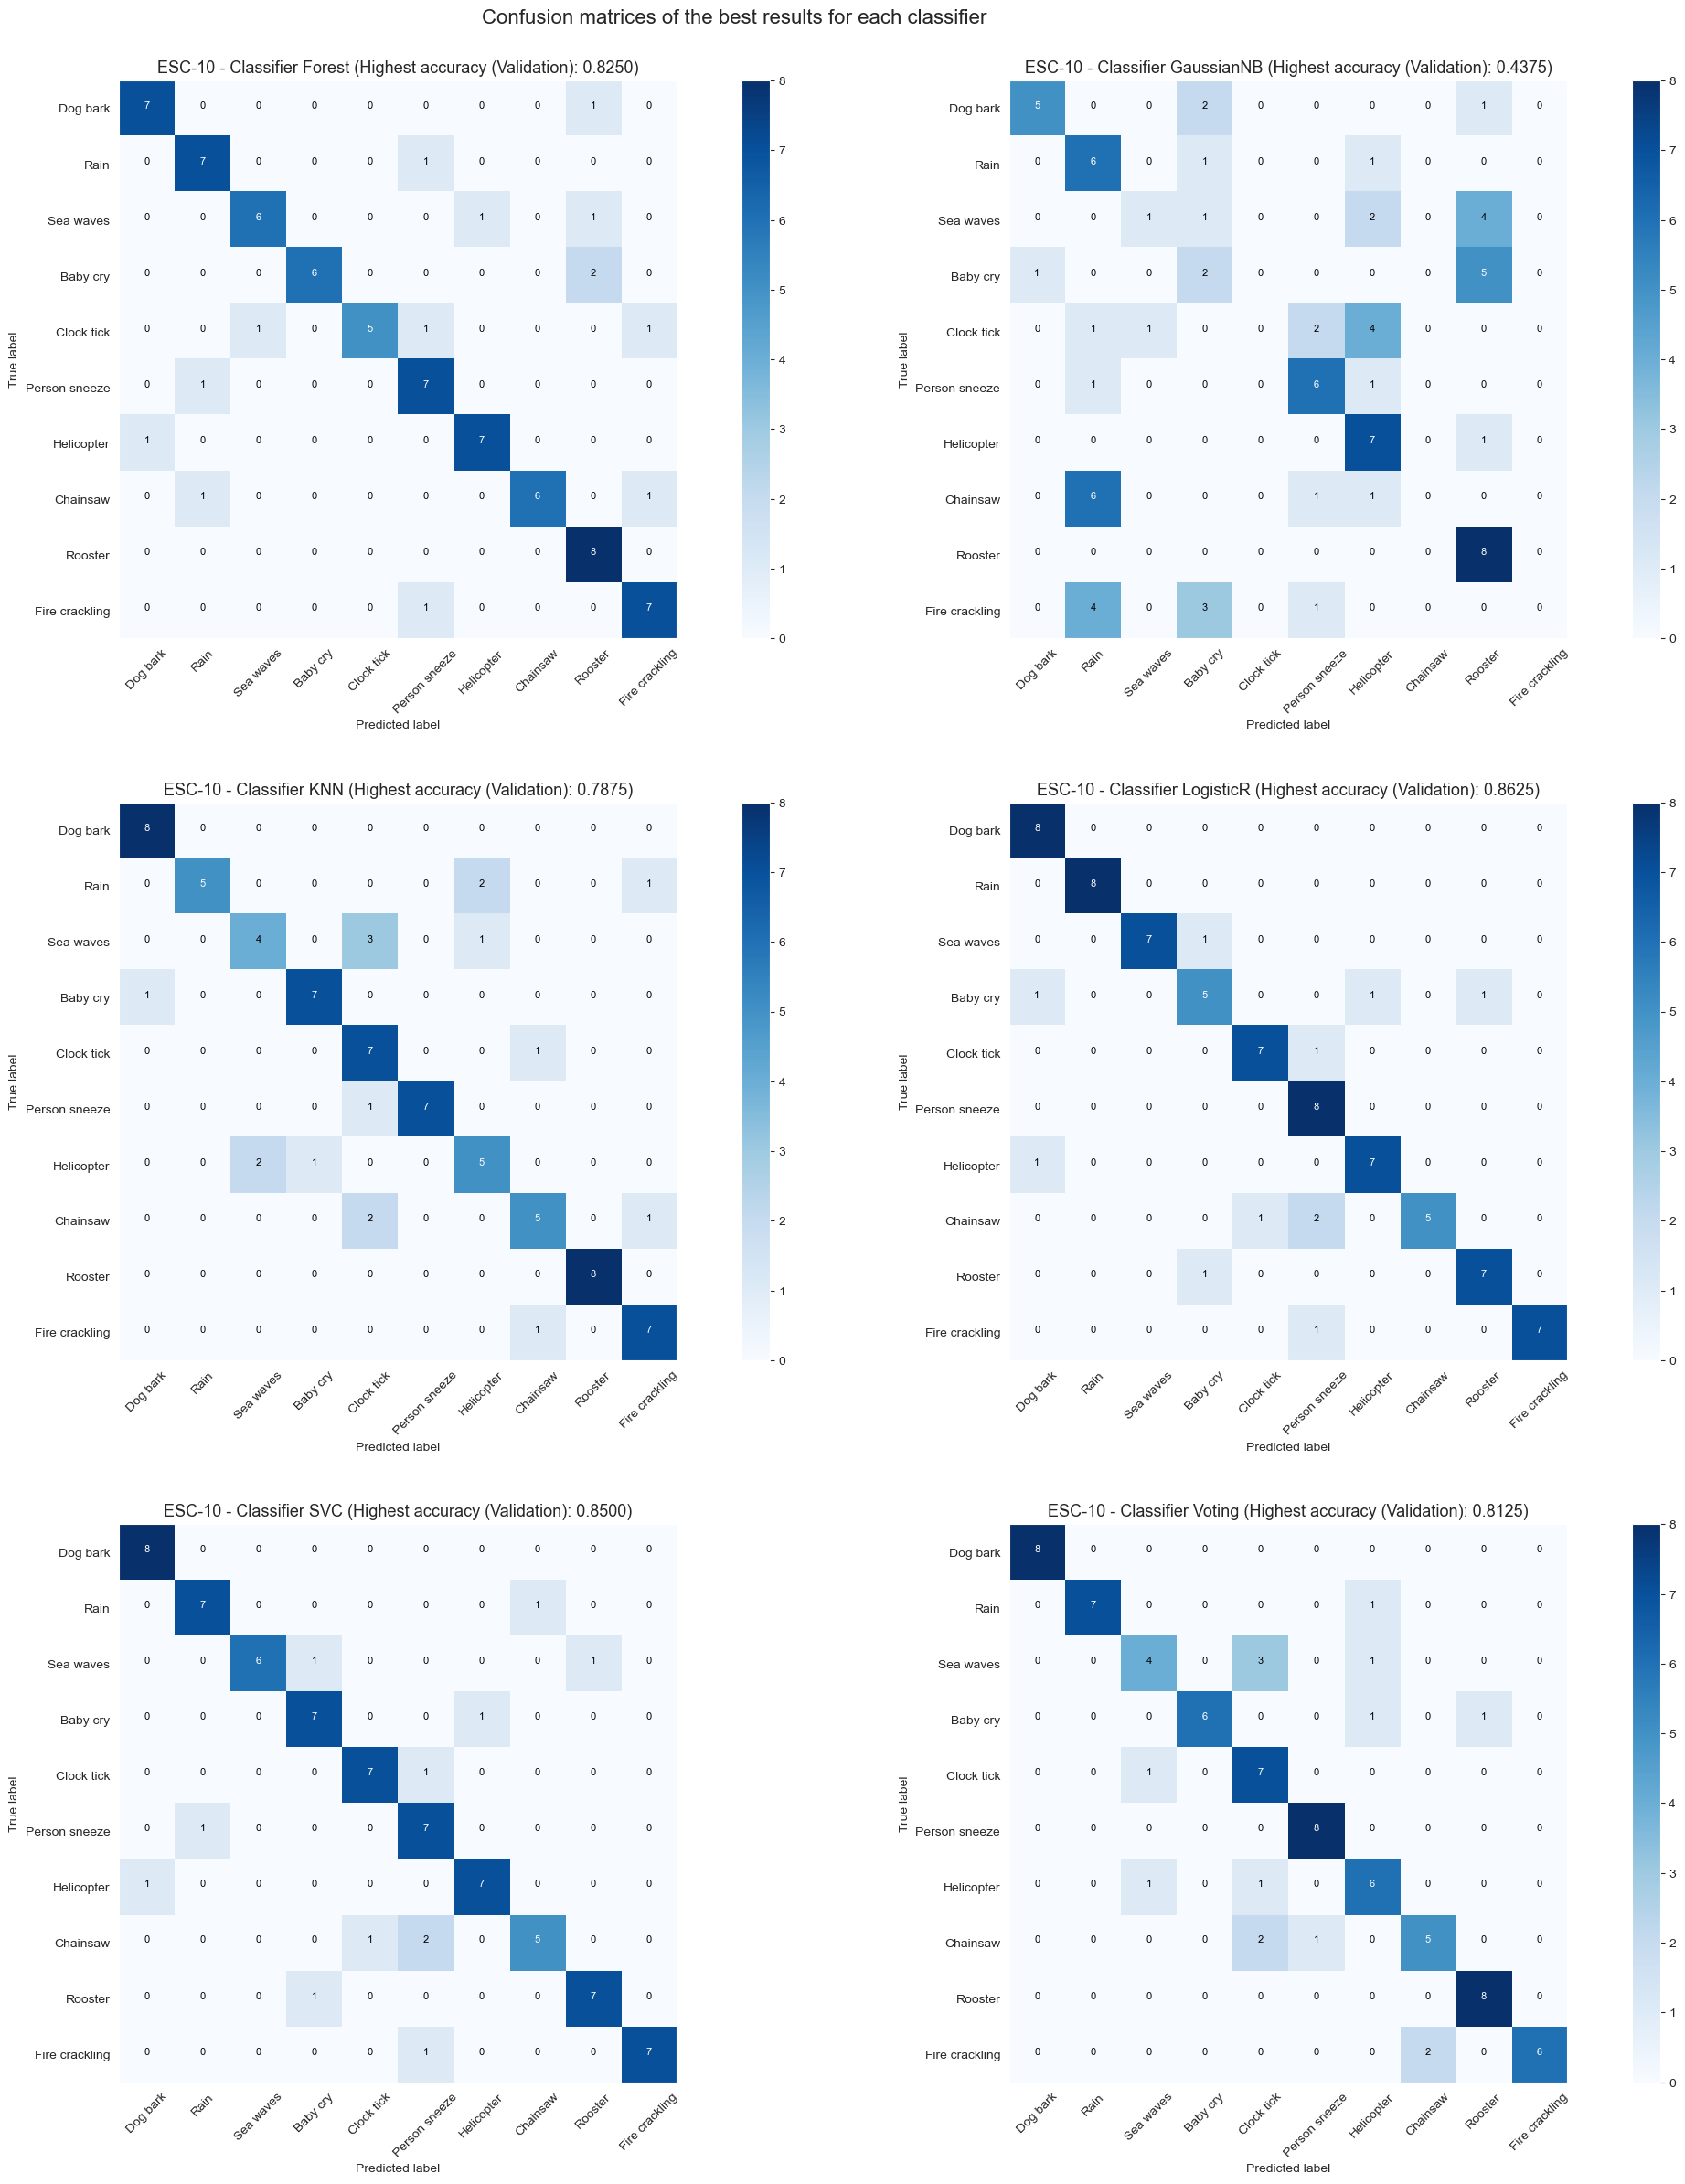

In [269]:
# Plot the confusion matrix for the highest accuracy test classifiers

plt.figure(figsize=(25,25))
plt.suptitle('Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.97)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = DATASET + ' - Classifier '+ i + ' (Highest accuracy (Validation): ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Validation)'])) +')'
    plt.subplot(3,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          cm_labels, 
                          title,
                          cmap = None,                          
                          normalize = False)
plt.tight_layout(pad=4.0)
plt.savefig(path_pic + '02_PreProcessing_modeling_19.png')
plt.show()

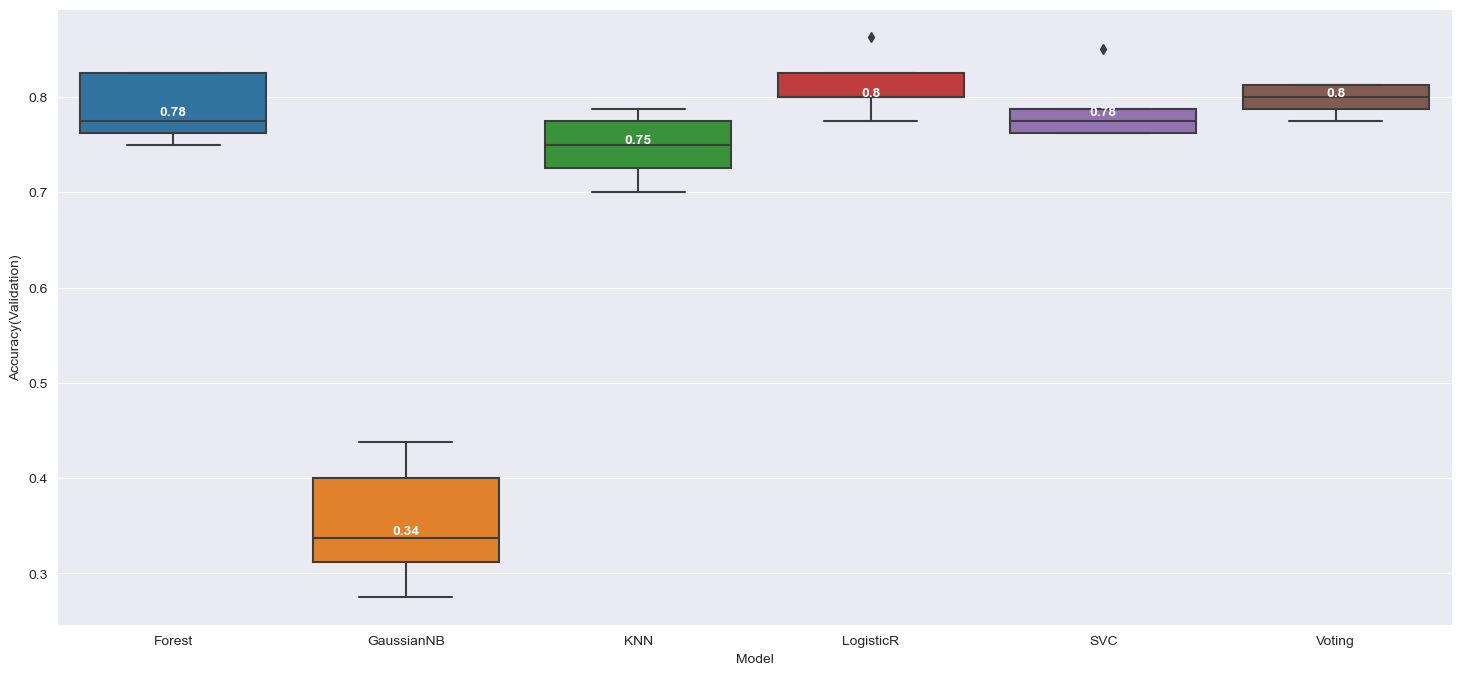

In [270]:
plt.figure(figsize=(18,8))
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Validation)", showfliers = True)

medians = list(metrics_set.groupby(['Model'])['Accuracy(Validation)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Validation)'].median()*0.001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')

# End of notebook